In [1]:
import numpy as np
import pandas as pd
#import wfdb
import os
from glob import glob
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import scipy.signal as signal
from scipy.signal import butter, lfilter
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision.models.alexnet import alexnet


seed=2020
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

In [2]:
reclist=glob("./seg/*")
dtlist=glob("./seg/*/*.npy*")
reclist.sort()
dtlist.sort()
lab_list=[seg.split('_')[0][-1] for seg in dtlist]#shuffle by idx
(dtlist[0].split('_')[1]+'_'+dtlist[0].split('_')[-1].split('.')[0])

'a01_100'

In [3]:
def cheb_bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):    # 
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        #b, a = butter(filter_order, [low, high], btype="band")
        b, a = signal.cheby2(filter_order, 40, [low, high], 'band', analog=False)
        y = lfilter(b, a, data)
        return y

In [4]:
subjects=[['a11'],['a15'],['a17'],['b01'],['c07'],
          ['a11','a15','a17','b01','c07'],
          ['a14','a19','b05','c01','c07'],
          ['a04','a19','b05','c01','c09'],['b02','b03'],['x16','x21']]
len(subjects)

10

In [5]:
from sklearn.model_selection import KFold
def getTrainTestList(reclist,opt='rec_cv',fold=1):
    train_dtlist=[]
    test_dtlist=[]
    if opt=='rec_cv':#reclist is rec list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(reclist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_rec,test_rec=list(np.array(reclist)[train_idx]),list(np.array(reclist)[test_idx])
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        test_rec=[rec for rec in reclist if rec[-3]=='x']
        print(len(train_rec),len(test_rec))
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')
    elif opt=='physionet_train':
        train_rec=[rec for rec in reclist if rec[-3]!='x']
        #print(len(train_rec),len(test_rec))
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
    elif opt=='blind':
        subjects=[['a11'],
                  ['a15','x27','x28'],
                  ['a17','x12'],
                  ['b01','x03'],
                  ['c07','x34'],
                  ['a11','a15','x27','x28','a17','x12','b01','x03','c07','x34'],
                  ['a14','a19','x05','x08','x25','b05','x11','c01','x35','c07','x34'],
                  ['a04','a19','x05','x08','x25','b05','x11','c01','x35','c09'],
                  ['b02','b03','x16','x21']]
        train_rec=[rec for rec in reclist if rec.split('/')[-1] not in subjects[fold-1]]
        test_rec=[rec for rec in reclist if rec.split('/')[-1] in subjects[fold-1]]
        print(len(train_rec),len(test_rec),test_rec)
        for rec in train_rec:
            train_dtlist+=glob(rec+'/*.npy*')
        for rec in test_rec:
            test_dtlist+=glob(rec+'/*.npy*')

    else:#reclist is npy data list
        kf = KFold(n_splits=10)
        kf_idx=kf.split(dtlist)
        for fold_idx in range(fold):#1,2,3,4,5
            train_idx,test_idx=kf_idx.__next__()
        train_dtlist,test_dtlist=list(np.array(dtlist)[train_idx]),list(np.array(dtlist)[test_idx])
         
    return train_dtlist,test_dtlist

def dtclean(dt_path):
    dt=np.load(dt_path)
    if dt.std()<0.1:
#        print(dt_path)
        return 1      
    else:
        return 0

#train_rec,test_rec=reclist[train_idx],reclist[test_idx]
#train_dtlist,test_dtlist=getTrainTestList(reclist,opt='kfold',fold=1)#fold 1-10
#print('*********')
#print(len(train_dtlist),len(test_dtlist))
#train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
#np.random.shuffle(train_dtlist)
#test_dtlist=[file for file in test_dtlist if dtclean(file)==0]

#print(len(train_dtlist),len(test_dtlist))


In [6]:
import numpy as np
from torch.utils.data import DataLoader,Dataset
ApneaECGDict={'N':0,
              'A':1}
class ApneaECGDataset(Dataset):
    def __init__(self, filelist, istrain=False):
        # Get the filelist and img data
        self.filelist = filelist
        self.istrain = istrain
        
    def getFeature(self, dt):
#         dt=dt.reshape(-1,100)
#         if self.istrain:
#             shift=np.random.randint(0,5)
#             shift=0
#         else:
#             shift=0
#         dt=dt[:,shift::]
#         dt_flag=dt[:,20::]*dt[:,0:-20]
#         pd_dt=pd.DataFrame(dt)
#         pd_dt_flag=pd.DataFrame(dt_flag)
#scipy.signal.stft(x,fs=1.0,window='hann',nperseg=256,noverlap=None,nfft=None,detrend=False,return_onesided=True,boundary='zeros',padded=True,axis=-1)
        dt=cheb_bandpass_filter(dt, 0.01, 38, 100, 4)
    
    
        f, t, Sxx=signal.spectrogram(dt, fs=100.0, window=('hamming'), nperseg=128, noverlap=64, nfft=128, detrend='constant',
        return_onesided=True, scaling='density', axis=-1, mode='psd')
        return Sxx[0:26]
        
#         return np.concatenate((dt_flag.max(axis=1,keepdims=True),
#                                dt_flag.min(axis=1,keepdims=True),
#                                dt_flag.std(axis=1,keepdims=True),
#                                dt.std(axis=1,keepdims=True),
#             abs(dt).sum(axis=1,keepdims=True)/100,
#             abs(dt_flag).sum(axis=1,keepdims=True)/100,
#             (dt.argmax(axis=1)-dt.argmax(axis=1)[0])[:,np.newaxis]/100,
#             (dt.argmin(axis=1)-dt.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmin(axis=1)-dt_flag.argmin(axis=1)[0])[:,np.newaxis]/100,
#             (dt_flag.argmax(axis=1)-dt_flag.argmax(axis=1)[0])[:,np.newaxis]/100,
#                                dt.mean(axis=1,keepdims=True),#
#                                dt.min(axis=1,keepdims=True),
#                                dt.max(axis=1,keepdims=True),
#                                #pd_dt.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt.kurt(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.skew(axis=1).values[:,np.newaxis],
#                                #pd_dt_flag.kurt(axis=1).values[:,np.newaxis]
#                                ),axis=1)
    def __getitem__(self, index):
        # return to the data of a Picture
        dt_path = self.filelist[index]
        label = ApneaECGDict.__getitem__(dt_path.split('_')[0][-1])
        data = np.load(dt_path)
        seg_id= dt_path.split('_')[1]+'_'+ dt_path.split('_')[-1].split('.')[0]

        if self.istrain:
            noise = np.random.normal(0, 0.1, data.shape[0])
            data = noise+data
        data=self.getFeature(data)
        return data, label,seg_id

    def __len__(self):
        return len(self.filelist)

class conv3x3(nn.Module):#ACNet

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, 
                 padding=1, dilation=1, groups=1, padding_mode='zeros', bias=False, deploy=False):
        super(conv3x3, self).__init__()
        self.deploy=deploy
        if self.deploy:
            self.fused_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(kernel_size,kernel_size), stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=False, padding_mode=padding_mode)
# c=a.square_conv.weight.data.numpy().copy()
# c[:,:,1:2,:]=a.square_conv.weight.data[:,:,1:2,:,].numpy().copy()+a.hor_conv.weight.data[:,:,0:1,:,].numpy().copy()
# c[:,:,:,1:2]+=a.ver_conv.weight.data[:,:,:,0:1].numpy().copy()
# c-a.square_conv.weight.data.numpy()
# b.fused_conv.weight.data=torch.FloatTensor(c)    
        else:
            self.square_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=(kernel_size, kernel_size), stride=stride,
                                         padding=padding, dilation=dilation, groups=groups, bias=False,
                                         padding_mode=padding_mode)

            center_offset_from_origin_border = padding - kernel_size // 2 #1-3//2=0
            ver_pad_or_crop = (center_offset_from_origin_border + 1, center_offset_from_origin_border)
            hor_pad_or_crop = (center_offset_from_origin_border, center_offset_from_origin_border + 1)
            if center_offset_from_origin_border >= 0:
                self.ver_conv_crop_layer = nn.Identity()
                ver_conv_padding = ver_pad_or_crop
                self.hor_conv_crop_layer = nn.Identity()
                hor_conv_padding = hor_pad_or_crop

            self.ver_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 1),
                                      stride=stride,
                                      padding=ver_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

            self.hor_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, 3),
                                      stride=stride,
                                      padding=hor_conv_padding, dilation=dilation, groups=groups, bias=False,
                                      padding_mode=padding_mode)

    # forward函数
    def forward(self, input):
        if self.deploy:
            #assert self.square_conv
            print("True")
            return self.fused_conv(input)
        square_outputs = self.square_conv(input)
        # print(square_outputs.size())
        # return square_outputs
        vertical_outputs = self.ver_conv(input)
        # print(vertical_outputs.size())
        #horizontal_outputs = self.hor_conv_crop_layer(input)
        horizontal_outputs = self.hor_conv(input)
        # print(horizontal_outputs.size())
        return square_outputs + vertical_outputs + horizontal_outputs
    
class MyLSTM(nn.Module):
    def __init__(self, class_num,fs):
        super(MyLSTM, self).__init__()
        #self.bn=nn.BatchNorm1d(60)
#         self.conv10=nn.Sequential(nn.Conv1d(1,64,kernel_size=10,stride=10,padding=0, bias=False),
#                   nn.Conv1d(64,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                   nn.Conv1d(32,32,kernel_size=3,stride=2,padding=0, bias=False),
#                   nn.MaxPool1d(kernel_size=3,stride=2),
#                                nn.ReLU())1200
#25 * 65
#12* 32
#b*64*6*16
#b*6*64*16
        self.branch1=nn.Sequential(nn.Conv2d(1,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
                                #nn.ReLU(),                               
                                nn.LayerNorm([fs,26,92],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.25),
                                #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.25),
                                
#                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.25),
                                nn.LayerNorm([fs,13,46],elementwise_affine=False),
                                nn.ReLU(), 
                                nn.Dropout(p=0.5),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
                                #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
                                nn.MaxPool2d(kernel_size=2,stride=2),
                                #nn.Dropout(p=0.5),
                                nn.LayerNorm([fs,6,23],elementwise_affine=False),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
                                nn.Conv2d(fs,fs,kernel_size=3,dilation=1,stride=1,padding=1, bias=False))
        
#         self.branch2=nn.Sequential(nn.Conv2d(1,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(32,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(3,1),dilation=1,stride=1,padding=0, bias=False),
#                                 #nn.ReLU(),                               
#                                 nn.LayerNorm([32,25,92]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 #nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.25),
                                
# #                                 nn.Conv2d(64,64,kernel_size=3,dilation=1,stride=1,padding=1, bias=False),
# #                                 nn.ReLU(),
# #                                 nn.Dropout(p=0.25),
#                                 nn.LayerNorm([32,12,46]),
#                                 nn.ReLU(), 
#                                 nn.Dropout(p=0.25),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False),
#                                 #nn.Conv2d(64,64,kernel_size=(5,1),dilation=1,stride=1,padding=0, bias=False),
                                                          
#                                 nn.MaxPool2d(kernel_size=2,stride=2),
#                                 #nn.Dropout(p=0.5),
#                                 nn.LayerNorm([32,6,23]),
#                                 nn.ReLU(),
#                                 nn.Dropout(p=0.5),
#                                 #nn.Conv2d(64,64,kernel_size=(1,3),dilation=1,stride=1,padding=0, bias=False),
#                                 nn.Conv2d(32,32,kernel_size=5,dilation=1,stride=1,padding=2, bias=False))
        
        self.avg = nn.Sequential(nn.AdaptiveMaxPool2d((8,8)),nn.LayerNorm([6,8,8],elementwise_affine=False))
    
        self.lstm = nn.LSTM(64, 8, 2,
                            bias=False,
                            batch_first=True,
                            dropout=0.5,
                            bidirectional=True)
        #self.conv2=nn.Sequential(nn.Conv1d(64,64,kernel_size=1,stride=1,padding=0, bias=False))
        
        self.fc=nn.Sequential(nn.Linear(16*2,class_num))
    def attention_net(self,lstm_output, final_state):
        hidden = final_state.view(-1, 16, 2)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        #print('hi',hidden.shape)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        #print('att',attn_weights.shape)
        soft_attn_weights = F.softmax(attn_weights, 1)
        #print('sft',soft_attn_weights.shape)
        #print('yimr',torch.bmm(lstm_output.transpose(1, 2),soft_attn_weights).shape)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context#, soft_attn_weights.data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]
    def forward(self, x):
        x=x.unsqueeze(dim=1)#x.reshape(x.shape[0],1,-1)
        #x1=self.conv10(x)
        out=self.branch1(x)
        #out_1=self.branch1(x)
        #out_2=self.branch2(x)
        #out=torch.cat((out_1,out_2),1)
        #print(out.shape)
        out=out.permute(0,2,1,3)
        out=self.avg(out)
        #print(out.shape)
        out=out.view(out.shape[0],out.shape[1],-1)
        #print(x2.shape)
        #print(x1.shape,x2.shape)
        #x=torch.cat((x1,x2),dim=1)
        #print(x.shape)
        out,(h,c) = self.lstm(out)
        out=self.attention_net(out, h)
        
        #out = self.conv2(out)
        #print(out.shape)
        out = self.fc(out.reshape(out.shape[0],-1))
        return out

In [7]:
def eval(model,test_dtlist,criterion,my_device):
    test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    test_loader=DataLoader(test_dataset, batch_size=128, shuffle=False, sampler=None, num_workers=0)
    #train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
        #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
    #train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
    sft=nn.Softmax().to(my_device)
    all_pred_prob=torch.Tensor([]).to(my_device)
    all_label=torch.Tensor([]).long().to(my_device)
    all_seg=[]#torch.Tensor([]).to(my_device)
    flag=0
    with torch.no_grad():
        for fe, label,seg_id in test_loader:
            fe=fe.float().to(my_device)
            #fe=(fe-fe_mean)/fe_std
            label=label.long().to(my_device)
            pred_prob_no_softmax=model(fe)
            all_pred_prob=torch.cat((all_pred_prob,pred_prob_no_softmax),0)
            all_label=torch.cat((all_label,label),0)
            all_seg+=list(seg_id)
            loss=criterion(pred_prob_no_softmax,label)
            flag+=1
            if flag%8==0:
                print('Eval Loss: ',loss.item())
            #pos=(sft(pred_prob_no_softmax)[:,1]>0.5)
            #print("Acc: ", sum(label==pos).detach().numpy()/len(label))
    all_pred=sft(all_pred_prob)[:,1].detach().cpu().numpy()
    all_pred[all_pred>0.5]=1
    all_pred[all_pred<=0.5]=0
    all_label=all_label.detach().cpu().numpy()
    #all_seg=all_seg.detach().cpu().numpy()
    print(confusion_matrix(all_label,all_pred))
    print(classification_report(all_label,all_pred))
    print("acc: ",accuracy_score(all_label,all_pred))
    print("pre: ",precision_score(all_label,all_pred))
    print("rec: ",recall_score(all_label,all_pred))
    print("ma F1: ",f1_score(all_label,all_pred, average='macro'))
    print("mi F1: ",f1_score(all_label,all_pred, average='micro'))
    print("we F1: ",f1_score(all_label,all_pred, average='weighted'))
    return sft(all_pred_prob)[:,1].detach().cpu().numpy(),all_label, accuracy_score(all_label,all_pred),all_seg

  
kernel: 128
  
*********
29459 3432
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16663265228271484
Loss:  0.15564793348312378
Loss:  0.16349181532859802
0 **********
Epoch:  79.27403664588928  fold:  1  kers:  128
epoch:  1
29459 461
Loss:  0.13513968884944916
Loss:  0.1403122991323471
Loss:  0.13822351396083832
1 **********
Epoch:  143.91530990600586  fold:  1  kers:  128
epoch:  2
29459 461
Loss:  0.10495071858167648
Loss:  0.11497092992067337
Loss:  0.1025097668170929
2 **********
Epoch:  209.16384744644165  fold:  1  kers:  128
epoch:  3
Eval Loss:  0.4028968811035156
Eval Loss:  0.7280868291854858
Eval Loss:  0.27643412351608276


D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
D:\anaconda\install\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 874  165]
 [ 938 1455]]
              precision    recall  f1-score   support

           0       0.48      0.84      0.61      1039
           1       0.90      0.61      0.73      2393

    accuracy                           0.68      3432
   macro avg       0.69      0.72      0.67      3432
weighted avg       0.77      0.68      0.69      3432

acc:  0.6786130536130536
pre:  0.8981481481481481
rec:  0.6080234015879649
ma F1:  0.6691307442324196
mi F1:  0.6786130536130536
we F1:  0.6912289316702481
update!  Acc:  0.6786130536130536
Eval Loss:  0.4403660297393799
Eval Loss:  0.4998396039009094
Eval Loss:  0.49914804100990295
Eval Loss:  0.5315762162208557
Eval Loss:  0.4509856700897217
Eval Loss:  0.515860378742218
Eval Loss:  0.44479233026504517
Eval Loss:  0.46627068519592285
Eval Loss:  0.4494766891002655
Eval Loss:  0.42986950278282166
Eval Loss:  0.3680554926395416
Eval Loss:  0.49180129170417786
Eval Loss:  0.43434739112854004
Eval Loss:  0.4592033922672272
Eval Loss:  0.451

Eval Loss:  0.4223805069923401
Eval Loss:  0.29920896887779236
Eval Loss:  0.33690664172172546
Eval Loss:  0.2665312886238098
Eval Loss:  0.2370409071445465
Eval Loss:  0.3469729423522949
Eval Loss:  0.3197765648365021
Eval Loss:  0.34642472863197327
Eval Loss:  0.3464012145996094
Eval Loss:  0.5074449777603149
Eval Loss:  0.387678861618042
Eval Loss:  0.4029199481010437
Eval Loss:  0.37017813324928284
Eval Loss:  0.35940736532211304
Eval Loss:  0.2584151029586792
Eval Loss:  0.2428557127714157
Eval Loss:  0.26676076650619507
Eval Loss:  0.4527418911457062
Eval Loss:  0.3064638674259186
Eval Loss:  0.4305464029312134
Eval Loss:  0.3232746422290802
Eval Loss:  0.37803030014038086
[[18578   547]
 [ 3307  7027]]
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     19125
           1       0.93      0.68      0.78     10334

    accuracy                           0.87     29459
   macro avg       0.89      0.83      0.85     29459
weighted 

Eval Loss:  0.24502329528331757
[[17962  1163]
 [ 1583  8751]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     19125
           1       0.88      0.85      0.86     10334

    accuracy                           0.91     29459
   macro avg       0.90      0.89      0.90     29459
weighted avg       0.91      0.91      0.91     29459

acc:  0.9067857021623273
pre:  0.8826911438369982
rec:  0.8468163344300368
ma F1:  0.8966852737970552
mi F1:  0.9067857021623273
we F1:  0.9063251463146003
29459 461
Loss:  0.07609304785728455
Loss:  0.07296551018953323
Loss:  0.04665142670273781
21 **********
Epoch:  1710.8919470310211  fold:  1  kers:  128
epoch:  22
29459 461
Loss:  0.06113831698894501
Loss:  0.06045575067400932
Loss:  0.07519461959600449
22 **********
Epoch:  1774.9895629882812  fold:  1  kers:  128
epoch:  23
29459 461
Loss:  0.06896345317363739
Loss:  0.07157579064369202
Loss:  0.08188551664352417
23 **********
Epoch:  1839.082192

Loss:  0.0731552243232727
Loss:  0.040343835949897766
Loss:  0.07971369475126266
31 **********
Epoch:  2473.0760219097137  fold:  1  kers:  128
epoch:  32
29459 461
Loss:  0.056734006851911545
Loss:  0.08393938094377518
Loss:  0.03912864625453949
32 **********
Epoch:  2537.164662361145  fold:  1  kers:  128
epoch:  33
Eval Loss:  1.1171334981918335
Eval Loss:  0.37007033824920654
Eval Loss:  0.07445254176855087
[[ 840  199]
 [ 522 1871]]
              precision    recall  f1-score   support

           0       0.62      0.81      0.70      1039
           1       0.90      0.78      0.84      2393

    accuracy                           0.79      3432
   macro avg       0.76      0.80      0.77      3432
weighted avg       0.82      0.79      0.80      3432

acc:  0.789918414918415
pre:  0.9038647342995169
rec:  0.7818637693272044
ma F1:  0.7690789641294243
mi F1:  0.789918414918415
we F1:  0.7964471662325215
Eval Loss:  0.14670324325561523
Eval Loss:  0.2247896045446396
Eval Loss:  0.

Eval Loss:  0.13907761871814728
Eval Loss:  0.20562565326690674
Eval Loss:  0.29640454053878784
Eval Loss:  0.26467305421829224
Eval Loss:  0.14324523508548737
Eval Loss:  0.19722560048103333
Eval Loss:  0.2768102288246155
Eval Loss:  0.12655320763587952
Eval Loss:  0.21707281470298767
Eval Loss:  0.16296809911727905
Eval Loss:  0.13254903256893158
Eval Loss:  0.16515880823135376
Eval Loss:  0.18904387950897217
Eval Loss:  0.2611846923828125
Eval Loss:  0.2066243588924408
Eval Loss:  0.25300800800323486
Eval Loss:  0.1984945386648178
Eval Loss:  0.20142264664173126
Eval Loss:  0.2583392560482025
Eval Loss:  0.23065006732940674
Eval Loss:  0.15656980872154236
Eval Loss:  0.12251787632703781
Eval Loss:  0.13496966660022736
Eval Loss:  0.2472134232521057
Eval Loss:  0.15467914938926697
Eval Loss:  0.2581990361213684
Eval Loss:  0.1967693269252777
Eval Loss:  0.1740112155675888
[[18318   807]
 [ 1430  8904]]
              precision    recall  f1-score   support

           0       0.93    

Eval Loss:  0.13325367867946625
Eval Loss:  0.2308558076620102
Eval Loss:  0.13265681266784668
Eval Loss:  0.20382460951805115
Eval Loss:  0.19839368760585785
Eval Loss:  0.18062306940555573
[[18018  1107]
 [  947  9387]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     19125
           1       0.89      0.91      0.90     10334

    accuracy                           0.93     29459
   macro avg       0.92      0.93      0.92     29459
weighted avg       0.93      0.93      0.93     29459

acc:  0.9302759767812893
pre:  0.8945111492281304
rec:  0.9083607509192956
ma F1:  0.9237289196546261
mi F1:  0.9302759767812893
we F1:  0.9303973450051642
29459 461
Loss:  0.06759805977344513
Loss:  0.05191748961806297
Loss:  0.05711370334029198
51 **********
Epoch:  4036.1826510429382  fold:  1  kers:  128
epoch:  52
29459 461
Loss:  0.055240146815776825
Loss:  0.05580234155058861
Loss:  0.0723283588886261
52 **********
Epoch:  4100.12468290329 

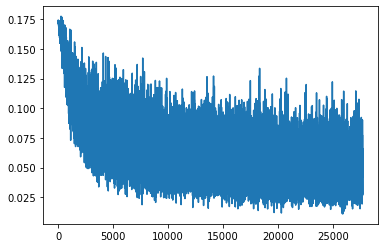

------
*********
29797 3094
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.1686757355928421
Loss:  0.16367332637310028
Loss:  0.16378545761108398
0 **********
Epoch:  77.16766929626465  fold:  2  kers:  128
epoch:  1
29797 466
Loss:  0.16518306732177734
Loss:  0.11896036565303802
Loss:  0.1090717762708664
1 **********
Epoch:  141.80584001541138  fold:  2  kers:  128
epoch:  2
29797 466
Loss:  0.11156641691923141
Loss:  0.10102950781583786
Loss:  0.10861106216907501
2 **********
Epoch:  206.49686908721924  fold:  2  kers:  128
epoch:  3
Eval Loss:  0.7586417198181152
Eval Loss:  0.20982469618320465
Eval Loss:  0.6310229897499084
[[1138  292]
 [ 545 1119]]
              pre

Loss:  0.04907730594277382
Loss:  0.04997717961668968
Loss:  0.07321567833423615
11 **********
Epoch:  909.949978351593  fold:  2  kers:  128
epoch:  12
Eval Loss:  0.5609974265098572
Eval Loss:  0.3933209180831909
Eval Loss:  0.5404314994812012
[[1284  146]
 [ 641 1023]]
              precision    recall  f1-score   support

           0       0.67      0.90      0.77      1430
           1       0.88      0.61      0.72      1664

    accuracy                           0.75      3094
   macro avg       0.77      0.76      0.74      3094
weighted avg       0.78      0.75      0.74      3094

acc:  0.7456367162249515
pre:  0.8751069289991446
rec:  0.6147836538461539
ma F1:  0.7438136756336198
mi F1:  0.7456367162249515
we F1:  0.742179225448288
update!  Acc:  0.7456367162249515
Eval Loss:  0.25199949741363525
Eval Loss:  0.23965959250926971
Eval Loss:  0.22856509685516357
Eval Loss:  0.22536838054656982
Eval Loss:  0.19739308953285217
Eval Loss:  0.25334474444389343
Eval Loss:  0.23692

Eval Loss:  0.22844375669956207
Eval Loss:  0.2727242410182953
Eval Loss:  0.26200053095817566
Eval Loss:  0.2083042711019516
Eval Loss:  0.20045171678066254
Eval Loss:  0.2218388170003891
Eval Loss:  0.24762655794620514
Eval Loss:  0.25181710720062256
Eval Loss:  0.19006507098674774
Eval Loss:  0.2585933208465576
Eval Loss:  0.22874927520751953
Eval Loss:  0.16194836795330048
Eval Loss:  0.26090994477272034
Eval Loss:  0.2477443367242813
Eval Loss:  0.1902136355638504
Eval Loss:  0.23676326870918274
Eval Loss:  0.1747157722711563
Eval Loss:  0.192504420876503
Eval Loss:  0.19161070883274078
Eval Loss:  0.14464548230171204
Eval Loss:  0.18451671302318573
Eval Loss:  0.17226526141166687
Eval Loss:  0.2892111837863922
Eval Loss:  0.3870239555835724
Eval Loss:  0.2590688467025757
Eval Loss:  0.15952350199222565
Eval Loss:  0.25423070788383484
Eval Loss:  0.21551495790481567
Eval Loss:  0.1802462339401245
[[18056   678]
 [ 2073  8990]]
              precision    recall  f1-score   support


Eval Loss:  0.14510132372379303
Eval Loss:  0.22110971808433533
Eval Loss:  0.16955091059207916
Eval Loss:  0.2604616582393646
Eval Loss:  0.30375048518180847
Eval Loss:  0.21802882850170135
Eval Loss:  0.1650879979133606
Eval Loss:  0.24068951606750488
Eval Loss:  0.1955823004245758
Eval Loss:  0.14902432262897491
[[17817   917]
 [ 1324  9739]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     18734
           1       0.91      0.88      0.90     11063

    accuracy                           0.92     29797
   macro avg       0.92      0.92      0.92     29797
weighted avg       0.92      0.92      0.92     29797

acc:  0.924791086350975
pre:  0.9139451951951952
rec:  0.8803217933652716
ma F1:  0.9188250685283088
mi F1:  0.924791086350975
we F1:  0.9244904959506499
29797 466
Loss:  0.0538741759955883
Loss:  0.044248420745134354
Loss:  0.0556514710187912
30 **********
Epoch:  2422.9265863895416  fold:  2  kers:  128
epoch:  31
29797 4

Loss:  0.0496598444879055
Loss:  0.05013073980808258
Loss:  0.028210116550326347
39 **********
Epoch:  3126.4415304660797  fold:  2  kers:  128
epoch:  40
29797 466
Loss:  0.04694115370512009
Loss:  0.0440734401345253
Loss:  0.0626600831747055
40 **********
Epoch:  3191.120591878891  fold:  2  kers:  128
epoch:  41
29797 466
Loss:  0.0723579078912735
Loss:  0.06168803945183754
Loss:  0.04883147031068802
41 **********
Epoch:  3255.8515145778656  fold:  2  kers:  128
epoch:  42
Eval Loss:  0.38739749789237976
Eval Loss:  0.1352769285440445
Eval Loss:  1.0480481386184692
[[1213  217]
 [ 576 1088]]
              precision    recall  f1-score   support

           0       0.68      0.85      0.75      1430
           1       0.83      0.65      0.73      1664

    accuracy                           0.74      3094
   macro avg       0.76      0.75      0.74      3094
weighted avg       0.76      0.74      0.74      3094

acc:  0.7436974789915967
pre:  0.8337164750957854
rec:  0.6538461538461

Eval Loss:  0.17939876019954681
Eval Loss:  0.152908593416214
Eval Loss:  0.16866910457611084
Eval Loss:  0.16142837703227997
Eval Loss:  0.13451075553894043
Eval Loss:  0.18644516170024872
Eval Loss:  0.1980983167886734
Eval Loss:  0.20779985189437866
Eval Loss:  0.14172735810279846
Eval Loss:  0.17107337713241577
Eval Loss:  0.19355621933937073
Eval Loss:  0.09062858670949936
Eval Loss:  0.16794301569461823
Eval Loss:  0.20172464847564697
Eval Loss:  0.17007586359977722
Eval Loss:  0.13300374150276184
Eval Loss:  0.08224262297153473
Eval Loss:  0.16516298055648804
Eval Loss:  0.18332761526107788
Eval Loss:  0.1578330546617508
Eval Loss:  0.1669163554906845
Eval Loss:  0.1417340189218521
Eval Loss:  0.21069374680519104
Eval Loss:  0.2690149247646332
Eval Loss:  0.20154781639575958
Eval Loss:  0.12260468304157257
Eval Loss:  0.21201518177986145
Eval Loss:  0.17356593906879425
Eval Loss:  0.12686359882354736
[[17859   875]
 [ 1106  9957]]
              precision    recall  f1-score   su

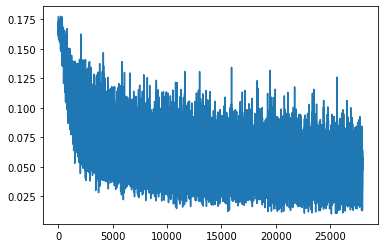

------
*********
29460 3431
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.16647633910179138
Loss:  0.15873803198337555
Loss:  0.15639261901378632
0 **********
Epoch:  76.27505588531494  fold:  3  kers:  128
epoch:  1
29460 461
Loss:  0.15222695469856262
Loss:  0.1284547746181488
Loss:  0.11758904904127121
1 **********
Epoch:  140.25897645950317  fold:  3  kers:  128
epoch:  2
29460 461
Loss:  0.118489570915699
Loss:  0.10294690728187561
Loss:  0.09804585576057434
2 **********
Epoch:  204.247882604599  fold:  3  kers:  128
epoch:  3
Eval Loss:  1.0545073747634888
Eval Loss:  0.8866720199584961
Eval Loss:  0.43332043290138245
[[1389  147]
 [ 730 1165]]
              precis

Loss:  0.07038170844316483
Loss:  0.08608280122280121
Loss:  0.07747863978147507
11 **********
Epoch:  902.11891746521  fold:  3  kers:  128
epoch:  12
Eval Loss:  0.8893061876296997
Eval Loss:  0.25001025199890137
Eval Loss:  0.7780781984329224
[[1345  191]
 [ 651 1244]]
              precision    recall  f1-score   support

           0       0.67      0.88      0.76      1536
           1       0.87      0.66      0.75      1895

    accuracy                           0.75      3431
   macro avg       0.77      0.77      0.75      3431
weighted avg       0.78      0.75      0.75      3431

acc:  0.7545904983969688
pre:  0.8668989547038327
rec:  0.6564643799472295
ma F1:  0.754377650583766
mi F1:  0.7545904983969688
we F1:  0.7536210925150555
Eval Loss:  0.3976615369319916
Eval Loss:  0.5148065090179443
Eval Loss:  0.18371504545211792
Eval Loss:  0.30520302057266235
Eval Loss:  0.30620166659355164
Eval Loss:  0.31975501775741577
Eval Loss:  0.4241489768028259
Eval Loss:  0.3475717008

Eval Loss:  0.31588512659072876
Eval Loss:  0.3727566599845886
Eval Loss:  0.15704292058944702
Eval Loss:  0.16008146107196808
Eval Loss:  0.24243488907814026
Eval Loss:  0.214284285902977
Eval Loss:  0.30432507395744324
Eval Loss:  0.2247651219367981
Eval Loss:  0.22895419597625732
Eval Loss:  0.2535381615161896
Eval Loss:  0.26722562313079834
Eval Loss:  0.25623682141304016
Eval Loss:  0.3538898825645447
Eval Loss:  0.15961457788944244
Eval Loss:  0.25905346870422363
Eval Loss:  0.21259379386901855
Eval Loss:  0.23319818079471588
Eval Loss:  0.19114837050437927
Eval Loss:  0.22138752043247223
Eval Loss:  0.277571439743042
Eval Loss:  0.17529436945915222
Eval Loss:  0.33323124051094055
Eval Loss:  0.3307264745235443
Eval Loss:  0.17079690098762512
Eval Loss:  0.22664611041545868
Eval Loss:  0.22503440082073212
Eval Loss:  0.3406117856502533
Eval Loss:  0.20911654829978943
[[17847   781]
 [ 1911  8921]]
              precision    recall  f1-score   support

           0       0.90     

Eval Loss:  0.1707150638103485
Eval Loss:  0.19710992276668549
Eval Loss:  0.1997634321451187
Eval Loss:  0.2594965100288391
Eval Loss:  0.14359930157661438
[[17370  1258]
 [ 1076  9756]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     18628
           1       0.89      0.90      0.89     10832

    accuracy                           0.92     29460
   macro avg       0.91      0.92      0.92     29460
weighted avg       0.92      0.92      0.92     29460

acc:  0.9207739307535642
pre:  0.8857817323406574
rec:  0.9006646971935007
ma F1:  0.9151030243528027
mi F1:  0.9207739307535642
we F1:  0.9209094843344596
29460 461
Loss:  0.05952402949333191
Loss:  0.06893207877874374
Loss:  0.03953733667731285
30 **********
Epoch:  2402.0005388259888  fold:  3  kers:  128
epoch:  31
29460 461
Loss:  0.061997201293706894
Loss:  0.04641573131084442
Loss:  0.050312772393226624
31 **********
Epoch:  2466.0532755851746  fold:  3  kers:  128
epoch:  

Loss:  0.07439526170492172
Loss:  0.0637393519282341
39 **********
Epoch:  3100.35129070282  fold:  3  kers:  128
epoch:  40
29460 461
Loss:  0.04630960524082184
Loss:  0.05796019732952118
Loss:  0.040139585733413696
40 **********
Epoch:  3164.3870718479156  fold:  3  kers:  128
epoch:  41
29460 461
Loss:  0.0323021300137043
Loss:  0.042166225612163544
Loss:  0.10814909636974335
41 **********
Epoch:  3228.3939306735992  fold:  3  kers:  128
epoch:  42
Eval Loss:  0.42403316497802734
Eval Loss:  0.09647483378648758
Eval Loss:  0.9599894285202026
[[1246  290]
 [ 511 1384]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1536
           1       0.83      0.73      0.78      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.77      0.77      3431
weighted avg       0.77      0.77      0.77      3431

acc:  0.7665403672398717
pre:  0.8267622461170848
rec:  0.7303430079155673
ma F1:  0.7661620712

Eval Loss:  0.1989198923110962
Eval Loss:  0.2014099359512329
Eval Loss:  0.13505370914936066
Eval Loss:  0.1282510608434677
Eval Loss:  0.19516058266162872
Eval Loss:  0.14235343039035797
Eval Loss:  0.1762414574623108
Eval Loss:  0.17131371796131134
Eval Loss:  0.14353400468826294
Eval Loss:  0.1287127435207367
Eval Loss:  0.21401454508304596
Eval Loss:  0.20820070803165436
Eval Loss:  0.2542383074760437
Eval Loss:  0.10444682836532593
Eval Loss:  0.19842290878295898
Eval Loss:  0.1459379494190216
Eval Loss:  0.1462569534778595
Eval Loss:  0.1569242924451828
Eval Loss:  0.16227570176124573
Eval Loss:  0.18177567422389984
Eval Loss:  0.1419270932674408
Eval Loss:  0.22185978293418884
Eval Loss:  0.24714693427085876
Eval Loss:  0.13214072585105896
Eval Loss:  0.21634632349014282
Eval Loss:  0.1800806224346161
Eval Loss:  0.2176179587841034
Eval Loss:  0.14244712889194489
[[17742   886]
 [ 1052  9780]]
              precision    recall  f1-score   support

           0       0.94      0

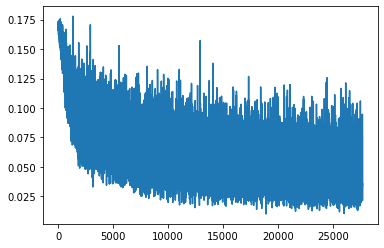

------
*********
29520 3371
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.1823037564754486
Loss:  0.16300451755523682
Loss:  0.15801399946212769
0 **********
Epoch:  76.44360494613647  fold:  4  kers:  128
epoch:  1
29520 462
Loss:  0.15696899592876434
Loss:  0.1254129558801651
Loss:  0.12189505994319916
1 **********
Epoch:  140.5641589164734  fold:  4  kers:  128
epoch:  2
29520 462
Loss:  0.13570448756217957
Loss:  0.09698525071144104
Loss:  0.11663872003555298
2 **********
Epoch:  204.68471550941467  fold:  4  kers:  128
epoch:  3
Eval Loss:  0.2219090312719345
Eval Loss:  0.2532064616680145
Eval Loss:  0.08780427277088165
[[2953  184]
 [ 201   33]]
              prec

Loss:  0.09520960599184036
Loss:  0.08169221132993698
Loss:  0.07459700852632523
11 **********
Epoch:  903.4134542942047  fold:  4  kers:  128
epoch:  12
Eval Loss:  0.1162947341799736
Eval Loss:  0.1243341788649559
Eval Loss:  0.021812908351421356
[[3100   37]
 [ 224   10]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3137
           1       0.21      0.04      0.07       234

    accuracy                           0.92      3371
   macro avg       0.57      0.52      0.52      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.9225749035894394
pre:  0.2127659574468085
rec:  0.042735042735042736
ma F1:  0.515389076864692
mi F1:  0.9225749035894394
we F1:  0.897932913428427
Eval Loss:  0.3529670536518097
Eval Loss:  0.3909338712692261
Eval Loss:  0.2547794580459595
Eval Loss:  0.37319639325141907
Eval Loss:  0.3260227143764496
Eval Loss:  0.3280925154685974
Eval Loss:  0.44853994250297546
Eval Loss:  0.32336744

Eval Loss:  0.22178788483142853
Eval Loss:  0.25125959515571594
Eval Loss:  0.20958372950553894
Eval Loss:  0.2755274474620819
Eval Loss:  0.21843862533569336
Eval Loss:  0.2822861075401306
Eval Loss:  0.28040120005607605
Eval Loss:  0.25222423672676086
Eval Loss:  0.2652268707752228
Eval Loss:  0.2690621614456177
Eval Loss:  0.36318403482437134
Eval Loss:  0.21422134339809418
Eval Loss:  0.345245897769928
Eval Loss:  0.2653157413005829
Eval Loss:  0.234672412276268
Eval Loss:  0.2390948086977005
Eval Loss:  0.2514723539352417
Eval Loss:  0.2172342985868454
Eval Loss:  0.30966654419898987
Eval Loss:  0.32495588064193726
Eval Loss:  0.17434194684028625
Eval Loss:  0.3322106599807739
Eval Loss:  0.27711644768714905
Eval Loss:  0.2675760090351105
Eval Loss:  0.2452176958322525
Eval Loss:  0.22483855485916138
Eval Loss:  0.2045082002878189
Eval Loss:  0.16257347166538239
[[16291   736]
 [ 2350 10143]]
              precision    recall  f1-score   support

           0       0.87      0.96 

Eval Loss:  0.2818034291267395
Eval Loss:  0.23350943624973297
Eval Loss:  0.21931235492229462
Eval Loss:  0.1986662745475769
Eval Loss:  0.1548912525177002
[[16241   786]
 [ 2261 10232]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     17027
           1       0.93      0.82      0.87     12493

    accuracy                           0.90     29520
   macro avg       0.90      0.89      0.89     29520
weighted avg       0.90      0.90      0.90     29520

acc:  0.8967818428184282
pre:  0.9286621891450354
rec:  0.8190186504442488
ma F1:  0.8923200805795781
mi F1:  0.8967818428184283
we F1:  0.8956866357453206
29520 462
Loss:  0.06958454847335815
Loss:  0.08170004189014435
Loss:  0.09467875212430954
30 **********
Epoch:  2407.2594759464264  fold:  4  kers:  128
epoch:  31
29520 462
Loss:  0.054920442402362823
Loss:  0.03456461802124977
Loss:  0.06361453980207443
31 **********
Epoch:  2471.3999769687653  fold:  4  kers:  128
epoch:  3

Loss:  0.04968535155057907
Loss:  0.05026809126138687
Loss:  0.04078473895788193
39 **********
Epoch:  3106.203641653061  fold:  4  kers:  128
epoch:  40
29520 462
Loss:  0.06025991961359978
Loss:  0.05005885288119316
Loss:  0.09510311484336853
40 **********
Epoch:  3170.366084098816  fold:  4  kers:  128
epoch:  41
29520 462
Loss:  0.031806617975234985
Loss:  0.06003112345933914
Loss:  0.05774560570716858
41 **********
Epoch:  3234.531518936157  fold:  4  kers:  128
epoch:  42
Eval Loss:  0.06369506567716599
Eval Loss:  0.048249974846839905
Eval Loss:  0.00778005039319396
[[3100   37]
 [ 213   21]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3137
           1       0.36      0.09      0.14       234

    accuracy                           0.93      3371
   macro avg       0.65      0.54      0.55      3371
weighted avg       0.90      0.93      0.90      3371

acc:  0.9258380302580836
pre:  0.3620689655172414
rec:  0.08974358

Eval Loss:  0.1898367553949356
Eval Loss:  0.23092448711395264
Eval Loss:  0.19263379275798798
Eval Loss:  0.24840131402015686
Eval Loss:  0.17178580164909363
Eval Loss:  0.24238406121730804
Eval Loss:  0.18457432091236115
Eval Loss:  0.15978050231933594
Eval Loss:  0.16923215985298157
Eval Loss:  0.18558984994888306
Eval Loss:  0.3237149715423584
Eval Loss:  0.1880582869052887
Eval Loss:  0.2715517282485962
Eval Loss:  0.232991024851799
Eval Loss:  0.14595389366149902
Eval Loss:  0.20722337067127228
Eval Loss:  0.1720007061958313
Eval Loss:  0.1759728044271469
Eval Loss:  0.2467212677001953
Eval Loss:  0.2665282189846039
Eval Loss:  0.1371682733297348
Eval Loss:  0.31539633870124817
Eval Loss:  0.15315751731395721
Eval Loss:  0.23553691804409027
Eval Loss:  0.17077580094337463
Eval Loss:  0.1836794763803482
Eval Loss:  0.16684217751026154
Eval Loss:  0.11750607937574387
[[16416   611]
 [ 1869 10624]]
              precision    recall  f1-score   support

           0       0.90      0

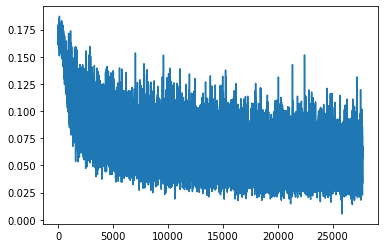

------
*********
29673 3218
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.17193324863910675
Loss:  0.16839982569217682
Loss:  0.15577776730060577
0 **********
Epoch:  76.71687293052673  fold:  5  kers:  128
epoch:  1
29673 464
Loss:  0.14999152719974518
Loss:  0.13915526866912842
Loss:  0.1270810216665268
1 **********
Epoch:  141.1645531654358  fold:  5  kers:  128
epoch:  2
29673 464
Loss:  0.12605085968971252
Loss:  0.1122189462184906
Loss:  0.10449987649917603
2 **********
Epoch:  205.59228658676147  fold:  5  kers:  128
epoch:  3
Eval Loss:  0.17413640022277832
Eval Loss:  0.33513978123664856
Eval Loss:  0.2569580674171448
[[2823  274]
 [  47   74]]
              pre

Loss:  0.08173689246177673
Loss:  0.06718982756137848
10 **********
Epoch:  844.7134065628052  fold:  5  kers:  128
epoch:  11
29673 464
Loss:  0.05970942601561546
Loss:  0.10137597471475601
Loss:  0.10746455192565918
11 **********
Epoch:  909.1640787124634  fold:  5  kers:  128
epoch:  12
Eval Loss:  0.07395321130752563
Eval Loss:  0.11983022093772888
Eval Loss:  0.05187072977423668
[[3061   36]
 [  47   74]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3097
           1       0.67      0.61      0.64       121

    accuracy                           0.97      3218
   macro avg       0.83      0.80      0.81      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.9742075823492853
pre:  0.6727272727272727
rec:  0.6115702479338843
ma F1:  0.81365816563238
mi F1:  0.9742075823492853
we F1:  0.973616339100579
update!  Acc:  0.9742075823492853
Eval Loss:  0.413000226020813
Eval Loss:  0.30359864234924316
Eval Loss:

Eval Loss:  0.3015015125274658
Eval Loss:  0.21197518706321716
Eval Loss:  0.2547149658203125
Eval Loss:  0.18011148273944855
Eval Loss:  0.3613913655281067
Eval Loss:  0.25128236413002014
Eval Loss:  0.29257047176361084
Eval Loss:  0.17667868733406067
Eval Loss:  0.2979525029659271
Eval Loss:  0.2946125566959381
Eval Loss:  0.32435527443885803
Eval Loss:  0.3236149847507477
Eval Loss:  0.18852193653583527
Eval Loss:  0.3474869728088379
Eval Loss:  0.16864317655563354
Eval Loss:  0.30180835723876953
Eval Loss:  0.2747001647949219
Eval Loss:  0.23944257199764252
Eval Loss:  0.2943688929080963
Eval Loss:  0.24643710255622864
Eval Loss:  0.2120523899793625
Eval Loss:  0.2726016938686371
Eval Loss:  0.23733894526958466
Eval Loss:  0.19697214663028717
Eval Loss:  0.2844790518283844
Eval Loss:  0.21775321662425995
Eval Loss:  0.35661765933036804
Eval Loss:  0.37585312128067017
Eval Loss:  0.2796497046947479
[[16233   834]
 [ 2260 10346]]
              precision    recall  f1-score   support


Eval Loss:  0.18592862784862518
Eval Loss:  0.22291390597820282
Eval Loss:  0.20122838020324707
Eval Loss:  0.17513763904571533
Eval Loss:  0.2656715512275696
Eval Loss:  0.19572769105434418
Eval Loss:  0.30303263664245605
Eval Loss:  0.3049125671386719
Eval Loss:  0.2630602717399597
[[16209   858]
 [ 1888 10718]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     17067
           1       0.93      0.85      0.89     12606

    accuracy                           0.91     29673
   macro avg       0.91      0.90      0.90     29673
weighted avg       0.91      0.91      0.91     29673

acc:  0.9074579584133724
pre:  0.9258811333794057
rec:  0.8502300491829288
ma F1:  0.9041766165784417
mi F1:  0.9074579584133724
we F1:  0.9068424453756783
29673 464
Loss:  0.08466839045286179
Loss:  0.062414802610874176
Loss:  0.06834473460912704
30 **********
Epoch:  2417.655678510666  fold:  5  kers:  128
epoch:  31
29673 464
Loss:  0.08519969880580902

Loss:  0.02750796265900135
Loss:  0.03304331749677658
Loss:  0.054711975157260895
39 **********
Epoch:  3119.101155757904  fold:  5  kers:  128
epoch:  40
29673 464
Loss:  0.03164683282375336
Loss:  0.07856515049934387
Loss:  0.03206290677189827
40 **********
Epoch:  3183.5129318237305  fold:  5  kers:  128
epoch:  41
29673 464
Loss:  0.07189290225505829
Loss:  0.07014140486717224
Loss:  0.0905839055776596
41 **********
Epoch:  3247.956622362137  fold:  5  kers:  128
epoch:  42
Eval Loss:  0.06251661479473114
Eval Loss:  0.0681745782494545
Eval Loss:  0.026620477437973022
[[3070   27]
 [  36   85]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.76      0.70      0.73       121

    accuracy                           0.98      3218
   macro avg       0.87      0.85      0.86      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9804226227470478
pre:  0.7589285714285714
rec:  0.702479338

Eval Loss:  0.18181930482387543
Eval Loss:  0.14845669269561768
Eval Loss:  0.2004585713148117
Eval Loss:  0.18464921414852142
Eval Loss:  0.2840721607208252
Eval Loss:  0.21916525065898895
Eval Loss:  0.22726622223854065
Eval Loss:  0.16301816701889038
Eval Loss:  0.2647612988948822
Eval Loss:  0.21024726331233978
Eval Loss:  0.24213461577892303
Eval Loss:  0.2572278082370758
Eval Loss:  0.1687338948249817
Eval Loss:  0.2647148370742798
Eval Loss:  0.1251736730337143
Eval Loss:  0.24926690757274628
Eval Loss:  0.1927228718996048
Eval Loss:  0.21175584197044373
Eval Loss:  0.21750381588935852
Eval Loss:  0.20924139022827148
Eval Loss:  0.2024998813867569
Eval Loss:  0.18235090374946594
Eval Loss:  0.15236355364322662
Eval Loss:  0.18459178507328033
Eval Loss:  0.26476621627807617
Eval Loss:  0.16280212998390198
Eval Loss:  0.20222459733486176
Eval Loss:  0.20091846585273743
Eval Loss:  0.28973525762557983
[[15455  1612]
 [  887 11719]]
              precision    recall  f1-score   supp

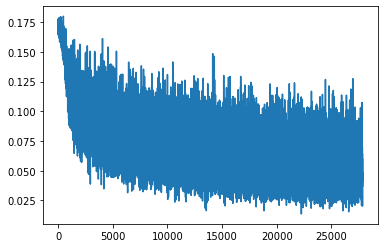

------
*********
29479 3412
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.17526808381080627
Loss:  0.16993491351604462
Loss:  0.1663074940443039
0 **********
Epoch:  76.27904462814331  fold:  6  kers:  128
epoch:  1
29479 461
Loss:  0.15217281877994537
Loss:  0.13495968282222748
Loss:  0.12704148888587952
1 **********
Epoch:  140.28291177749634  fold:  6  kers:  128
epoch:  2
29479 461
Loss:  0.12383060902357101
Loss:  0.0897487998008728
Loss:  0.11265639960765839
2 **********
Epoch:  204.29475712776184  fold:  6  kers:  128
epoch:  3
Eval Loss:  0.08789549767971039
Eval Loss:  0.349578857421875
Eval Loss:  0.537849485874176
[[1956  276]
 [ 170 1010]]
              preci

Loss:  0.0850410908460617
Loss:  0.08428148180246353
Loss:  0.08667405694723129
11 **********
Epoch:  902.7392582893372  fold:  6  kers:  128
epoch:  12
Eval Loss:  0.01746399700641632
Eval Loss:  0.4005921185016632
Eval Loss:  0.5001878142356873
[[2153   79]
 [ 307  873]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2232
           1       0.92      0.74      0.82      1180

    accuracy                           0.89      3412
   macro avg       0.90      0.85      0.87      3412
weighted avg       0.89      0.89      0.88      3412

acc:  0.8868698710433763
pre:  0.917016806722689
rec:  0.7398305084745763
ma F1:  0.868340826827509
mi F1:  0.8868698710433763
we F1:  0.883569385042425
Eval Loss:  0.2961011230945587
Eval Loss:  0.34039589762687683
Eval Loss:  0.33889469504356384
Eval Loss:  0.29586705565452576
Eval Loss:  0.32058706879615784
Eval Loss:  0.3122844099998474
Eval Loss:  0.4227195382118225
Eval Loss:  0.37803637981

Eval Loss:  0.1725078970193863
Eval Loss:  0.2852817177772522
Eval Loss:  0.21703974902629852
Eval Loss:  0.2048490345478058
Eval Loss:  0.2182348519563675
Eval Loss:  0.21970191597938538
Eval Loss:  0.3503205478191376
Eval Loss:  0.25533953309059143
Eval Loss:  0.24194881319999695
Eval Loss:  0.24141404032707214
Eval Loss:  0.22573058307170868
Eval Loss:  0.18441633880138397
Eval Loss:  0.24007868766784668
Eval Loss:  0.24194638431072235
Eval Loss:  0.2500663101673126
Eval Loss:  0.16172513365745544
Eval Loss:  0.22376136481761932
Eval Loss:  0.2684869170188904
Eval Loss:  0.19603687524795532
Eval Loss:  0.3466828167438507
Eval Loss:  0.16596265137195587
Eval Loss:  0.22043335437774658
Eval Loss:  0.2620408535003662
Eval Loss:  0.19745992124080658
Eval Loss:  0.24259315431118011
Eval Loss:  0.24295449256896973
Eval Loss:  0.21893393993377686
Eval Loss:  0.19639991223812103
[[16906  1026]
 [ 1669  9878]]
              precision    recall  f1-score   support

           0       0.91    

Eval Loss:  0.2296609878540039
Eval Loss:  0.16799145936965942
Eval Loss:  0.23977452516555786
Eval Loss:  0.23580732941627502
Eval Loss:  0.2056625485420227
Eval Loss:  0.17072516679763794
[[17047   885]
 [ 1523 10024]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     17932
           1       0.92      0.87      0.89     11547

    accuracy                           0.92     29479
   macro avg       0.92      0.91      0.91     29479
weighted avg       0.92      0.92      0.92     29479

acc:  0.9183147325214559
pre:  0.9188743239526996
rec:  0.8681042695072313
ma F1:  0.9133995458999207
mi F1:  0.9183147325214559
we F1:  0.9178682154967459
29479 461
Loss:  0.04661322757601738
Loss:  0.06590992957353592
Loss:  0.050612710416316986
30 **********
Epoch:  2402.627861022949  fold:  6  kers:  128
epoch:  31
29479 461
Loss:  0.04607420414686203
Loss:  0.07369258254766464
Loss:  0.08603904396295547
31 **********
Epoch:  2466.634719848633 

Loss:  0.048577167093753815
Loss:  0.06361685693264008
Loss:  0.06090996041893959
39 **********
Epoch:  3102.7977492809296  fold:  6  kers:  128
epoch:  40
29479 461
Loss:  0.0782904103398323
Loss:  0.035481907427310944
Loss:  0.04217958077788353
40 **********
Epoch:  3166.7916424274445  fold:  6  kers:  128
epoch:  41
29479 461
Loss:  0.07916194945573807
Loss:  0.05003281682729721
Loss:  0.10277433693408966
41 **********
Epoch:  3231.482671737671  fold:  6  kers:  128
epoch:  42
Eval Loss:  0.01121016126126051
Eval Loss:  0.3998183608055115
Eval Loss:  0.34993240237236023
[[2107  125]
 [ 328  852]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      2232
           1       0.87      0.72      0.79      1180

    accuracy                           0.87      3412
   macro avg       0.87      0.83      0.85      3412
weighted avg       0.87      0.87      0.86      3412

acc:  0.8672332942555686
pre:  0.872057318321392
rec:  0.722033898

Eval Loss:  0.15211252868175507
Eval Loss:  0.215500608086586
Eval Loss:  0.14208458364009857
Eval Loss:  0.1832229346036911
Eval Loss:  0.1233748272061348
Eval Loss:  0.15541361272335052
Eval Loss:  0.3063914477825165
Eval Loss:  0.2203393429517746
Eval Loss:  0.17524345219135284
Eval Loss:  0.20599031448364258
Eval Loss:  0.17555026710033417
Eval Loss:  0.15466992557048798
Eval Loss:  0.1791786253452301
Eval Loss:  0.17414799332618713
Eval Loss:  0.20571209490299225
Eval Loss:  0.1320495903491974
Eval Loss:  0.20074176788330078
Eval Loss:  0.18970656394958496
Eval Loss:  0.15648746490478516
Eval Loss:  0.19786636531352997
Eval Loss:  0.1644497513771057
Eval Loss:  0.115165576338768
Eval Loss:  0.16620729863643646
Eval Loss:  0.1113506406545639
Eval Loss:  0.21855975687503815
Eval Loss:  0.20785900950431824
Eval Loss:  0.13968463242053986
Eval Loss:  0.13919256627559662
[[16977   955]
 [ 1021 10526]]
              precision    recall  f1-score   support

           0       0.94      0

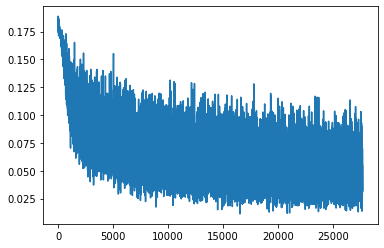

------
*********
29460 3431
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1598127782344818
Loss:  0.166143998503685
Loss:  0.14079909026622772
0 **********
Epoch:  76.27704954147339  fold:  7  kers:  128
epoch:  1
29460 461
Loss:  0.11716792732477188
Loss:  0.125512033700943
Loss:  0.10314831137657166
1 **********
Epoch:  140.27193927764893  fold:  7  kers:  128
epoch:  2
29460 461
Loss:  0.11303666979074478
Loss:  0.10773240029811859
Loss:  0.10096018761396408
2 **********
Epoch:  204.25685715675354  fold:  7  kers:  128
epoch:  3
Eval Loss:  0.7623918652534485
Eval Loss:  0.1061565950512886
Eval Loss:  2.2451934814453125
[[1765  362]
 [ 742  562]]
              precisi

Loss:  0.10569347441196442
Loss:  0.12674660980701447
Loss:  0.0853014886379242
11 **********
Epoch:  902.2385954856873  fold:  7  kers:  128
epoch:  12
Eval Loss:  0.8700850009918213
Eval Loss:  0.07921487838029861
Eval Loss:  2.8885622024536133
[[2055   72]
 [ 872  432]]
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      2127
           1       0.86      0.33      0.48      1304

    accuracy                           0.72      3431
   macro avg       0.78      0.65      0.65      3431
weighted avg       0.76      0.72      0.69      3431

acc:  0.7248615563975518
pre:  0.8571428571428571
rec:  0.3312883435582822
ma F1:  0.6455466799275786
mi F1:  0.7248615563975518
we F1:  0.6857661151307751
update!  Acc:  0.7248615563975518
Eval Loss:  0.218893364071846
Eval Loss:  0.26830703020095825
Eval Loss:  0.3462619185447693
Eval Loss:  0.385257363319397
Eval Loss:  0.39027127623558044
Eval Loss:  0.37490081787109375
Eval Loss:  0.33097657

Eval Loss:  0.18713271617889404
Eval Loss:  0.21794117987155914
Eval Loss:  0.2880302965641022
Eval Loss:  0.32317519187927246
Eval Loss:  0.26643994450569153
Eval Loss:  0.26051759719848633
Eval Loss:  0.27307841181755066
Eval Loss:  0.25025784969329834
Eval Loss:  0.251675009727478
Eval Loss:  0.305083304643631
Eval Loss:  0.26188942790031433
Eval Loss:  0.1582472175359726
Eval Loss:  0.20901060104370117
Eval Loss:  0.24306830763816833
Eval Loss:  0.1952681839466095
Eval Loss:  0.2787429690361023
Eval Loss:  0.265910267829895
Eval Loss:  0.2767079174518585
Eval Loss:  0.3440318703651428
Eval Loss:  0.19410771131515503
Eval Loss:  0.24498765170574188
Eval Loss:  0.21771471202373505
Eval Loss:  0.24429821968078613
Eval Loss:  0.24574105441570282
Eval Loss:  0.30080607533454895
Eval Loss:  0.25711920857429504
Eval Loss:  0.2612778842449188
Eval Loss:  0.238234281539917
[[17251   786]
 [ 2321  9102]]
              precision    recall  f1-score   support

           0       0.88      0.96

Eval Loss:  0.20978456735610962
Eval Loss:  0.22173894941806793
Eval Loss:  0.30960631370544434
Eval Loss:  0.23697622120380402
Eval Loss:  0.2158794105052948
Eval Loss:  0.2350885421037674
[[17435   602]
 [ 2088  9335]]
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     18037
           1       0.94      0.82      0.87     11423

    accuracy                           0.91     29460
   macro avg       0.92      0.89      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9086897488119484
pre:  0.9394183355137365
rec:  0.8172108903090256
ma F1:  0.901222463534001
mi F1:  0.9086897488119484
we F1:  0.90731982462392
29460 461
Loss:  0.05314098671078682
Loss:  0.060987770557403564
Loss:  0.05728716775774956
30 **********
Epoch:  2410.541699409485  fold:  7  kers:  128
epoch:  31
29460 461
Loss:  0.07632141560316086
Loss:  0.03800278902053833
Loss:  0.03391553461551666
31 **********
Epoch:  2474.5296092033386  f

Loss:  0.04763055592775345
Loss:  0.05922438204288483
Loss:  0.08354128152132034
39 **********
Epoch:  3108.2551555633545  fold:  7  kers:  128
epoch:  40
29460 461
Loss:  0.04229765385389328
Loss:  0.03836986422538757
Loss:  0.04113287106156349
40 **********
Epoch:  3172.2101531028748  fold:  7  kers:  128
epoch:  41
29460 461
Loss:  0.039230044931173325
Loss:  0.04573323577642441
Loss:  0.05738668888807297
41 **********
Epoch:  3236.2269854545593  fold:  7  kers:  128
epoch:  42
Eval Loss:  0.4883013367652893
Eval Loss:  0.06991250813007355
Eval Loss:  1.6879584789276123
[[1925  202]
 [ 557  747]]
              precision    recall  f1-score   support

           0       0.78      0.91      0.84      2127
           1       0.79      0.57      0.66      1304

    accuracy                           0.78      3431
   macro avg       0.78      0.74      0.75      3431
weighted avg       0.78      0.78      0.77      3431

acc:  0.7787816962984553
pre:  0.7871443624868283
rec:  0.57285276

Eval Loss:  0.18644990026950836
Eval Loss:  0.13376955687999725
Eval Loss:  0.16618867218494415
Eval Loss:  0.19652420282363892
Eval Loss:  0.17594371736049652
Eval Loss:  0.17112423479557037
Eval Loss:  0.2049275040626526
Eval Loss:  0.15376946330070496
Eval Loss:  0.19136007130146027
Eval Loss:  0.21389231085777283
Eval Loss:  0.23096783459186554
Eval Loss:  0.07130606472492218
Eval Loss:  0.1276371330022812
Eval Loss:  0.17611254751682281
Eval Loss:  0.12856197357177734
Eval Loss:  0.21092258393764496
Eval Loss:  0.16478502750396729
Eval Loss:  0.1955891102552414
Eval Loss:  0.19293303787708282
Eval Loss:  0.12338344007730484
Eval Loss:  0.17577731609344482
Eval Loss:  0.16709715127944946
Eval Loss:  0.1365225911140442
Eval Loss:  0.18770819902420044
Eval Loss:  0.265922486782074
Eval Loss:  0.22960226237773895
Eval Loss:  0.20564717054367065
Eval Loss:  0.21971331536769867
[[17066   971]
 [ 1092 10331]]
              precision    recall  f1-score   support

           0       0.94 

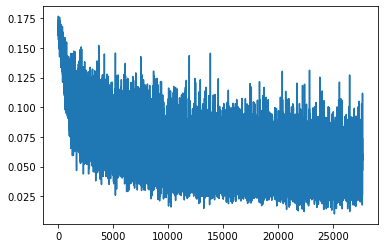

------
*********
29817 3074
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.17357991635799408
Loss:  0.1690523624420166
Loss:  0.16156317293643951
0 **********
Epoch:  76.99612712860107  fold:  8  kers:  128
epoch:  1
29817 466
Loss:  0.13335853815078735
Loss:  0.13532036542892456
Loss:  0.11473546177148819
1 **********
Epoch:  141.70311427116394  fold:  8  kers:  128
epoch:  2
29817 466
Loss:  0.11940255761146545
Loss:  0.13735900819301605
Loss:  0.08844121545553207
2 **********
Epoch:  206.43802618980408  fold:  8  kers:  128
epoch:  3
Eval Loss:  0.2749529480934143
Eval Loss:  1.2585328817367554
Eval Loss:  0.21518754959106445
[[1942  131]
 [ 468  533]]
              pr

10 **********
Epoch:  846.2562825679779  fold:  8  kers:  128
epoch:  11
29817 466
Loss:  0.06566675752401352
Loss:  0.06462997943162918
Loss:  0.061472877860069275
11 **********
Epoch:  910.9503030776978  fold:  8  kers:  128
epoch:  12
Eval Loss:  0.45851564407348633
Eval Loss:  1.183899998664856
Eval Loss:  0.09725630283355713
[[1808  265]
 [ 327  674]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      2073
           1       0.72      0.67      0.69      1001

    accuracy                           0.81      3074
   macro avg       0.78      0.77      0.78      3074
weighted avg       0.80      0.81      0.81      3074

acc:  0.8074170461938842
pre:  0.7177848775292864
rec:  0.6733266733266733
ma F1:  0.7770804750891772
mi F1:  0.8074170461938842
we F1:  0.8057584329588826
update!  Acc:  0.8074170461938842
Eval Loss:  0.2811231017112732
Eval Loss:  0.2891029119491577
Eval Loss:  0.19124296307563782
Eval Loss:  0.2837361991405487

Eval Loss:  0.2486199587583542
Eval Loss:  0.2615422010421753
Eval Loss:  0.19165101647377014
Eval Loss:  0.28423169255256653
Eval Loss:  0.2242506593465805
Eval Loss:  0.2099391669034958
Eval Loss:  0.4013957381248474
Eval Loss:  0.2533869445323944
Eval Loss:  0.2612273395061493
Eval Loss:  0.1384049504995346
Eval Loss:  0.18654519319534302
Eval Loss:  0.15472859144210815
Eval Loss:  0.20518901944160461
Eval Loss:  0.2080354541540146
Eval Loss:  0.2773701548576355
Eval Loss:  0.2714720070362091
Eval Loss:  0.2734019160270691
Eval Loss:  0.27521052956581116
Eval Loss:  0.2449013888835907
Eval Loss:  0.22504185140132904
Eval Loss:  0.2287084311246872
Eval Loss:  0.1958364099264145
Eval Loss:  0.2613665759563446
Eval Loss:  0.2835976779460907
Eval Loss:  0.2925770878791809
Eval Loss:  0.3182257115840912
Eval Loss:  0.18574027717113495
Eval Loss:  0.24257467687129974
Eval Loss:  0.23333166539669037
[[17240   851]
 [ 1979  9747]]
              precision    recall  f1-score   support

     

Eval Loss:  0.19466298818588257
Eval Loss:  0.18666602671146393
Eval Loss:  0.25891655683517456
Eval Loss:  0.2556535303592682
Eval Loss:  0.286664754152298
Eval Loss:  0.304058313369751
Eval Loss:  0.1832418292760849
Eval Loss:  0.18796373903751373
Eval Loss:  0.19982050359249115
[[16925  1166]
 [ 1294 10432]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     18091
           1       0.90      0.89      0.89     11726

    accuracy                           0.92     29817
   macro avg       0.91      0.91      0.91     29817
weighted avg       0.92      0.92      0.92     29817

acc:  0.9174967300533253
pre:  0.8994654250732885
rec:  0.8896469384274263
ma F1:  0.9133896545595459
mi F1:  0.9174967300533253
we F1:  0.9174157650659229
29817 466
Loss:  0.06447361409664154
Loss:  0.04802536964416504
Loss:  0.052225593477487564
30 **********
Epoch:  2429.056197166443  fold:  8  kers:  128
epoch:  31
29817 466
Loss:  0.037091467529535294
L

Loss:  0.05463530868291855
Loss:  0.05374586954712868
Loss:  0.04796651378273964
39 **********
Epoch:  3133.10670876503  fold:  8  kers:  128
epoch:  40
29817 466
Loss:  0.06912802159786224
Loss:  0.05130791664123535
Loss:  0.049344029277563095
40 **********
Epoch:  3197.7987356185913  fold:  8  kers:  128
epoch:  41
29817 466
Loss:  0.03472018241882324
Loss:  0.03551380708813667
Loss:  0.06883534044027328
41 **********
Epoch:  3262.5127034187317  fold:  8  kers:  128
epoch:  42
Eval Loss:  0.33863717317581177
Eval Loss:  1.0416158437728882
Eval Loss:  0.16772982478141785
[[1850  223]
 [ 237  764]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2073
           1       0.77      0.76      0.77      1001

    accuracy                           0.85      3074
   macro avg       0.83      0.83      0.83      3074
weighted avg       0.85      0.85      0.85      3074

acc:  0.8503578399479506
pre:  0.7740628166160081
rec:  0.763236763

Eval Loss:  0.2095964252948761
Eval Loss:  0.1523258090019226
Eval Loss:  0.1345590502023697
Eval Loss:  0.15871752798557281
Eval Loss:  0.1721050888299942
Eval Loss:  0.13888442516326904
Eval Loss:  0.2664013206958771
Eval Loss:  0.18541058897972107
Eval Loss:  0.2011939287185669
Eval Loss:  0.08791717886924744
Eval Loss:  0.11516319960355759
Eval Loss:  0.11605022847652435
Eval Loss:  0.14247137308120728
Eval Loss:  0.18543069064617157
Eval Loss:  0.20843783020973206
Eval Loss:  0.23654384911060333
Eval Loss:  0.1777430921792984
Eval Loss:  0.18237781524658203
Eval Loss:  0.13723234832286835
Eval Loss:  0.19491344690322876
Eval Loss:  0.17691433429718018
Eval Loss:  0.1573970913887024
Eval Loss:  0.23569339513778687
Eval Loss:  0.22905439138412476
Eval Loss:  0.26300621032714844
Eval Loss:  0.22894327342510223
Eval Loss:  0.12617681920528412
Eval Loss:  0.16190584003925323
Eval Loss:  0.15624044835567474
[[17219   872]
 [ 1161 10565]]
              precision    recall  f1-score   sup

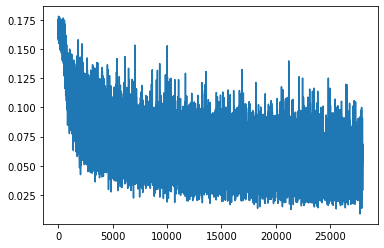

------
*********
29483 3408
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.16943377256393433
Loss:  0.1660066694021225
Loss:  0.16152676939964294
0 **********
Epoch:  76.55829858779907  fold:  9  kers:  128
epoch:  1
29483 461
Loss:  0.142887145280838
Loss:  0.14057298004627228
Loss:  0.11905819177627563
1 **********
Epoch:  140.6319785118103  fold:  9  kers:  128
epoch:  2
29483 461
Loss:  0.11580859124660492
Loss:  0.08949781954288483
Loss:  0.08897080272436142
2 **********
Epoch:  204.69967436790466  fold:  9  kers:  128
epoch:  3
Eval Loss:  0.13891984522342682
Eval Loss:  1.6975901126861572
Eval Loss:  0.4107292592525482
[[1687   55]
 [ 735  931]]
              preci

Loss:  0.08203773945569992
Loss:  0.043431926518678665
Loss:  0.07174260914325714
11 **********
Epoch:  906.6597757339478  fold:  9  kers:  128
epoch:  12
Eval Loss:  0.03192386031150818
Eval Loss:  1.5653278827667236
Eval Loss:  0.17652025818824768
[[1673   69]
 [ 524 1142]]
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1742
           1       0.94      0.69      0.79      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.82      0.82      3408
weighted avg       0.85      0.83      0.82      3408

acc:  0.8259976525821596
pre:  0.9430222956234517
rec:  0.6854741896758704
ma F1:  0.8216683463485516
mi F1:  0.8259976525821596
we F1:  0.8222879833989362
Eval Loss:  0.2549266517162323
Eval Loss:  0.2934446632862091
Eval Loss:  0.2695412337779999
Eval Loss:  0.3002074360847473
Eval Loss:  0.29518789052963257
Eval Loss:  0.19676096737384796
Eval Loss:  0.3352024257183075
Eval Loss:  0.3182010

Eval Loss:  0.21907414495944977
Eval Loss:  0.32605108618736267
Eval Loss:  0.2569080591201782
Eval Loss:  0.2458471804857254
Eval Loss:  0.29949238896369934
Eval Loss:  0.19929558038711548
Eval Loss:  0.30718255043029785
Eval Loss:  0.2820676565170288
Eval Loss:  0.22558429837226868
Eval Loss:  0.20359273254871368
Eval Loss:  0.2662098705768585
Eval Loss:  0.24161158502101898
Eval Loss:  0.27900999784469604
Eval Loss:  0.3050778806209564
Eval Loss:  0.24812275171279907
Eval Loss:  0.27915942668914795
Eval Loss:  0.28807589411735535
Eval Loss:  0.15601198375225067
Eval Loss:  0.28870320320129395
Eval Loss:  0.33206820487976074
Eval Loss:  0.2262459695339203
Eval Loss:  0.2635313868522644
Eval Loss:  0.2844427525997162
Eval Loss:  0.24221384525299072
Eval Loss:  0.23808026313781738
Eval Loss:  0.189759761095047
Eval Loss:  0.2476571947336197
Eval Loss:  0.24435396492481232
[[17579   843]
 [ 2037  9024]]
              precision    recall  f1-score   support

           0       0.90      

Eval Loss:  0.19366797804832458
Eval Loss:  0.22941343486309052
Eval Loss:  0.2508118450641632
Eval Loss:  0.19303347170352936
Eval Loss:  0.1856437772512436
Eval Loss:  0.24044208228588104
[[17146  1276]
 [ 1271  9790]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     18422
           1       0.88      0.89      0.88     11061

    accuracy                           0.91     29483
   macro avg       0.91      0.91      0.91     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.9136112335922396
pre:  0.8846918489065606
rec:  0.885091763854986
ma F1:  0.9078765383252294
mi F1:  0.9136112335922396
we F1:  0.9136151315634652
29483 461
Loss:  0.0888543576002121
Loss:  0.031193504109978676
Loss:  0.04660283401608467
30 **********
Epoch:  2406.3259727954865  fold:  9  kers:  128
epoch:  31
29483 461
Loss:  0.05236601456999779
Loss:  0.052044641226530075
Loss:  0.044394075870513916
31 **********
Epoch:  2470.308895826339

Loss:  0.05041512846946716
Loss:  0.0801820307970047
Loss:  0.04211961477994919
39 **********
Epoch:  3103.063039779663  fold:  9  kers:  128
epoch:  40
29483 461
Loss:  0.06073673069477081
Loss:  0.04753459617495537
Loss:  0.03950561210513115
40 **********
Epoch:  3167.050949573517  fold:  9  kers:  128
epoch:  41
29483 461
Loss:  0.06670042127370834
Loss:  0.06951852142810822
Loss:  0.06618986278772354
41 **********
Epoch:  3231.0398557186127  fold:  9  kers:  128
epoch:  42
Eval Loss:  0.03906554356217384
Eval Loss:  0.7135860919952393
Eval Loss:  0.10708518326282501
[[1624  118]
 [ 291 1375]]
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1742
           1       0.92      0.83      0.87      1666

    accuracy                           0.88      3408
   macro avg       0.88      0.88      0.88      3408
weighted avg       0.88      0.88      0.88      3408

acc:  0.8799882629107981
pre:  0.9209645010046885
rec:  0.82533013205

Eval Loss:  0.15407831966876984
Eval Loss:  0.23598304390907288
Eval Loss:  0.18327076733112335
Eval Loss:  0.20498619973659515
Eval Loss:  0.1298028528690338
Eval Loss:  0.1210581585764885
Eval Loss:  0.20474117994308472
Eval Loss:  0.262959361076355
Eval Loss:  0.13604991137981415
Eval Loss:  0.16523367166519165
Eval Loss:  0.2014676183462143
Eval Loss:  0.19637148082256317
Eval Loss:  0.16848301887512207
Eval Loss:  0.1890798807144165
Eval Loss:  0.18448542058467865
Eval Loss:  0.22371050715446472
Eval Loss:  0.2542661428451538
Eval Loss:  0.11250535398721695
Eval Loss:  0.19609162211418152
Eval Loss:  0.20616517961025238
Eval Loss:  0.1109379455447197
Eval Loss:  0.1850864738225937
Eval Loss:  0.15826798975467682
Eval Loss:  0.1815098524093628
Eval Loss:  0.1999617964029312
Eval Loss:  0.16141894459724426
Eval Loss:  0.13801196217536926
Eval Loss:  0.1755063682794571
[[17279  1143]
 [  940 10121]]
              precision    recall  f1-score   support

           0       0.95      0

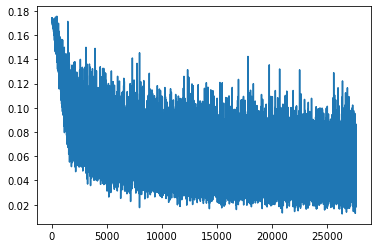

------
*********
29871 3020
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.16151387989521027
Loss:  0.16307708621025085
Loss:  0.1584235429763794
0 **********
Epoch:  77.13276171684265  fold:  10  kers:  128
epoch:  1
29871 467
Loss:  0.13205166161060333
Loss:  0.14194457232952118
Loss:  0.10992828756570816
1 **********
Epoch:  141.88861751556396  fold:  10  kers:  128
epoch:  2
29871 467
Loss:  0.09968262165784836
Loss:  0.09995222091674805
Loss:  0.09817878156900406
2 **********
Epoch:  206.69134879112244  fold:  10  kers:  128
epoch:  3
Eval Loss:  0.6240761876106262
Eval Loss:  0.18118326365947723
Eval Loss:  0.11085242033004761
[[1629  122]
 [ 248 1021]]
            

Loss:  0.03629384562373161
Loss:  0.0717613622546196
10 **********
Epoch:  846.0358710289001  fold:  10  kers:  128
epoch:  11
29871 467
Loss:  0.07414643466472626
Loss:  0.09127958118915558
Loss:  0.07721976190805435
11 **********
Epoch:  910.8176579475403  fold:  10  kers:  128
epoch:  12
Eval Loss:  0.370883584022522
Eval Loss:  0.13861367106437683
Eval Loss:  0.09445025771856308
[[1658   93]
 [ 184 1085]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      1751
           1       0.92      0.86      0.89      1269

    accuracy                           0.91      3020
   macro avg       0.91      0.90      0.90      3020
weighted avg       0.91      0.91      0.91      3020

acc:  0.9082781456953642
pre:  0.9210526315789473
rec:  0.8550039401103231
ma F1:  0.9048529066701121
mi F1:  0.9082781456953642
we F1:  0.9077341723074098
update!  Acc:  0.9082781456953642
Eval Loss:  0.2665427327156067
Eval Loss:  0.307134747505188
Eval Loss

Eval Loss:  0.2327645719051361
Eval Loss:  0.29109254479408264
Eval Loss:  0.21382150053977966
Eval Loss:  0.26230716705322266
Eval Loss:  0.2918463945388794
Eval Loss:  0.2580263614654541
Eval Loss:  0.2864365875720978
Eval Loss:  0.25261157751083374
Eval Loss:  0.191537007689476
Eval Loss:  0.24639186263084412
Eval Loss:  0.17318518459796906
Eval Loss:  0.2658917009830475
Eval Loss:  0.27592217922210693
Eval Loss:  0.3190288841724396
Eval Loss:  0.257266104221344
Eval Loss:  0.20525863766670227
Eval Loss:  0.18832625448703766
Eval Loss:  0.2255999594926834
Eval Loss:  0.18597055971622467
Eval Loss:  0.26831889152526855
Eval Loss:  0.24788743257522583
Eval Loss:  0.15314359962940216
Eval Loss:  0.2656340003013611
Eval Loss:  0.2390572875738144
Eval Loss:  0.2101363241672516
Eval Loss:  0.19437673687934875
Eval Loss:  0.26876088976860046
Eval Loss:  0.2745005488395691
Eval Loss:  0.3008022904396057
[[17298  1115]
 [ 1890  9568]]
              precision    recall  f1-score   support

  

Eval Loss:  0.17265306413173676
Eval Loss:  0.29955995082855225
Eval Loss:  0.23144571483135223
Eval Loss:  0.13579323887825012
Eval Loss:  0.22026672959327698
Eval Loss:  0.20737791061401367
Eval Loss:  0.1994466334581375
Eval Loss:  0.21465498208999634
Eval Loss:  0.2314884513616562
Eval Loss:  0.2817070484161377
Eval Loss:  0.2945842146873474
[[17566   847]
 [ 1912  9546]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.93     18413
           1       0.92      0.83      0.87     11458

    accuracy                           0.91     29871
   macro avg       0.91      0.89      0.90     29871
weighted avg       0.91      0.91      0.91     29871

acc:  0.9076361688594289
pre:  0.9185028384489561
rec:  0.8331296910455577
ma F1:  0.9004608155372308
mi F1:  0.9076361688594289
we F1:  0.9066833320404587
29871 467
Loss:  0.076591357588768
Loss:  0.08323199301958084
Loss:  0.05513853207230568
30 **********
Epoch:  2424.2610177993774  fold:  

Loss:  0.0548289529979229
Loss:  0.03523977845907211
Loss:  0.06517305970191956
39 **********
Epoch:  3135.0245809555054  fold:  10  kers:  128
epoch:  40
29871 467
Loss:  0.029948534443974495
Loss:  0.0538984015583992
Loss:  0.03769655525684357
40 **********
Epoch:  3199.8173377513885  fold:  10  kers:  128
epoch:  41
29871 467
Loss:  0.04227086529135704
Loss:  0.07448026537895203
Loss:  0.06774593144655228
41 **********
Epoch:  3264.641012430191  fold:  10  kers:  128
epoch:  42
Eval Loss:  0.8142138123512268
Eval Loss:  0.08793218433856964
Eval Loss:  0.0110537800937891
[[1651  100]
 [ 219 1050]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1751
           1       0.91      0.83      0.87      1269

    accuracy                           0.89      3020
   macro avg       0.90      0.89      0.89      3020
weighted avg       0.90      0.89      0.89      3020

acc:  0.8943708609271523
pre:  0.9130434782608695
rec:  0.82742316

Eval Loss:  0.21519488096237183
Eval Loss:  0.25275832414627075
Eval Loss:  0.14009331166744232
Eval Loss:  0.20060564577579498
Eval Loss:  0.20204229652881622
Eval Loss:  0.1413733959197998
Eval Loss:  0.26089414954185486
Eval Loss:  0.19810354709625244
Eval Loss:  0.09436539560556412
Eval Loss:  0.15687867999076843
Eval Loss:  0.15752477943897247
Eval Loss:  0.16749057173728943
Eval Loss:  0.21142499148845673
Eval Loss:  0.2151915580034256
Eval Loss:  0.22920632362365723
Eval Loss:  0.11392942816019058
Eval Loss:  0.14684346318244934
Eval Loss:  0.23093949258327484
Eval Loss:  0.13100233674049377
Eval Loss:  0.20592449605464935
Eval Loss:  0.1908511221408844
Eval Loss:  0.13432374596595764
Eval Loss:  0.19416813552379608
Eval Loss:  0.15242725610733032
Eval Loss:  0.15832656621932983
Eval Loss:  0.19194921851158142
Eval Loss:  0.20135624706745148
Eval Loss:  0.19883908331394196
Eval Loss:  0.17224642634391785
[[16904  1509]
 [  821 10637]]
              precision    recall  f1-score 

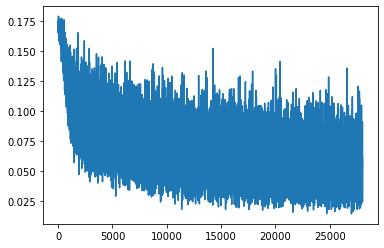

------
  
kernel: 64
  
*********
29459 3432
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.16173821687698364
Loss:  0.1553047150373459
Loss:  0.14934709668159485
0 **********
Epoch:  56.41715216636658  fold:  1  kers:  64
epoch:  1
29459 461
Loss:  0.15264514088630676
Loss:  0.10652964562177658
Loss:  0.11666331440210342
1 **********
Epoch:  100.5262131690979  fold:  1  kers:  64
epoch:  2
29459 461
Loss:  0.09782268106937408
Loss:  0.10807590931653976
Loss:  0.11080185323953629
2 **********
Epoch:  144.5724425315857  fold:  1  kers:  64
epoch:  3
Eval Loss:  0.4078117609024048
Eval Loss:  0.4757126271724701
Eval Loss:  0.20584258437156677
[[ 824  215]
 [ 686 1707]]
           

Loss:  0.10544799268245697
Loss:  0.08867017924785614
Loss:  0.08546311408281326
11 **********
Epoch:  655.6160159111023  fold:  1  kers:  64
epoch:  12
Eval Loss:  0.8654513359069824
Eval Loss:  0.486489862203598
Eval Loss:  0.09380487352609634
[[ 861  178]
 [ 633 1760]]
              precision    recall  f1-score   support

           0       0.58      0.83      0.68      1039
           1       0.91      0.74      0.81      2393

    accuracy                           0.76      3432
   macro avg       0.74      0.78      0.75      3432
weighted avg       0.81      0.76      0.77      3432

acc:  0.7636946386946387
pre:  0.9081527347781218
rec:  0.7354784788967823
ma F1:  0.7462858086693649
mi F1:  0.7636946386946387
we F1:  0.772505559341468
update!  Acc:  0.7636946386946387
Eval Loss:  0.3114456236362457
Eval Loss:  0.37488430738449097
Eval Loss:  0.2829262614250183
Eval Loss:  0.23359784483909607
Eval Loss:  0.32101091742515564
Eval Loss:  0.28930604457855225
Eval Loss:  0.3440663

Eval Loss:  0.20529137551784515
Eval Loss:  0.27838844060897827
Eval Loss:  0.20868206024169922
Eval Loss:  0.1852884739637375
Eval Loss:  0.25360602140426636
Eval Loss:  0.256443053483963
Eval Loss:  0.2328449785709381
Eval Loss:  0.20861484110355377
Eval Loss:  0.20085906982421875
Eval Loss:  0.24154070019721985
Eval Loss:  0.36232849955558777
Eval Loss:  0.18295373022556305
Eval Loss:  0.26347678899765015
Eval Loss:  0.3129372298717499
Eval Loss:  0.2569371163845062
Eval Loss:  0.27279937267303467
Eval Loss:  0.21822461485862732
Eval Loss:  0.2848629951477051
Eval Loss:  0.2334958165884018
Eval Loss:  0.2516784071922302
Eval Loss:  0.3244454264640808
Eval Loss:  0.23548877239227295
Eval Loss:  0.22426894307136536
Eval Loss:  0.248646080493927
Eval Loss:  0.22183653712272644
Eval Loss:  0.2517726421356201
Eval Loss:  0.2399297058582306
Eval Loss:  0.23743867874145508
[[18126   999]
 [ 1921  8413]]
              precision    recall  f1-score   support

           0       0.90      0.9

Eval Loss:  0.2565775215625763
Eval Loss:  0.21582762897014618
Eval Loss:  0.2279036045074463
Eval Loss:  0.18728512525558472
Eval Loss:  0.21964046359062195
Eval Loss:  0.20029929280281067
Eval Loss:  0.23142844438552856
[[17680  1445]
 [ 1305  9029]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     19125
           1       0.86      0.87      0.87     10334

    accuracy                           0.91     29459
   macro avg       0.90      0.90      0.90     29459
weighted avg       0.91      0.91      0.91     29459

acc:  0.9066499202281136
pre:  0.8620393354974222
rec:  0.8737178246564737
ma F1:  0.8978398772004106
mi F1:  0.9066499202281136
we F1:  0.9067924940373702
29459 461
Loss:  0.08639059215784073
Loss:  0.06798800826072693
Loss:  0.07810717821121216
30 **********
Epoch:  1763.9744901657104  fold:  1  kers:  64
epoch:  31
29459 461
Loss:  0.07539910823106766
Loss:  0.04111308604478836
Loss:  0.058123279362916946
31 *****

Loss:  0.05233868956565857
Loss:  0.0500798299908638
Loss:  0.055869922041893005
39 **********
Epoch:  2275.0888743400574  fold:  1  kers:  64
epoch:  40
29459 461
Loss:  0.061300128698349
Loss:  0.04492068663239479
Loss:  0.05641471967101097
40 **********
Epoch:  2318.996474504471  fold:  1  kers:  64
epoch:  41
29459 461
Loss:  0.054232798516750336
Loss:  0.08895162492990494
Loss:  0.04708211123943329
41 **********
Epoch:  2362.8133170604706  fold:  1  kers:  64
epoch:  42
Eval Loss:  1.4812467098236084
Eval Loss:  0.3524627089500427
Eval Loss:  0.17672035098075867
[[ 633  406]
 [ 259 2134]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66      1039
           1       0.84      0.89      0.87      2393

    accuracy                           0.81      3432
   macro avg       0.77      0.75      0.76      3432
weighted avg       0.80      0.81      0.80      3432

acc:  0.8062354312354313
pre:  0.8401574803149606
rec:  0.89176765566234

Eval Loss:  0.2099418193101883
Eval Loss:  0.20281071960926056
Eval Loss:  0.18781477212905884
Eval Loss:  0.13936719298362732
Eval Loss:  0.155893474817276
Eval Loss:  0.19747395813465118
Eval Loss:  0.23815248906612396
Eval Loss:  0.18163646757602692
Eval Loss:  0.16313965618610382
Eval Loss:  0.17160636186599731
Eval Loss:  0.2887706458568573
Eval Loss:  0.14474308490753174
Eval Loss:  0.2088964581489563
Eval Loss:  0.24772034585475922
Eval Loss:  0.23642994463443756
Eval Loss:  0.19690784811973572
Eval Loss:  0.16085916757583618
Eval Loss:  0.2010151445865631
Eval Loss:  0.1842232197523117
Eval Loss:  0.15951651334762573
Eval Loss:  0.21329309046268463
Eval Loss:  0.2857177257537842
Eval Loss:  0.20378336310386658
Eval Loss:  0.14365124702453613
Eval Loss:  0.21852263808250427
Eval Loss:  0.17880496382713318
Eval Loss:  0.1748582422733307
Eval Loss:  0.19905872642993927
[[18056  1069]
 [ 1185  9149]]
              precision    recall  f1-score   support

           0       0.94    

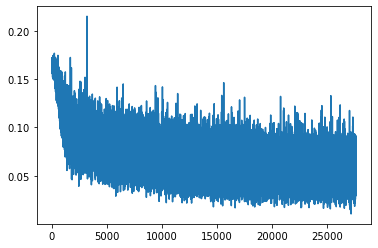

------
*********
29797 3094
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.16796964406967163
Loss:  0.16056202352046967
Loss:  0.15955282747745514
0 **********
Epoch:  56.74128556251526  fold:  2  kers:  64
epoch:  1
29797 466
Loss:  0.1475857049226761
Loss:  0.13591217994689941
Loss:  0.12749449908733368
1 **********
Epoch:  101.04981327056885  fold:  2  kers:  64
epoch:  2
29797 466
Loss:  0.09207093715667725
Loss:  0.12236316502094269
Loss:  0.12239044904708862
2 **********
Epoch:  145.28753066062927  fold:  2  kers:  64
epoch:  3
Eval Loss:  1.0862672328948975
Eval Loss:  0.08354391157627106
Eval Loss:  0.82359379529953
[[1277  153]
 [ 756  908]]
              precision    r

Loss:  0.09253444522619247
10 **********
Epoch:  616.6541919708252  fold:  2  kers:  64
epoch:  11
29797 466
Loss:  0.06664523482322693
Loss:  0.08433283865451813
Loss:  0.08820528537034988
11 **********
Epoch:  660.974687576294  fold:  2  kers:  64
epoch:  12
Eval Loss:  0.7962079644203186
Eval Loss:  0.12653107941150665
Eval Loss:  0.6889270544052124
[[1329  101]
 [ 801  863]]
              precision    recall  f1-score   support

           0       0.62      0.93      0.75      1430
           1       0.90      0.52      0.66      1664

    accuracy                           0.71      3094
   macro avg       0.76      0.72      0.70      3094
weighted avg       0.77      0.71      0.70      3094

acc:  0.7084680025856497
pre:  0.8952282157676349
rec:  0.5186298076923077
ma F1:  0.7017012125254392
mi F1:  0.7084680025856497
we F1:  0.6983032964866209
Eval Loss:  0.3229128122329712
Eval Loss:  0.25086554884910583
Eval Loss:  0.2945231795310974
Eval Loss:  0.42160701751708984
Eval Loss

Eval Loss:  0.2620336413383484
Eval Loss:  0.18210050463676453
Eval Loss:  0.17268194258213043
Eval Loss:  0.29290351271629333
Eval Loss:  0.2722179889678955
Eval Loss:  0.24756383895874023
Eval Loss:  0.25460442900657654
Eval Loss:  0.2961323857307434
Eval Loss:  0.2113412469625473
Eval Loss:  0.2610743045806885
Eval Loss:  0.29185929894447327
Eval Loss:  0.21310077607631683
Eval Loss:  0.371432900428772
Eval Loss:  0.109701007604599
Eval Loss:  0.21794812381267548
Eval Loss:  0.27683770656585693
Eval Loss:  0.2271321713924408
Eval Loss:  0.21197038888931274
Eval Loss:  0.24077525734901428
Eval Loss:  0.23156015574932098
Eval Loss:  0.2101857215166092
Eval Loss:  0.2785700559616089
Eval Loss:  0.3095042407512665
Eval Loss:  0.1671503335237503
Eval Loss:  0.259610116481781
Eval Loss:  0.31483644247055054
Eval Loss:  0.3401412069797516
Eval Loss:  0.244533970952034
Eval Loss:  0.2076311707496643
[[17898   836]
 [ 2172  8891]]
              precision    recall  f1-score   support

      

Eval Loss:  0.18991734087467194
Eval Loss:  0.17198608815670013
Eval Loss:  0.22947238385677338
Eval Loss:  0.3008674085140228
Eval Loss:  0.1275290548801422
Eval Loss:  0.19700351357460022
Eval Loss:  0.30345815420150757
Eval Loss:  0.28604161739349365
Eval Loss:  0.20760467648506165
Eval Loss:  0.20099025964736938
[[17730  1004]
 [ 1591  9472]]
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     18734
           1       0.90      0.86      0.88     11063

    accuracy                           0.91     29797
   macro avg       0.91      0.90      0.91     29797
weighted avg       0.91      0.91      0.91     29797

acc:  0.9129106957076216
pre:  0.9041618938526155
rec:  0.8561872909698997
ma F1:  0.9056650463067214
mi F1:  0.9129106957076216
we F1:  0.912395656206734
29797 466
Loss:  0.07605939358472824
Loss:  0.04041334241628647
Loss:  0.08785451948642731
30 **********
Epoch:  1772.0718400478363  fold:  2  kers:  64
epoch:  31
29797

Loss:  0.0464913547039032
Loss:  0.06294926255941391
Loss:  0.05313143506646156
39 **********
Epoch:  2295.8563463687897  fold:  2  kers:  64
epoch:  40
29797 466
Loss:  0.04978033900260925
Loss:  0.05080555006861687
Loss:  0.06868848949670792
40 **********
Epoch:  2340.01527428627  fold:  2  kers:  64
epoch:  41
29797 466
Loss:  0.0675588920712471
Loss:  0.05930183455348015
Loss:  0.0191888976842165
41 **********
Epoch:  2384.232047557831  fold:  2  kers:  64
epoch:  42
Eval Loss:  0.5830299258232117
Eval Loss:  0.49427083134651184
Eval Loss:  0.42385318875312805
[[1161  269]
 [ 470 1194]]
              precision    recall  f1-score   support

           0       0.71      0.81      0.76      1430
           1       0.82      0.72      0.76      1664

    accuracy                           0.76      3094
   macro avg       0.76      0.76      0.76      3094
weighted avg       0.77      0.76      0.76      3094

acc:  0.7611506140917905
pre:  0.8161312371838687
rec:  0.7175480769230769


Eval Loss:  0.20533661544322968
Eval Loss:  0.16264668107032776
Eval Loss:  0.11534281820058823
Eval Loss:  0.18797962367534637
Eval Loss:  0.17456692457199097
Eval Loss:  0.13121019303798676
Eval Loss:  0.14843392372131348
Eval Loss:  0.20201238989830017
Eval Loss:  0.15824009478092194
Eval Loss:  0.20312510430812836
Eval Loss:  0.3182131350040436
Eval Loss:  0.1368151307106018
Eval Loss:  0.2829936444759369
Eval Loss:  0.11568904668092728
Eval Loss:  0.22862772643566132
Eval Loss:  0.19969706237316132
Eval Loss:  0.18961456418037415
Eval Loss:  0.15350723266601562
Eval Loss:  0.1956525295972824
Eval Loss:  0.21668128669261932
Eval Loss:  0.14778323471546173
Eval Loss:  0.23725107312202454
Eval Loss:  0.31330662965774536
Eval Loss:  0.12146566808223724
Eval Loss:  0.18814663589000702
Eval Loss:  0.3310526907444
Eval Loss:  0.2478117048740387
Eval Loss:  0.16986599564552307
Eval Loss:  0.16509909927845
[[17220  1514]
 [  950 10113]]
              precision    recall  f1-score   support

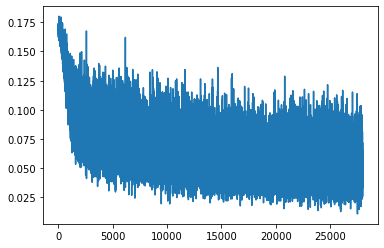

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1689136028289795
Loss:  0.16098803281784058
Loss:  0.15371479094028473
0 **********
Epoch:  56.282511472702026  fold:  3  kers:  64
epoch:  1
29460 461
Loss:  0.14043089747428894
Loss:  0.14171746373176575
Loss:  0.12440585345029831
1 **********
Epoch:  100.06444764137268  fold:  3  kers:  64
epoch:  2
29460 461
Loss:  0.1205996572971344
Loss:  0.10764483362436295
Loss:  0.13982819020748138
2 **********
Epoch:  143.87630367279053  fold:  3  kers:  64
epoch:  3
Eval Loss:  0.7192063927650452
Eval Loss:  0.838018000125885
Eval Loss:  0.3678755462169647
[[1244  292]
 [ 507 1388]]
              precision    r

Loss:  0.07935874164104462
Loss:  0.07350757718086243
Loss:  0.07695476710796356
11 **********
Epoch:  655.2489969730377  fold:  3  kers:  64
epoch:  12
Eval Loss:  1.1699342727661133
Eval Loss:  0.4325388967990875
Eval Loss:  0.7079406380653381
[[1421  115]
 [ 771 1124]]
              precision    recall  f1-score   support

           0       0.65      0.93      0.76      1536
           1       0.91      0.59      0.72      1895

    accuracy                           0.74      3431
   macro avg       0.78      0.76      0.74      3431
weighted avg       0.79      0.74      0.74      3431

acc:  0.7417662489070241
pre:  0.9071832122679581
rec:  0.5931398416886543
ma F1:  0.7398166242594718
mi F1:  0.741766248907024
we F1:  0.7374600072612518
Eval Loss:  0.2847141921520233
Eval Loss:  0.43156519532203674
Eval Loss:  0.43657243251800537
Eval Loss:  0.3772052824497223
Eval Loss:  0.366837739944458
Eval Loss:  0.3425622284412384
Eval Loss:  0.3183722496032715
Eval Loss:  0.4279976189136

Eval Loss:  0.17695732414722443
Eval Loss:  0.23272274434566498
Eval Loss:  0.27397558093070984
Eval Loss:  0.21249479055404663
Eval Loss:  0.2820640206336975
Eval Loss:  0.22009271383285522
Eval Loss:  0.2088673859834671
Eval Loss:  0.26302987337112427
Eval Loss:  0.3196726441383362
Eval Loss:  0.222312331199646
Eval Loss:  0.24510511755943298
Eval Loss:  0.23323634266853333
Eval Loss:  0.2459515631198883
Eval Loss:  0.21557268500328064
Eval Loss:  0.24603813886642456
Eval Loss:  0.22656790912151337
Eval Loss:  0.26522159576416016
Eval Loss:  0.2189972698688507
Eval Loss:  0.23128773272037506
Eval Loss:  0.22430679202079773
Eval Loss:  0.31576788425445557
Eval Loss:  0.24421149492263794
Eval Loss:  0.335884153842926
Eval Loss:  0.27122631669044495
Eval Loss:  0.3238523602485657
Eval Loss:  0.2802860140800476
Eval Loss:  0.26217785477638245
Eval Loss:  0.15738075971603394
[[17822   806]
 [ 2119  8713]]
              precision    recall  f1-score   support

           0       0.89      

Eval Loss:  0.2702142596244812
Eval Loss:  0.32313138246536255
Eval Loss:  0.29937633872032166
Eval Loss:  0.2073897272348404
Eval Loss:  0.1487368941307068
[[16659  1969]
 [  917  9915]]
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     18628
           1       0.83      0.92      0.87     10832

    accuracy                           0.90     29460
   macro avg       0.89      0.90      0.90     29460
weighted avg       0.91      0.90      0.90     29460

acc:  0.9020366598778005
pre:  0.8343150454392461
rec:  0.9153434268833087
ma F1:  0.8966190180279701
mi F1:  0.9020366598778005
we F1:  0.9028817605934027
29460 461
Loss:  0.052921801805496216
Loss:  0.08777059614658356
Loss:  0.051956918090581894
30 **********
Epoch:  1756.5204207897186  fold:  3  kers:  64
epoch:  31
29460 461
Loss:  0.042775705456733704
Loss:  0.048442572355270386
Loss:  0.07915526628494263
31 **********
Epoch:  1800.1148586273193  fold:  3  kers:  64
epoch:  

Loss:  0.04045889899134636
Loss:  0.044429779052734375
39 **********
Epoch:  2268.2750928401947  fold:  3  kers:  64
epoch:  40
29460 461
Loss:  0.054437071084976196
Loss:  0.07427150756120682
Loss:  0.04620423540472984
40 **********
Epoch:  2312.0560314655304  fold:  3  kers:  64
epoch:  41
29460 461
Loss:  0.055739875882864
Loss:  0.05078002065420151
Loss:  0.036622025072574615
41 **********
Epoch:  2355.8648958206177  fold:  3  kers:  64
epoch:  42
Eval Loss:  0.3183991611003876
Eval Loss:  0.11758241057395935
Eval Loss:  1.0399317741394043
[[1189  347]
 [ 501 1394]]
              precision    recall  f1-score   support

           0       0.70      0.77      0.74      1536
           1       0.80      0.74      0.77      1895

    accuracy                           0.75      3431
   macro avg       0.75      0.75      0.75      3431
weighted avg       0.76      0.75      0.75      3431

acc:  0.7528417371028855
pre:  0.800689259046525
rec:  0.7356200527704485
ma F1:  0.751956224760

Eval Loss:  0.15792140364646912
Eval Loss:  0.19621729850769043
Eval Loss:  0.24490629136562347
Eval Loss:  0.1751314401626587
Eval Loss:  0.2559446096420288
Eval Loss:  0.16452772915363312
Eval Loss:  0.192678302526474
Eval Loss:  0.16529901325702667
Eval Loss:  0.27385592460632324
Eval Loss:  0.21655240654945374
Eval Loss:  0.17008379101753235
Eval Loss:  0.20106005668640137
Eval Loss:  0.20015299320220947
Eval Loss:  0.1552276313304901
Eval Loss:  0.17443037033081055
Eval Loss:  0.21996891498565674
Eval Loss:  0.29648876190185547
Eval Loss:  0.19856968522071838
Eval Loss:  0.15806394815444946
Eval Loss:  0.22119154036045074
Eval Loss:  0.23638813197612762
Eval Loss:  0.2467285692691803
Eval Loss:  0.2936316430568695
Eval Loss:  0.2092054933309555
Eval Loss:  0.24808639287948608
Eval Loss:  0.28645387291908264
Eval Loss:  0.20631937682628632
Eval Loss:  0.08888830989599228
[[17701   927]
 [ 1440  9392]]
              precision    recall  f1-score   support

           0       0.92   

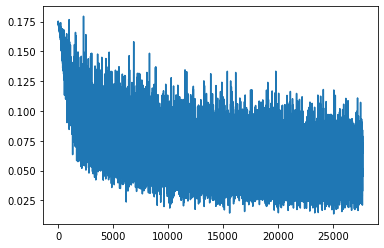

------
*********
29520 3371
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.1710306704044342
Loss:  0.16659054160118103
Loss:  0.15743769705295563
0 **********
Epoch:  56.38922595977783  fold:  4  kers:  64
epoch:  1
29520 462
Loss:  0.15081927180290222
Loss:  0.12637001276016235
Loss:  0.12219249457120895
1 **********
Epoch:  100.36763620376587  fold:  4  kers:  64
epoch:  2
29520 462
Loss:  0.10584516823291779
Loss:  0.1161123514175415
Loss:  0.1036926880478859
2 **********
Epoch:  144.21838855743408  fold:  4  kers:  64
epoch:  3
Eval Loss:  0.6138429641723633
Eval Loss:  0.44953346252441406
Eval Loss:  0.1436333805322647
[[2576  561]
 [ 113  121]]
              precision    r

Loss:  0.08821629732847214
Loss:  0.06911627948284149
Loss:  0.06596188992261887
11 **********
Epoch:  656.6622176170349  fold:  4  kers:  64
epoch:  12
Eval Loss:  0.027012433856725693
Eval Loss:  0.13636283576488495
Eval Loss:  0.029016513377428055
[[3091   46]
 [ 224   10]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3137
           1       0.18      0.04      0.07       234

    accuracy                           0.92      3371
   macro avg       0.56      0.51      0.51      3371
weighted avg       0.88      0.92      0.90      3371

acc:  0.9199050726787303
pre:  0.17857142857142858
rec:  0.042735042735042736
ma F1:  0.5135590140453641
mi F1:  0.9199050726787303
we F1:  0.8964290589050401
Eval Loss:  0.392844557762146
Eval Loss:  0.4379550516605377
Eval Loss:  0.44854849576950073
Eval Loss:  0.2864842712879181
Eval Loss:  0.30973148345947266
Eval Loss:  0.27674707770347595
Eval Loss:  0.3457533121109009
Eval Loss:  0.406

Eval Loss:  0.3215968608856201
Eval Loss:  0.3236236274242401
Eval Loss:  0.34229540824890137
Eval Loss:  0.17577005922794342
Eval Loss:  0.2133457213640213
Eval Loss:  0.20851238071918488
Eval Loss:  0.2650611102581024
Eval Loss:  0.3134515583515167
Eval Loss:  0.30225643515586853
Eval Loss:  0.28981733322143555
Eval Loss:  0.29291489720344543
Eval Loss:  0.2960807681083679
Eval Loss:  0.26776060461997986
Eval Loss:  0.25975531339645386
Eval Loss:  0.29775455594062805
Eval Loss:  0.3095419108867645
Eval Loss:  0.28112974762916565
Eval Loss:  0.3021691143512726
Eval Loss:  0.29393911361694336
Eval Loss:  0.3546580374240875
Eval Loss:  0.21479512751102448
Eval Loss:  0.2580578029155731
Eval Loss:  0.29435503482818604
Eval Loss:  0.2866523265838623
Eval Loss:  0.29309916496276855
Eval Loss:  0.33899033069610596
Eval Loss:  0.38745924830436707
Eval Loss:  0.2867063283920288
[[16214   813]
 [ 2632  9861]]
              precision    recall  f1-score   support

           0       0.86      0

Eval Loss:  0.2792501747608185
Eval Loss:  0.2758850157260895
Eval Loss:  0.2965700924396515
Eval Loss:  0.22797439992427826
[[15815  1212]
 [ 1514 10979]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     17027
           1       0.90      0.88      0.89     12493

    accuracy                           0.91     29520
   macro avg       0.91      0.90      0.91     29520
weighted avg       0.91      0.91      0.91     29520

acc:  0.9076558265582656
pre:  0.9005823968501353
rec:  0.8788121347954855
ma F1:  0.9051092076993258
mi F1:  0.9076558265582656
we F1:  0.907496794528613
29520 462
Loss:  0.06829817593097687
Loss:  0.08719103783369064
Loss:  0.054463282227516174
30 **********
Epoch:  1759.2301754951477  fold:  4  kers:  64
epoch:  31
29520 462
Loss:  0.06687184423208237
Loss:  0.058086905628442764
Loss:  0.06805546581745148
31 **********
Epoch:  1803.1278021335602  fold:  4  kers:  64
epoch:  32
29520 462
Loss:  0.0725125372409

Loss:  0.045735765248537064
39 **********
Epoch:  2269.352212905884  fold:  4  kers:  64
epoch:  40
29520 462
Loss:  0.06351427733898163
Loss:  0.043403178453445435
Loss:  0.08737774193286896
40 **********
Epoch:  2313.131156206131  fold:  4  kers:  64
epoch:  41
29520 462
Loss:  0.05123113840818405
Loss:  0.07422217726707458
Loss:  0.042864106595516205
41 **********
Epoch:  2362.080276966095  fold:  4  kers:  64
epoch:  42
Eval Loss:  0.44376853108406067
Eval Loss:  0.10062451660633087
Eval Loss:  0.008255836553871632
[[2991  146]
 [ 208   26]]
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3137
           1       0.15      0.11      0.13       234

    accuracy                           0.89      3371
   macro avg       0.54      0.53      0.54      3371
weighted avg       0.88      0.89      0.89      3371

acc:  0.8949866508454465
pre:  0.1511627906976744
rec:  0.1111111111111111
ma F1:  0.536103802806389
mi F1:  0.8949866508

Eval Loss:  0.21341009438037872
Eval Loss:  0.21887412667274475
Eval Loss:  0.25953707098960876
Eval Loss:  0.10713644325733185
Eval Loss:  0.14438965916633606
Eval Loss:  0.15289069712162018
Eval Loss:  0.19590139389038086
Eval Loss:  0.20753519237041473
Eval Loss:  0.20306028425693512
Eval Loss:  0.2109704464673996
Eval Loss:  0.15669456124305725
Eval Loss:  0.2216007113456726
Eval Loss:  0.17404651641845703
Eval Loss:  0.1853492110967636
Eval Loss:  0.1808653622865677
Eval Loss:  0.2408372163772583
Eval Loss:  0.16922946274280548
Eval Loss:  0.20358404517173767
Eval Loss:  0.21384815871715546
Eval Loss:  0.22924929857254028
Eval Loss:  0.1339985728263855
Eval Loss:  0.23268745839595795
Eval Loss:  0.25340113043785095
Eval Loss:  0.23556575179100037
Eval Loss:  0.23290447890758514
Eval Loss:  0.22740766406059265
Eval Loss:  0.26033830642700195
Eval Loss:  0.2136242538690567
[[15597  1430]
 [ 1118 11375]]
              precision    recall  f1-score   support

           0       0.93  

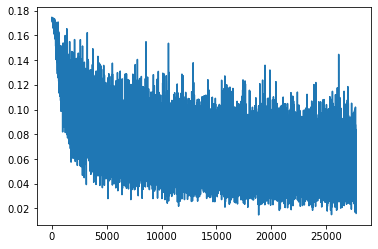

------
*********
29673 3218
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.17235806584358215
Loss:  0.16676412522792816
Loss:  0.16057267785072327
0 **********
Epoch:  56.784170627593994  fold:  5  kers:  64
epoch:  1
29673 464
Loss:  0.14415952563285828
Loss:  0.13740554451942444
Loss:  0.13467629253864288
1 **********
Epoch:  101.20340275764465  fold:  5  kers:  64
epoch:  2
29673 464
Loss:  0.11939196288585663
Loss:  0.11684621870517731
Loss:  0.10780768096446991
2 **********
Epoch:  145.44510889053345  fold:  5  kers:  64
epoch:  3
Eval Loss:  0.18914064764976501
Eval Loss:  0.37808099389076233
Eval Loss:  0.36928999423980713
[[2675  422]
 [  32   89]]
              precisio

Loss:  0.09533381462097168
Loss:  0.11050553619861603
10 **********
Epoch:  616.9503998756409  fold:  5  kers:  64
epoch:  11
29673 464
Loss:  0.09431234002113342
Loss:  0.10704310983419418
Loss:  0.10671138018369675
11 **********
Epoch:  661.2369866371155  fold:  5  kers:  64
epoch:  12
Eval Loss:  0.08300606906414032
Eval Loss:  0.2569347620010376
Eval Loss:  0.07102564722299576
[[3015   82]
 [  26   95]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3097
           1       0.54      0.79      0.64       121

    accuracy                           0.97      3218
   macro avg       0.76      0.88      0.81      3218
weighted avg       0.97      0.97      0.97      3218

acc:  0.966438781852082
pre:  0.536723163841808
rec:  0.7851239669421488
ma F1:  0.8099942923497806
mi F1:  0.9664387818520821
we F1:  0.9694390871302083
Eval Loss:  0.2924477756023407
Eval Loss:  0.3706435561180115
Eval Loss:  0.3064173460006714
Eval Loss:  0.3

Eval Loss:  0.24194954335689545
Eval Loss:  0.4003955125808716
Eval Loss:  0.25158655643463135
Eval Loss:  0.30205461382865906
Eval Loss:  0.3101499676704407
Eval Loss:  0.23931309580802917
Eval Loss:  0.2561119496822357
Eval Loss:  0.2544957995414734
Eval Loss:  0.21705099940299988
Eval Loss:  0.29615968465805054
Eval Loss:  0.29194915294647217
Eval Loss:  0.18703186511993408
Eval Loss:  0.30307701230049133
Eval Loss:  0.2650615870952606
Eval Loss:  0.2501607835292816
Eval Loss:  0.2576942443847656
Eval Loss:  0.33393752574920654
Eval Loss:  0.3232649862766266
Eval Loss:  0.23836730420589447
Eval Loss:  0.2551954686641693
Eval Loss:  0.28722888231277466
Eval Loss:  0.2689197063446045
Eval Loss:  0.23504437506198883
Eval Loss:  0.35299572348594666
Eval Loss:  0.24388793110847473
Eval Loss:  0.3184169828891754
Eval Loss:  0.33598560094833374
Eval Loss:  0.29483404755592346
Eval Loss:  0.2620186507701874
[[16144   923]
 [ 2623  9983]]
              precision    recall  f1-score   support

Eval Loss:  0.27157723903656006
Eval Loss:  0.2891134023666382
Eval Loss:  0.2641669809818268
Eval Loss:  0.2224135398864746
Eval Loss:  0.33679935336112976
Eval Loss:  0.27122005820274353
Eval Loss:  0.33217093348503113
Eval Loss:  0.30111056566238403
Eval Loss:  0.26287174224853516
Eval Loss:  0.24799847602844238
[[16108   959]
 [ 2474 10132]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     17067
           1       0.91      0.80      0.86     12606

    accuracy                           0.88     29673
   macro avg       0.89      0.87      0.88     29673
weighted avg       0.89      0.88      0.88     29673

acc:  0.8843055976813938
pre:  0.9135334956270851
rec:  0.8037442487704268
ma F1:  0.879414652400083
mi F1:  0.8843055976813938
we F1:  0.8830656743043548
29673 464
Loss:  0.07062843441963196
Loss:  0.06279628723859787
Loss:  0.0715327337384224
30 **********
Epoch:  1772.4059462547302  fold:  5  kers:  64
epoch:  31
29673 4

Loss:  0.07354282587766647
Loss:  0.04447600618004799
Loss:  0.05996239557862282
39 **********
Epoch:  2286.0904586315155  fold:  5  kers:  64
epoch:  40
29673 464
Loss:  0.05806427821516991
Loss:  0.07855504006147385
Loss:  0.04286777228116989
40 **********
Epoch:  2330.2194669246674  fold:  5  kers:  64
epoch:  41
29673 464
Loss:  0.07698094844818115
Loss:  0.0695393979549408
Loss:  0.08803999423980713
41 **********
Epoch:  2374.467157125473  fold:  5  kers:  64
epoch:  42
Eval Loss:  0.06634119153022766
Eval Loss:  0.04175695776939392
Eval Loss:  0.033291351050138474
[[3072   25]
 [  24   97]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.80      0.80      0.80       121

    accuracy                           0.98      3218
   macro avg       0.89      0.90      0.90      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9847731510254817
pre:  0.7950819672131147
rec:  0.80165289256

 [  32   89]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3097
           1       0.83      0.74      0.78       121

    accuracy                           0.98      3218
   macro avg       0.91      0.86      0.89      3218
weighted avg       0.98      0.98      0.98      3218

acc:  0.9844623990055935
pre:  0.8317757009345794
rec:  0.7355371900826446
ma F1:  0.8863238153373123
mi F1:  0.9844623990055935
we F1:  0.9840028872425982
Eval Loss:  0.16859538853168488
Eval Loss:  0.3208196461200714
Eval Loss:  0.23820525407791138
Eval Loss:  0.2277810126543045
Eval Loss:  0.2580246925354004
Eval Loss:  0.23890002071857452
Eval Loss:  0.2214640974998474
Eval Loss:  0.2241542786359787
Eval Loss:  0.2205570936203003
Eval Loss:  0.23286172747612
Eval Loss:  0.22751855850219727
Eval Loss:  0.1749367117881775
Eval Loss:  0.2500179708003998
Eval Loss:  0.24451959133148193
Eval Loss:  0.17909584939479828
Eval Loss:  0.20161695778369904
Ev

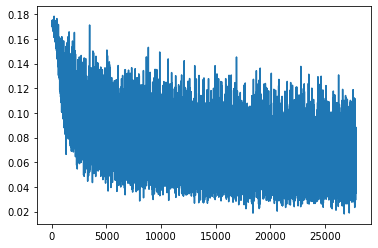

------
*********
29479 3412
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.16218788921833038
Loss:  0.16561228036880493
Loss:  0.1693512350320816
0 **********
Epoch:  56.21668744087219  fold:  6  kers:  64
epoch:  1
29479 461
Loss:  0.15241201221942902
Loss:  0.14492011070251465
Loss:  0.12130666524171829
1 **********
Epoch:  100.33472490310669  fold:  6  kers:  64
epoch:  2
29479 461
Loss:  0.13046830892562866
Loss:  0.09905118495225906
Loss:  0.11520390957593918
2 **********
Epoch:  144.43580770492554  fold:  6  kers:  64
epoch:  3
Eval Loss:  0.1267150342464447
Eval Loss:  0.2947532534599304
Eval Loss:  0.5765506625175476
[[1848  384]
 [ 111 1069]]
              precision    

Loss:  0.07225978374481201
Loss:  0.09262873232364655
Loss:  0.10361611098051071
11 **********
Epoch:  658.0036323070526  fold:  6  kers:  64
epoch:  12
Eval Loss:  0.029867656528949738
Eval Loss:  0.254341721534729
Eval Loss:  0.428371399641037
[[2075  157]
 [ 226  954]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2232
           1       0.86      0.81      0.83      1180

    accuracy                           0.89      3412
   macro avg       0.88      0.87      0.87      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8877491207502931
pre:  0.8586858685868587
rec:  0.8084745762711865
ma F1:  0.8741662937767686
mi F1:  0.8877491207502931
we F1:  0.8869130680641439
update!  Acc:  0.8877491207502931
Eval Loss:  0.3457990884780884
Eval Loss:  0.29158011078834534
Eval Loss:  0.34183841943740845
Eval Loss:  0.328107625246048
Eval Loss:  0.254756897687912
Eval Loss:  0.3273022770881653
Eval Loss:  0.4431783556

Eval Loss:  0.2526490092277527
Eval Loss:  0.2039966881275177
Eval Loss:  0.25637394189834595
Eval Loss:  0.30767154693603516
Eval Loss:  0.2157008945941925
Eval Loss:  0.29252439737319946
Eval Loss:  0.36485177278518677
Eval Loss:  0.266028493642807
Eval Loss:  0.3121984899044037
Eval Loss:  0.3615986704826355
Eval Loss:  0.22661486268043518
Eval Loss:  0.32978442311286926
Eval Loss:  0.287246435880661
Eval Loss:  0.31158357858657837
Eval Loss:  0.1907075047492981
Eval Loss:  0.23127350211143494
Eval Loss:  0.3247464895248413
Eval Loss:  0.36675962805747986
Eval Loss:  0.301780641078949
Eval Loss:  0.28893008828163147
Eval Loss:  0.20009535551071167
Eval Loss:  0.24020230770111084
Eval Loss:  0.2918888330459595
Eval Loss:  0.2744447588920593
Eval Loss:  0.23929129540920258
Eval Loss:  0.25008273124694824
Eval Loss:  0.20277385413646698
Eval Loss:  0.28015127778053284
[[17223   709]
 [ 2795  8752]]
              precision    recall  f1-score   support

           0       0.86      0.96

Eval Loss:  0.27053102850914
Eval Loss:  0.2158854901790619
Eval Loss:  0.2205594778060913
Eval Loss:  0.196188822388649
Eval Loss:  0.3050477206707001
[[17284   648]
 [ 2663  8884]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     17932
           1       0.93      0.77      0.84     11547

    accuracy                           0.89     29479
   macro avg       0.90      0.87      0.88     29479
weighted avg       0.89      0.89      0.89     29479

acc:  0.887682757217002
pre:  0.9320184641208561
rec:  0.7693773274443578
ma F1:  0.8777571634440823
mi F1:  0.887682757217002
we F1:  0.8853017963298075
29479 461
Loss:  0.05841042101383209
Loss:  0.07292488217353821
Loss:  0.07421821355819702
30 **********
Epoch:  1762.6091403961182  fold:  6  kers:  64
epoch:  31
29479 461
Loss:  0.051382988691329956
Loss:  0.07581949979066849
Loss:  0.0655740350484848
31 **********
Epoch:  1806.5666074752808  fold:  6  kers:  64
epoch:  32
29479 46

Loss:  0.05947820842266083
Loss:  0.08368421345949173
39 **********
Epoch:  2273.35351395607  fold:  6  kers:  64
epoch:  40
29479 461
Loss:  0.03583995997905731
Loss:  0.03187808394432068
Loss:  0.06409360468387604
40 **********
Epoch:  2317.098548412323  fold:  6  kers:  64
epoch:  41
29479 461
Loss:  0.07648801058530807
Loss:  0.03292294591665268
Loss:  0.04529667645692825
41 **********
Epoch:  2360.944313764572  fold:  6  kers:  64
epoch:  42
Eval Loss:  0.010344767943024635
Eval Loss:  0.1428743600845337
Eval Loss:  0.32444584369659424
[[2051  181]
 [ 219  961]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2232
           1       0.84      0.81      0.83      1180

    accuracy                           0.88      3412
   macro avg       0.87      0.87      0.87      3412
weighted avg       0.88      0.88      0.88      3412

acc:  0.8827667057444314
pre:  0.841506129597198
rec:  0.8144067796610169
ma F1:  0.869442655594546

Eval Loss:  0.17455324530601501
Eval Loss:  0.16225303709506989
Eval Loss:  0.22831939160823822
Eval Loss:  0.25855669379234314
Eval Loss:  0.19704997539520264
Eval Loss:  0.21472959220409393
Eval Loss:  0.3243960738182068
Eval Loss:  0.23698003590106964
Eval Loss:  0.24542294442653656
Eval Loss:  0.2580643594264984
Eval Loss:  0.20618878304958344
Eval Loss:  0.2281191498041153
Eval Loss:  0.2489992380142212
Eval Loss:  0.2525964379310608
Eval Loss:  0.11239360272884369
Eval Loss:  0.18387672305107117
Eval Loss:  0.20109957456588745
Eval Loss:  0.2589067816734314
Eval Loss:  0.1925320029258728
Eval Loss:  0.24589651823043823
Eval Loss:  0.17092065513134003
Eval Loss:  0.1981215924024582
Eval Loss:  0.2063913345336914
Eval Loss:  0.21236391365528107
Eval Loss:  0.22218605875968933
Eval Loss:  0.14984168112277985
Eval Loss:  0.13460642099380493
Eval Loss:  0.2412944734096527
[[17202   730]
 [ 1956  9591]]
              precision    recall  f1-score   support

           0       0.90     

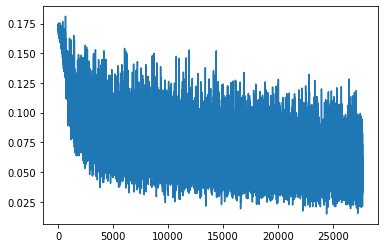

------
*********
29460 3431
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1692022681236267
Loss:  0.16186581552028656
Loss:  0.14849239587783813
0 **********
Epoch:  56.30844211578369  fold:  7  kers:  64
epoch:  1
29460 461
Loss:  0.1291511058807373
Loss:  0.1352340430021286
Loss:  0.09973757714033127
1 **********
Epoch:  100.33572220802307  fold:  7  kers:  64
epoch:  2
29460 461
Loss:  0.0878794938325882
Loss:  0.0971841961145401
Loss:  0.0978541299700737
2 **********
Epoch:  144.17550349235535  fold:  7  kers:  64
epoch:  3
Eval Loss:  0.6262997388839722
Eval Loss:  0.1570250391960144
Eval Loss:  1.6133657693862915
[[1695  432]
 [ 612  692]]
              precision    recal

Loss:  0.07987810671329498
Loss:  0.05568470060825348
Loss:  0.09709499031305313
11 **********
Epoch:  654.324469089508  fold:  7  kers:  64
epoch:  12
Eval Loss:  0.9774326086044312
Eval Loss:  0.03588206321001053
Eval Loss:  3.209233283996582
[[2099   28]
 [ 972  332]]
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      2127
           1       0.92      0.25      0.40      1304

    accuracy                           0.71      3431
   macro avg       0.80      0.62      0.60      3431
weighted avg       0.77      0.71      0.65      3431

acc:  0.7085397843194404
pre:  0.9222222222222223
rec:  0.254601226993865
ma F1:  0.6033283881374494
mi F1:  0.7085397843194403
we F1:  0.6523317718713366
Eval Loss:  0.4485631585121155
Eval Loss:  0.33577021956443787
Eval Loss:  0.38807353377342224
Eval Loss:  0.44145241379737854
Eval Loss:  0.2950443923473358
Eval Loss:  0.4550859332084656
Eval Loss:  0.4930594563484192
Eval Loss:  0.314849495887

Eval Loss:  0.31873878836631775
Eval Loss:  0.2189754843711853
Eval Loss:  0.1457684487104416
Eval Loss:  0.22686639428138733
Eval Loss:  0.2660466134548187
Eval Loss:  0.28604331612586975
Eval Loss:  0.29045233130455017
Eval Loss:  0.14855116605758667
Eval Loss:  0.238320454955101
Eval Loss:  0.2156783938407898
Eval Loss:  0.19417254626750946
Eval Loss:  0.16240671277046204
Eval Loss:  0.23903943598270416
Eval Loss:  0.23528936505317688
Eval Loss:  0.2517075538635254
Eval Loss:  0.2958981394767761
Eval Loss:  0.24610857665538788
Eval Loss:  0.30508682131767273
Eval Loss:  0.23527057468891144
Eval Loss:  0.2807103097438812
Eval Loss:  0.19271966814994812
Eval Loss:  0.2520277798175812
Eval Loss:  0.18841597437858582
Eval Loss:  0.25584545731544495
Eval Loss:  0.18010573089122772
Eval Loss:  0.2501424252986908
Eval Loss:  0.28748396039009094
Eval Loss:  0.2478754222393036
[[16737  1300]
 [ 1572  9851]]
              precision    recall  f1-score   support

           0       0.91      0

Eval Loss:  0.16940072178840637
Eval Loss:  0.22829380631446838
Eval Loss:  0.17528437077999115
Eval Loss:  0.2493249475955963
Eval Loss:  0.2505330741405487
Eval Loss:  0.22884082794189453
[[16630  1407]
 [ 1259 10164]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     18037
           1       0.88      0.89      0.88     11423

    accuracy                           0.91     29460
   macro avg       0.90      0.91      0.90     29460
weighted avg       0.91      0.91      0.91     29460

acc:  0.9095044127630686
pre:  0.8784029038112523
rec:  0.889783769587674
ma F1:  0.9049243080149516
mi F1:  0.9095044127630686
we F1:  0.9096092465865641
29460 461
Loss:  0.06991731375455856
Loss:  0.09555955231189728
Loss:  0.044621437788009644
30 **********
Epoch:  1756.9093811511993  fold:  7  kers:  64
epoch:  31
29460 461
Loss:  0.0437813475728035
Loss:  0.060496460646390915
Loss:  0.07484018802642822
31 **********
Epoch:  1800.7980313301086 

Loss:  0.059015754610300064
Loss:  0.04414370656013489
Loss:  0.03406374156475067
39 **********
Epoch:  2267.373503923416  fold:  7  kers:  64
epoch:  40
29460 461
Loss:  0.06491203606128693
Loss:  0.04957692325115204
Loss:  0.021055176854133606
40 **********
Epoch:  2311.211290359497  fold:  7  kers:  64
epoch:  41
29460 461
Loss:  0.04091912880539894
Loss:  0.04886394739151001
Loss:  0.0629991665482521
41 **********
Epoch:  2354.9672956466675  fold:  7  kers:  64
epoch:  42
Eval Loss:  0.4613412022590637
Eval Loss:  0.04192713275551796
Eval Loss:  1.9242182970046997
[[1855  272]
 [ 586  718]]
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      2127
           1       0.73      0.55      0.63      1304

    accuracy                           0.75      3431
   macro avg       0.74      0.71      0.72      3431
weighted avg       0.75      0.75      0.74      3431

acc:  0.7499271349460799
pre:  0.7252525252525253
rec:  0.5506134969325

Eval Loss:  0.23635242879390717
Eval Loss:  0.19338853657245636
Eval Loss:  0.14372441172599792
Eval Loss:  0.21346484124660492
Eval Loss:  0.19764110445976257
Eval Loss:  0.2948581278324127
Eval Loss:  0.22736099362373352
Eval Loss:  0.12105321139097214
Eval Loss:  0.21783597767353058
Eval Loss:  0.17697389423847198
Eval Loss:  0.2042533904314041
Eval Loss:  0.17295359075069427
Eval Loss:  0.23225602507591248
Eval Loss:  0.2102278769016266
Eval Loss:  0.16234883666038513
Eval Loss:  0.2343972623348236
Eval Loss:  0.2046385109424591
Eval Loss:  0.32434698939323425
Eval Loss:  0.1782512366771698
Eval Loss:  0.23880769312381744
Eval Loss:  0.1412530243396759
Eval Loss:  0.19697795808315277
Eval Loss:  0.13596738874912262
Eval Loss:  0.24229899048805237
Eval Loss:  0.12530674040317535
Eval Loss:  0.23089776933193207
Eval Loss:  0.22122454643249512
Eval Loss:  0.21545624732971191
[[17290   747]
 [ 1654  9769]]
              precision    recall  f1-score   support

           0       0.91  

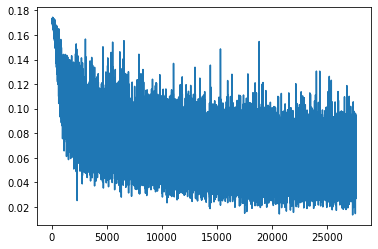

------
*********
29817 3074
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.16914746165275574
Loss:  0.17134691774845123
Loss:  0.15388666093349457
0 **********
Epoch:  56.9716694355011  fold:  8  kers:  64
epoch:  1
29817 466
Loss:  0.13265635073184967
Loss:  0.12116890400648117
Loss:  0.12353431433439255
1 **********
Epoch:  101.55047464370728  fold:  8  kers:  64
epoch:  2
29817 466
Loss:  0.12687326967716217
Loss:  0.1181505024433136
Loss:  0.09802384674549103
2 **********
Epoch:  146.13526368141174  fold:  8  kers:  64
epoch:  3
Eval Loss:  0.24969588220119476
Eval Loss:  1.1867276430130005
Eval Loss:  0.2430168241262436
[[1903  170]
 [ 430  571]]
              precision    

Loss:  0.064642995595932
Loss:  0.07376603037118912
Loss:  0.12884438037872314
11 **********
Epoch:  663.3523309230804  fold:  8  kers:  64
epoch:  12
Eval Loss:  0.140415221452713
Eval Loss:  1.8945566415786743
Eval Loss:  0.0929667204618454
[[2043   30]
 [ 650  351]]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2073
           1       0.92      0.35      0.51      1001

    accuracy                           0.78      3074
   macro avg       0.84      0.67      0.68      3074
weighted avg       0.81      0.78      0.74      3074

acc:  0.77878985035784
pre:  0.9212598425196851
rec:  0.35064935064935066
ma F1:  0.6826410907458949
mi F1:  0.77878985035784
we F1:  0.7435580353700113
Eval Loss:  0.3161126375198364
Eval Loss:  0.37568214535713196
Eval Loss:  0.45966964960098267
Eval Loss:  0.446002721786499
Eval Loss:  0.44478461146354675
Eval Loss:  0.5280474424362183
Eval Loss:  0.5303286910057068
Eval Loss:  0.45494553446769714

Eval Loss:  0.21530704200267792
Eval Loss:  0.27365460991859436
Eval Loss:  0.2999684810638428
Eval Loss:  0.3416154980659485
Eval Loss:  0.27002668380737305
Eval Loss:  0.34815239906311035
Eval Loss:  0.39520254731178284
Eval Loss:  0.27780529856681824
Eval Loss:  0.310676634311676
Eval Loss:  0.23574872314929962
Eval Loss:  0.20579908788204193
Eval Loss:  0.21689561009407043
Eval Loss:  0.29313239455223083
Eval Loss:  0.22501514852046967
Eval Loss:  0.28532788157463074
Eval Loss:  0.2538353204727173
Eval Loss:  0.2484634518623352
Eval Loss:  0.3069674074649811
Eval Loss:  0.2292211651802063
Eval Loss:  0.2561163008213043
Eval Loss:  0.3992362916469574
Eval Loss:  0.37601807713508606
Eval Loss:  0.24647632241249084
Eval Loss:  0.2661033570766449
Eval Loss:  0.4192737936973572
Eval Loss:  0.2970251441001892
Eval Loss:  0.29537779092788696
Eval Loss:  0.2980310618877411
Eval Loss:  0.22940140962600708
[[17455   636]
 [ 2798  8928]]
              precision    recall  f1-score   support



Eval Loss:  0.23385818302631378
Eval Loss:  0.26403605937957764
Eval Loss:  0.3749249279499054
Eval Loss:  0.37741389870643616
Eval Loss:  0.25288069248199463
Eval Loss:  0.24368497729301453
Eval Loss:  0.38205596804618835
Eval Loss:  0.29621416330337524
Eval Loss:  0.28510624170303345
Eval Loss:  0.2889552414417267
Eval Loss:  0.2280072122812271
[[17587   504]
 [ 2909  8817]]
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     18091
           1       0.95      0.75      0.84     11726

    accuracy                           0.89     29817
   macro avg       0.90      0.86      0.87     29817
weighted avg       0.89      0.89      0.88     29817

acc:  0.8855350974276419
pre:  0.9459285484390086
rec:  0.7519188128944226
ma F1:  0.8746948220808601
mi F1:  0.8855350974276419
we F1:  0.8825623651347103
29817 466
Loss:  0.06336189806461334
Loss:  0.04598833993077278
Loss:  0.05582272261381149
30 **********
Epoch:  1774.6150398254395  fold

Loss:  0.05335625261068344
Loss:  0.0716388002038002
Loss:  0.07054267823696136
39 **********
Epoch:  2288.4292056560516  fold:  8  kers:  64
epoch:  40
29817 466
Loss:  0.03439490869641304
Loss:  0.08527223765850067
Loss:  0.030447686091065407
40 **********
Epoch:  2332.631019115448  fold:  8  kers:  64
epoch:  41
29817 466
Loss:  0.06362055987119675
Loss:  0.10323615372180939
Loss:  0.054792068898677826
41 **********
Epoch:  2376.836821079254  fold:  8  kers:  64
epoch:  42
Eval Loss:  0.9247264266014099
Eval Loss:  1.0029829740524292
Eval Loss:  0.10458069294691086
[[1803  270]
 [ 230  771]]
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      2073
           1       0.74      0.77      0.76      1001

    accuracy                           0.84      3074
   macro avg       0.81      0.82      0.82      3074
weighted avg       0.84      0.84      0.84      3074

acc:  0.8373454782042941
pre:  0.7406340057636888
rec:  0.7702297702297

Eval Loss:  0.19991028308868408
Eval Loss:  0.18775944411754608
Eval Loss:  0.2364421784877777
Eval Loss:  0.20131585001945496
Eval Loss:  0.13424398005008698
Eval Loss:  0.22235244512557983
Eval Loss:  0.2630925476551056
Eval Loss:  0.21043069660663605
Eval Loss:  0.24734313786029816
Eval Loss:  0.16645663976669312
Eval Loss:  0.13284774124622345
Eval Loss:  0.21529535949230194
Eval Loss:  0.231378972530365
Eval Loss:  0.14914561808109283
Eval Loss:  0.2074553519487381
Eval Loss:  0.25176554918289185
Eval Loss:  0.18302351236343384
Eval Loss:  0.2407272756099701
Eval Loss:  0.1760396659374237
Eval Loss:  0.19574256241321564
Eval Loss:  0.23451782763004303
Eval Loss:  0.21773555874824524
Eval Loss:  0.16045768558979034
Eval Loss:  0.23557573556900024
Eval Loss:  0.24330487847328186
Eval Loss:  0.1842012107372284
Eval Loss:  0.21217934787273407
Eval Loss:  0.17946602404117584
Eval Loss:  0.1558743119239807
[[16952  1139]
 [ 1150 10576]]
              precision    recall  f1-score   supp

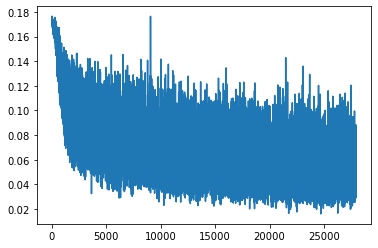

------
*********
29483 3408
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.1675654649734497
Loss:  0.15439236164093018
Loss:  0.15719708800315857
0 **********
Epoch:  56.39421200752258  fold:  9  kers:  64
epoch:  1
29483 461
Loss:  0.142460435628891
Loss:  0.12325633317232132
Loss:  0.13751891255378723
1 **********
Epoch:  100.41351318359375  fold:  9  kers:  64
epoch:  2
29483 461
Loss:  0.113263338804245
Loss:  0.12398607283830643
Loss:  0.10491663217544556
2 **********
Epoch:  144.31313490867615  fold:  9  kers:  64
epoch:  3
Eval Loss:  0.20646759867668152
Eval Loss:  1.0156183242797852
Eval Loss:  0.3696807622909546
[[1528  214]
 [ 403 1263]]
              precision    rec

Loss:  0.06035253405570984
Loss:  0.08977827429771423
Loss:  0.07063096016645432
11 **********
Epoch:  658.7117373943329  fold:  9  kers:  64
epoch:  12
Eval Loss:  0.063871830701828
Eval Loss:  1.456841230392456
Eval Loss:  0.2124846875667572
[[1646   96]
 [ 546 1120]]
              precision    recall  f1-score   support

           0       0.75      0.94      0.84      1742
           1       0.92      0.67      0.78      1666

    accuracy                           0.81      3408
   macro avg       0.84      0.81      0.81      3408
weighted avg       0.83      0.81      0.81      3408

acc:  0.8116197183098591
pre:  0.9210526315789473
rec:  0.6722689075630253
ma F1:  0.807022674969756
mi F1:  0.8116197183098591
we F1:  0.8076868865550182
Eval Loss:  0.35060223937034607
Eval Loss:  0.3251705765724182
Eval Loss:  0.3270430564880371
Eval Loss:  0.2984015941619873
Eval Loss:  0.29774588346481323
Eval Loss:  0.21051901578903198
Eval Loss:  0.31142982840538025
Eval Loss:  0.381517171859

Eval Loss:  0.33181580901145935
Eval Loss:  0.2869437336921692
Eval Loss:  0.27905935049057007
Eval Loss:  0.2666451930999756
Eval Loss:  0.2646024525165558
Eval Loss:  0.18822085857391357
Eval Loss:  0.26519060134887695
Eval Loss:  0.29127630591392517
Eval Loss:  0.2601896822452545
Eval Loss:  0.23137864470481873
Eval Loss:  0.2621168792247772
Eval Loss:  0.31577828526496887
Eval Loss:  0.23916947841644287
Eval Loss:  0.23893976211547852
Eval Loss:  0.31486934423446655
Eval Loss:  0.2697738707065582
Eval Loss:  0.2624695301055908
Eval Loss:  0.2593719959259033
Eval Loss:  0.22429485619068146
Eval Loss:  0.2735334038734436
Eval Loss:  0.32058534026145935
Eval Loss:  0.1990630030632019
Eval Loss:  0.19666804373264313
Eval Loss:  0.25908002257347107
Eval Loss:  0.2897169291973114
Eval Loss:  0.30106088519096375
Eval Loss:  0.22820793092250824
Eval Loss:  0.20544973015785217
[[17531   891]
 [ 2018  9043]]
              precision    recall  f1-score   support

           0       0.90      

Eval Loss:  0.22697587311267853
Eval Loss:  0.25426676869392395
Eval Loss:  0.2973986268043518
Eval Loss:  0.22819547355175018
Eval Loss:  0.19368265569210052
[[17535   887]
 [ 1827  9234]]
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     18422
           1       0.91      0.83      0.87     11061

    accuracy                           0.91     29483
   macro avg       0.91      0.89      0.90     29483
weighted avg       0.91      0.91      0.91     29483

acc:  0.9079469524810908
pre:  0.9123604386918289
rec:  0.8348250610252238
ma F1:  0.9000214993442893
mi F1:  0.9079469524810907
we F1:  0.9070494791708157
29483 461
Loss:  0.05677727982401848
Loss:  0.07772419601678848
Loss:  0.06622234731912613
30 **********
Epoch:  1761.7643988132477  fold:  9  kers:  64
epoch:  31
29483 461
Loss:  0.11241790652275085
Loss:  0.07362350076436996
Loss:  0.05704222619533539
31 **********
Epoch:  1805.5543131828308  fold:  9  kers:  64
epoch:  32

Loss:  0.058578524738550186
39 **********
Epoch:  2272.5775883197784  fold:  9  kers:  64
epoch:  40
29483 461
Loss:  0.06481415033340454
Loss:  0.05648966506123543
Loss:  0.04670620709657669
40 **********
Epoch:  2316.3565323352814  fold:  9  kers:  64
epoch:  41
29483 461
Loss:  0.05776338279247284
Loss:  0.05734708160161972
Loss:  0.08487141877412796
41 **********
Epoch:  2360.14844083786  fold:  9  kers:  64
epoch:  42
Eval Loss:  0.04540110379457474
Eval Loss:  0.9552433490753174
Eval Loss:  0.17018263041973114
[[1635  107]
 [ 456 1210]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1742
           1       0.92      0.73      0.81      1666

    accuracy                           0.83      3408
   macro avg       0.85      0.83      0.83      3408
weighted avg       0.85      0.83      0.83      3408

acc:  0.8348004694835681
pre:  0.9187547456340167
rec:  0.7262905162064826
ma F1:  0.8321907453830686
mi F1:  0.834800469483

Eval Loss:  0.3053707480430603
Eval Loss:  0.23532085120677948
Eval Loss:  0.23446018993854523
Eval Loss:  0.18401552736759186
Eval Loss:  0.20253244042396545
Eval Loss:  0.14171220362186432
Eval Loss:  0.19529740512371063
Eval Loss:  0.18897242844104767
Eval Loss:  0.21063002943992615
Eval Loss:  0.1897251158952713
Eval Loss:  0.21854765713214874
Eval Loss:  0.27827802300453186
Eval Loss:  0.1538093388080597
Eval Loss:  0.16326725482940674
Eval Loss:  0.26795732975006104
Eval Loss:  0.19812804460525513
Eval Loss:  0.22541970014572144
Eval Loss:  0.20654414594173431
Eval Loss:  0.15076935291290283
Eval Loss:  0.25520238280296326
Eval Loss:  0.23349817097187042
Eval Loss:  0.16114144027233124
Eval Loss:  0.1643855720758438
Eval Loss:  0.1533309370279312
Eval Loss:  0.2060486376285553
Eval Loss:  0.28887808322906494
Eval Loss:  0.18137116730213165
Eval Loss:  0.16977134346961975
[[17325  1097]
 [ 1160  9901]]
              precision    recall  f1-score   support

           0       0.94 

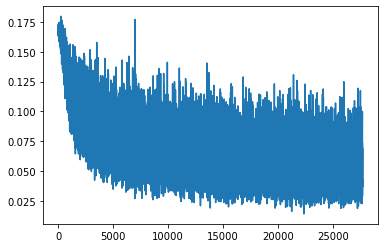

------
*********
29871 3020
Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.16605782508850098
Loss:  0.16819368302822113
Loss:  0.16304314136505127
0 **********
Epoch:  56.9367618560791  fold:  10  kers:  64
epoch:  1
29871 467
Loss:  0.13011249899864197
Loss:  0.1553448587656021
Loss:  0.1350085437297821
1 **********
Epoch:  101.38092708587646  fold:  10  kers:  64
epoch:  2
29871 467
Loss:  0.09544163197278976
Loss:  0.12015610933303833
Loss:  0.12054431438446045
2 **********
Epoch:  145.94776463508606  fold:  10  kers:  64
epoch:  3
Eval Loss:  0.7118579745292664
Eval Loss:  0.2347063422203064
Eval Loss:  0.07994268834590912
[[1611  140]
 [ 280  989]]
              precision  

Loss:  0.0994143933057785
10 **********
Epoch:  620.4779672622681  fold:  10  kers:  64
epoch:  11
29871 467
Loss:  0.07290081679821014
Loss:  0.07160283625125885
Loss:  0.073926642537117
11 **********
Epoch:  664.9121594429016  fold:  10  kers:  64
epoch:  12
Eval Loss:  0.5625830292701721
Eval Loss:  0.09277006983757019
Eval Loss:  0.07237983494997025
[[1686   65]
 [ 283  986]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1751
           1       0.94      0.78      0.85      1269

    accuracy                           0.88      3020
   macro avg       0.90      0.87      0.88      3020
weighted avg       0.89      0.88      0.88      3020

acc:  0.8847682119205298
pre:  0.9381541389153187
rec:  0.77698975571316
ma F1:  0.8782258064516129
mi F1:  0.8847682119205298
we F1:  0.8827307199316385
Eval Loss:  0.35854315757751465
Eval Loss:  0.29930180311203003
Eval Loss:  0.37670743465423584
Eval Loss:  0.2845286726951599
Eval Loss

Eval Loss:  0.27090251445770264
Eval Loss:  0.23045621812343597
Eval Loss:  0.26722896099090576
Eval Loss:  0.21548080444335938
Eval Loss:  0.31963178515434265
Eval Loss:  0.2413056194782257
Eval Loss:  0.27923232316970825
Eval Loss:  0.2463492751121521
Eval Loss:  0.31000813841819763
Eval Loss:  0.32344523072242737
Eval Loss:  0.253688246011734
Eval Loss:  0.36695539951324463
Eval Loss:  0.19280019402503967
Eval Loss:  0.2592114806175232
Eval Loss:  0.35640114545822144
Eval Loss:  0.3976309597492218
Eval Loss:  0.27173087000846863
Eval Loss:  0.33199048042297363
Eval Loss:  0.2620854377746582
Eval Loss:  0.23473288118839264
Eval Loss:  0.2219962179660797
Eval Loss:  0.285704106092453
Eval Loss:  0.282518208026886
Eval Loss:  0.3334989845752716
Eval Loss:  0.2364252209663391
Eval Loss:  0.22483526170253754
Eval Loss:  0.22130563855171204
Eval Loss:  0.33652952313423157
Eval Loss:  0.3202623128890991
[[17583   830]
 [ 2578  8880]]
              precision    recall  f1-score   support

 

Eval Loss:  0.19606731832027435
Eval Loss:  0.19842347502708435
Eval Loss:  0.2574337124824524
Eval Loss:  0.24101662635803223
Eval Loss:  0.3112131357192993
Eval Loss:  0.20471890270709991
Eval Loss:  0.19004473090171814
Eval Loss:  0.2074330896139145
Eval Loss:  0.2724422812461853
Eval Loss:  0.2786673307418823
[[17514   899]
 [ 2061  9397]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     18413
           1       0.91      0.82      0.86     11458

    accuracy                           0.90     29871
   macro avg       0.90      0.89      0.89     29871
weighted avg       0.90      0.90      0.90     29871

acc:  0.9009072344414315
pre:  0.9126845376845377
rec:  0.820125676383313
ma F1:  0.8930068634149325
mi F1:  0.9009072344414315
we F1:  0.8997762462521016
29871 467
Loss:  0.07526931911706924
Loss:  0.0828995481133461
Loss:  0.06642251461744308
30 **********
Epoch:  1782.6874554157257  fold:  10  kers:  64
epoch:  31
29871 46

Loss:  0.04191093519330025
Loss:  0.057572510093450546
Loss:  0.06862857937812805
39 **********
Epoch:  2299.6392323970795  fold:  10  kers:  64
epoch:  40
29871 467
Loss:  0.08399897813796997
Loss:  0.06615039706230164
Loss:  0.028766470029950142
40 **********
Epoch:  2344.1083302497864  fold:  10  kers:  64
epoch:  41
29871 467
Loss:  0.03933565691113472
Loss:  0.06908755749464035
Loss:  0.058769598603248596
41 **********
Epoch:  2388.5624690055847  fold:  10  kers:  64
epoch:  42
Eval Loss:  0.2757006585597992
Eval Loss:  0.1251494586467743
Eval Loss:  0.018879365175962448
[[1688   63]
 [ 149 1120]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1751
           1       0.95      0.88      0.91      1269

    accuracy                           0.93      3020
   macro avg       0.93      0.92      0.93      3020
weighted avg       0.93      0.93      0.93      3020

acc:  0.9298013245033112
pre:  0.9467455621301775
rec:  0.88258

Eval Loss:  0.20493166148662567
Eval Loss:  0.2241005003452301
Eval Loss:  0.26292794942855835
Eval Loss:  0.13729940354824066
Eval Loss:  0.24654431641101837
Eval Loss:  0.2070959061384201
Eval Loss:  0.23736535012722015
Eval Loss:  0.2154388278722763
Eval Loss:  0.23577502369880676
Eval Loss:  0.23769375681877136
Eval Loss:  0.15508371591567993
Eval Loss:  0.2756982147693634
Eval Loss:  0.12113776057958603
Eval Loss:  0.1886121779680252
Eval Loss:  0.2895374894142151
Eval Loss:  0.3092426061630249
Eval Loss:  0.2855108380317688
Eval Loss:  0.2733054459095001
Eval Loss:  0.20514348149299622
Eval Loss:  0.1508912295103073
Eval Loss:  0.16675499081611633
Eval Loss:  0.24017375707626343
Eval Loss:  0.22736050188541412
Eval Loss:  0.2223445177078247
Eval Loss:  0.1793491095304489
Eval Loss:  0.18363629281520844
Eval Loss:  0.18786418437957764
Eval Loss:  0.22091691195964813
Eval Loss:  0.20384925603866577
[[17532   881]
 [ 1668  9790]]
              precision    recall  f1-score   support

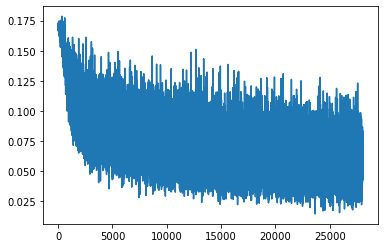

------
  
kernel: 32
  
*********
29459 3432
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29459 461
Loss:  0.1695123016834259
Loss:  0.16481846570968628
Loss:  0.15159659087657928
0 **********
Epoch:  52.95441007614136  fold:  1  kers:  32
epoch:  1
29459 461
Loss:  0.152180477976799
Loss:  0.12236005812883377
Loss:  0.16918213665485382
1 **********
Epoch:  93.41821956634521  fold:  1  kers:  32
epoch:  2
29459 461
Loss:  0.10341968387365341
Loss:  0.09778666496276855
Loss:  0.11633370071649551
2 **********
Epoch:  133.82019186019897  fold:  1  kers:  32
epoch:  3
Eval Loss:  0.3586723804473877
Eval Loss:  0.6129983067512512
Eval Loss:  0.2733783721923828
[[ 828  211]
 [ 736 1657]]
             

Loss:  0.08942991495132446
Loss:  0.07705748081207275
Loss:  0.1025942713022232
11 **********
Epoch:  620.3273701667786  fold:  1  kers:  32
epoch:  12
Eval Loss:  0.5114045739173889
Eval Loss:  0.638573408126831
Eval Loss:  0.09567651152610779
[[ 868  171]
 [ 686 1707]]
              precision    recall  f1-score   support

           0       0.56      0.84      0.67      1039
           1       0.91      0.71      0.80      2393

    accuracy                           0.75      3432
   macro avg       0.73      0.77      0.73      3432
weighted avg       0.80      0.75      0.76      3432

acc:  0.7502913752913752
pre:  0.9089456869009584
rec:  0.7133305474300041
ma F1:  0.7344196047514773
mi F1:  0.7502913752913752
we F1:  0.7600338804499538
Eval Loss:  0.399188756942749
Eval Loss:  0.2679652273654938
Eval Loss:  0.24416305124759674
Eval Loss:  0.3595583438873291
Eval Loss:  0.27105891704559326
Eval Loss:  0.38048043847084045
Eval Loss:  0.3240828216075897
Eval Loss:  0.285956382751

Eval Loss:  0.36767926812171936
Eval Loss:  0.28821074962615967
Eval Loss:  0.21910563111305237
Eval Loss:  0.317564457654953
Eval Loss:  0.2566879093647003
Eval Loss:  0.34638068079948425
Eval Loss:  0.27647092938423157
Eval Loss:  0.2704722285270691
Eval Loss:  0.23810738325119019
Eval Loss:  0.3159959316253662
Eval Loss:  0.23639345169067383
Eval Loss:  0.3229014575481415
Eval Loss:  0.32784751057624817
Eval Loss:  0.2877843379974365
Eval Loss:  0.16370433568954468
Eval Loss:  0.3902096450328827
Eval Loss:  0.2870916426181793
Eval Loss:  0.3090827167034149
Eval Loss:  0.3897625505924225
Eval Loss:  0.31886374950408936
Eval Loss:  0.28517967462539673
Eval Loss:  0.3219735622406006
Eval Loss:  0.25564083456993103
Eval Loss:  0.26044079661369324
Eval Loss:  0.2865397036075592
Eval Loss:  0.3566872477531433
Eval Loss:  0.247263103723526
Eval Loss:  0.3098176121711731
[[18198   927]
 [ 2589  7745]]
              precision    recall  f1-score   support

           0       0.88      0.95  

Eval Loss:  0.22220510244369507
Eval Loss:  0.20051182806491852
Eval Loss:  0.2532286047935486
Eval Loss:  0.3462589383125305
Eval Loss:  0.2520201802253723
Eval Loss:  0.2878022789955139
[[17738  1387]
 [ 1786  8548]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     19125
           1       0.86      0.83      0.84     10334

    accuracy                           0.89     29459
   macro avg       0.88      0.88      0.88     29459
weighted avg       0.89      0.89      0.89     29459

acc:  0.8922909806850199
pre:  0.8603925515853045
rec:  0.8271724404877104
ma F1:  0.8806788340791618
mi F1:  0.8922909806850198
we F1:  0.8917868189335795
29459 461
Loss:  0.049963176250457764
Loss:  0.05502123013138771
Loss:  0.08349441736936569
30 **********
Epoch:  1665.2923464775085  fold:  1  kers:  32
epoch:  31
29459 461
Loss:  0.06673333048820496
Loss:  0.08560891449451447
Loss:  0.0820816159248352
31 **********
Epoch:  1706.16406583786  fol

Loss:  0.06735371053218842
Loss:  0.07021297514438629
39 **********
Epoch:  2141.290623188019  fold:  1  kers:  32
epoch:  40
29459 461
Loss:  0.08471467345952988
Loss:  0.08128940314054489
Loss:  0.07916563749313354
40 **********
Epoch:  2181.1261115074158  fold:  1  kers:  32
epoch:  41
29459 461
Loss:  0.07231704890727997
Loss:  0.08289316296577454
Loss:  0.051704294979572296
41 **********
Epoch:  2220.9745650291443  fold:  1  kers:  32
epoch:  42
Eval Loss:  1.4156230688095093
Eval Loss:  0.2680659890174866
Eval Loss:  0.10176968574523926
[[ 638  401]
 [ 257 2136]]
              precision    recall  f1-score   support

           0       0.71      0.61      0.66      1039
           1       0.84      0.89      0.87      2393

    accuracy                           0.81      3432
   macro avg       0.78      0.75      0.76      3432
weighted avg       0.80      0.81      0.80      3432

acc:  0.8082750582750583
pre:  0.841939298383918
rec:  0.8926034266610948
ma F1:  0.7631519662031

Eval Loss:  0.3070710599422455
Eval Loss:  0.28011780977249146
Eval Loss:  0.21780388057231903
Eval Loss:  0.2592089772224426
Eval Loss:  0.20653273165225983
Eval Loss:  0.29598963260650635
Eval Loss:  0.2592410147190094
Eval Loss:  0.22901056706905365
Eval Loss:  0.18969307839870453
Eval Loss:  0.27210673689842224
Eval Loss:  0.22885288298130035
Eval Loss:  0.2985284924507141
Eval Loss:  0.29649221897125244
Eval Loss:  0.18520419299602509
Eval Loss:  0.1735050231218338
Eval Loss:  0.3131623864173889
Eval Loss:  0.21913544833660126
Eval Loss:  0.2602398693561554
Eval Loss:  0.29879507422447205
Eval Loss:  0.2254631668329239
Eval Loss:  0.2391098290681839
Eval Loss:  0.2828913927078247
Eval Loss:  0.23098638653755188
Eval Loss:  0.19339615106582642
Eval Loss:  0.21917738020420074
Eval Loss:  0.3130594789981842
Eval Loss:  0.24735750257968903
Eval Loss:  0.25837603211402893
[[17427  1698]
 [ 1253  9081]]
              precision    recall  f1-score   support

           0       0.93      

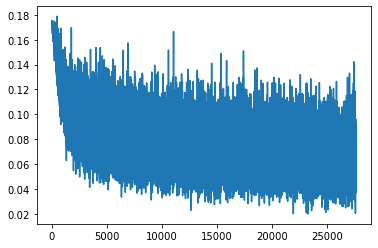

------
*********
29797 3094
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29797 466
Loss:  0.1690984070301056
Loss:  0.16431060433387756
Loss:  0.15625819563865662
0 **********
Epoch:  52.95042133331299  fold:  2  kers:  32
epoch:  1
29797 466
Loss:  0.13672767579555511
Loss:  0.14572565257549286
Loss:  0.11728215962648392
1 **********
Epoch:  93.61967968940735  fold:  2  kers:  32
epoch:  2
29797 466
Loss:  0.11041399836540222
Loss:  0.10108497738838196
Loss:  0.09581494331359863
2 **********
Epoch:  134.12437868118286  fold:  2  kers:  32
epoch:  3
Eval Loss:  0.7582769989967346
Eval Loss:  0.19716675579547882
Eval Loss:  0.7391063570976257
[[1108  322]
 [ 551 1113]]
              precision    

Loss:  0.07949399948120117
10 **********
Epoch:  572.1691365242004  fold:  2  kers:  32
epoch:  11
29797 466
Loss:  0.05890010669827461
Loss:  0.07743387669324875
Loss:  0.07552444934844971
11 **********
Epoch:  612.4434506893158  fold:  2  kers:  32
epoch:  12
Eval Loss:  0.8113768100738525
Eval Loss:  0.1518775075674057
Eval Loss:  0.7802050113677979
[[1280  150]
 [ 725  939]]
              precision    recall  f1-score   support

           0       0.64      0.90      0.75      1430
           1       0.86      0.56      0.68      1664

    accuracy                           0.72      3094
   macro avg       0.75      0.73      0.71      3094
weighted avg       0.76      0.72      0.71      3094

acc:  0.7171945701357466
pre:  0.8622589531680441
rec:  0.5643028846153846
ma F1:  0.7137170988800889
mi F1:  0.7171945701357465
we F1:  0.7113307989568517
Eval Loss:  0.3419007956981659
Eval Loss:  0.38500261306762695
Eval Loss:  0.2868098020553589
Eval Loss:  0.2564031183719635
Eval Loss:

Eval Loss:  0.3162219524383545
Eval Loss:  0.37156912684440613
Eval Loss:  0.272294819355011
Eval Loss:  0.23746134340763092
Eval Loss:  0.31475743651390076
Eval Loss:  0.35643622279167175
Eval Loss:  0.44016602635383606
Eval Loss:  0.3230508863925934
Eval Loss:  0.2523438036441803
Eval Loss:  0.211417555809021
Eval Loss:  0.19016972184181213
Eval Loss:  0.22719842195510864
Eval Loss:  0.3381022810935974
Eval Loss:  0.3911032974720001
Eval Loss:  0.24434591829776764
Eval Loss:  0.3377082645893097
Eval Loss:  0.28767260909080505
Eval Loss:  0.3311619460582733
Eval Loss:  0.26955360174179077
Eval Loss:  0.18330888450145721
Eval Loss:  0.28018417954444885
Eval Loss:  0.2637978792190552
Eval Loss:  0.3889639675617218
Eval Loss:  0.2540768086910248
Eval Loss:  0.2886628210544586
Eval Loss:  0.3358503580093384
Eval Loss:  0.2831975519657135
Eval Loss:  0.2805751860141754
Eval Loss:  0.4128580689430237
[[17827   907]
 [ 2653  8410]]
              precision    recall  f1-score   support

     

Eval Loss:  0.20624804496765137
Eval Loss:  0.2060263603925705
Eval Loss:  0.1561707705259323
Eval Loss:  0.20178447663784027
Eval Loss:  0.24042415618896484
Eval Loss:  0.35294780135154724
Eval Loss:  0.1879173368215561
Eval Loss:  0.27135998010635376
Eval Loss:  0.2502851188182831
Eval Loss:  0.21915516257286072
Eval Loss:  0.22519782185554504
Eval Loss:  0.2707417905330658
[[17302  1432]
 [ 1590  9473]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     18734
           1       0.87      0.86      0.86     11063

    accuracy                           0.90     29797
   macro avg       0.89      0.89      0.89     29797
weighted avg       0.90      0.90      0.90     29797

acc:  0.8985803939993959
pre:  0.8686840898670335
rec:  0.8562776823646389
ma F1:  0.8910597343641558
mi F1:  0.8985803939993959
we F1:  0.8984286167325204
29797 466
Loss:  0.1145050972700119
Loss:  0.07437979429960251
Loss:  0.055948406457901
30 **********
Epoch

Loss:  0.05454837158322334
Loss:  0.08508460968732834
Loss:  0.07957000285387039
39 **********
Epoch:  2132.9788477420807  fold:  2  kers:  32
epoch:  40
29797 466
Loss:  0.04686131328344345
Loss:  0.08819380402565002
Loss:  0.09269357472658157
40 **********
Epoch:  2173.3060224056244  fold:  2  kers:  32
epoch:  41
29797 466
Loss:  0.062274251133203506
Loss:  0.07609068602323532
Loss:  0.0716235488653183
41 **********
Epoch:  2213.6710934638977  fold:  2  kers:  32
epoch:  42
Eval Loss:  0.6229444742202759
Eval Loss:  0.5738768577575684
Eval Loss:  0.44580790400505066
[[1152  278]
 [ 459 1205]]
              precision    recall  f1-score   support

           0       0.72      0.81      0.76      1430
           1       0.81      0.72      0.77      1664

    accuracy                           0.76      3094
   macro avg       0.76      0.76      0.76      3094
weighted avg       0.77      0.76      0.76      3094

acc:  0.7617970265029088
pre:  0.8125421443020904
rec:  0.724158653846

Eval Loss:  0.22550562024116516
Eval Loss:  0.20988360047340393
Eval Loss:  0.2368190437555313
Eval Loss:  0.21087738871574402
Eval Loss:  0.2722356617450714
Eval Loss:  0.19598513841629028
Eval Loss:  0.29360756278038025
Eval Loss:  0.2062232792377472
Eval Loss:  0.16421329975128174
Eval Loss:  0.16753876209259033
Eval Loss:  0.13843227922916412
Eval Loss:  0.18904241919517517
Eval Loss:  0.26280948519706726
Eval Loss:  0.26742592453956604
Eval Loss:  0.2224465012550354
Eval Loss:  0.23251715302467346
Eval Loss:  0.17205536365509033
Eval Loss:  0.2253791093826294
Eval Loss:  0.2002469003200531
Eval Loss:  0.13728342950344086
Eval Loss:  0.19190067052841187
Eval Loss:  0.23278814554214478
Eval Loss:  0.37156620621681213
Eval Loss:  0.19643551111221313
Eval Loss:  0.18732640147209167
Eval Loss:  0.21931204199790955
Eval Loss:  0.20201840996742249
Eval Loss:  0.22028177976608276
Eval Loss:  0.23803094029426575
[[17635  1099]
 [ 1486  9577]]
              precision    recall  f1-score   s

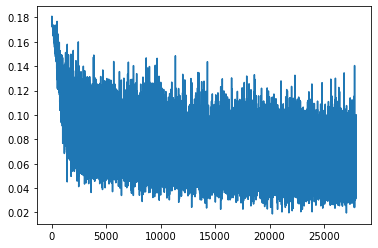

------
*********
29460 3431
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1675872653722763
Loss:  0.1671246588230133
Loss:  0.15941473841667175
0 **********
Epoch:  52.67814922332764  fold:  3  kers:  32
epoch:  1
29460 461
Loss:  0.14541420340538025
Loss:  0.1323988288640976
Loss:  0.11256350576877594
1 **********
Epoch:  92.92553520202637  fold:  3  kers:  32
epoch:  2
29460 461
Loss:  0.13562969863414764
Loss:  0.11308057606220245
Loss:  0.10611945390701294
2 **********
Epoch:  133.18788170814514  fold:  3  kers:  32
epoch:  3
Eval Loss:  0.7272236347198486
Eval Loss:  0.673554003238678
Eval Loss:  0.3889491558074951
[[1270  266]
 [ 473 1422]]
              precision    reca

Loss:  0.07455454766750336
Loss:  0.12604494392871857
11 **********
Epoch:  610.1705274581909  fold:  3  kers:  32
epoch:  12
Eval Loss:  0.7934590578079224
Eval Loss:  0.2689953148365021
Eval Loss:  0.5806889533996582
[[1345  191]
 [ 551 1344]]
              precision    recall  f1-score   support

           0       0.71      0.88      0.78      1536
           1       0.88      0.71      0.78      1895

    accuracy                           0.78      3431
   macro avg       0.79      0.79      0.78      3431
weighted avg       0.80      0.78      0.78      3431

acc:  0.7837365199650248
pre:  0.8755700325732899
rec:  0.7092348284960422
ma F1:  0.7837365015936444
mi F1:  0.7837365199650248
we F1:  0.7837299062681083
Eval Loss:  0.24444381892681122
Eval Loss:  0.2892440855503082
Eval Loss:  0.3346048593521118
Eval Loss:  0.3058546781539917
Eval Loss:  0.3655315935611725
Eval Loss:  0.3961889445781708
Eval Loss:  0.1646624356508255
Eval Loss:  0.34586790204048157
Eval Loss:  0.2237072

Eval Loss:  0.2504448890686035
Eval Loss:  0.3105735182762146
Eval Loss:  0.2552885413169861
Eval Loss:  0.3463059365749359
Eval Loss:  0.3413129150867462
Eval Loss:  0.13514173030853271
Eval Loss:  0.32195836305618286
Eval Loss:  0.1625760793685913
Eval Loss:  0.2798215448856354
Eval Loss:  0.25691068172454834
Eval Loss:  0.2526373565196991
Eval Loss:  0.2515827715396881
Eval Loss:  0.2653181552886963
Eval Loss:  0.27317410707473755
Eval Loss:  0.2689102292060852
Eval Loss:  0.26551175117492676
Eval Loss:  0.2586556375026703
Eval Loss:  0.3646198809146881
Eval Loss:  0.29842373728752136
Eval Loss:  0.2686706781387329
Eval Loss:  0.26563411951065063
Eval Loss:  0.3168564736843109
Eval Loss:  0.23834440112113953
Eval Loss:  0.22239509224891663
Eval Loss:  0.1877276450395584
Eval Loss:  0.2945851683616638
Eval Loss:  0.40614378452301025
[[17277  1351]
 [ 1961  8871]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91     18628
           1 

Eval Loss:  0.16446027159690857
Eval Loss:  0.3068813681602478
Eval Loss:  0.40096840262413025
[[17815   813]
 [ 2333  8499]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     18628
           1       0.91      0.78      0.84     10832

    accuracy                           0.89     29460
   macro avg       0.90      0.87      0.88     29460
weighted avg       0.89      0.89      0.89     29460

acc:  0.8932111337406653
pre:  0.9126932989690721
rec:  0.7846196454948301
ma F1:  0.8813459022416361
mi F1:  0.8932111337406653
we F1:  0.8912752007352419
29460 461
Loss:  0.05779321491718292
Loss:  0.053357236087322235
Loss:  0.09980518370866776
30 **********
Epoch:  1642.9002180099487  fold:  3  kers:  32
epoch:  31
29460 461
Loss:  0.04890536144375801
Loss:  0.05996665358543396
Loss:  0.06593218445777893
31 **********
Epoch:  1683.0408897399902  fold:  3  kers:  32
epoch:  32
29460 461
Loss:  0.08876468241214752
Loss:  0.0716217905282974

Loss:  0.05869140475988388
Loss:  0.05794068053364754
Loss:  0.08473675698041916
40 **********
Epoch:  2157.471359014511  fold:  3  kers:  32
epoch:  41
29460 461
Loss:  0.06119399145245552
Loss:  0.06694485992193222
Loss:  0.07815401256084442
41 **********
Epoch:  2197.483375310898  fold:  3  kers:  32
epoch:  42
Eval Loss:  0.6846288442611694
Eval Loss:  0.16337396204471588
Eval Loss:  1.0725332498550415
[[1264  272]
 [ 529 1366]]
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      1536
           1       0.83      0.72      0.77      1895

    accuracy                           0.77      3431
   macro avg       0.77      0.77      0.77      3431
weighted avg       0.78      0.77      0.77      3431

acc:  0.7665403672398717
pre:  0.833943833943834
rec:  0.720844327176781
ma F1:  0.7663338507622888
mi F1:  0.7665403672398717
we F1:  0.7670607077765271
Eval Loss:  0.21040578186511993
Eval Loss:  0.15167979896068573
Eval Loss:  0.2509

Eval Loss:  0.17607946693897247
Eval Loss:  0.14015834033489227
Eval Loss:  0.23690395057201385
Eval Loss:  0.2598654329776764
Eval Loss:  0.28760388493537903
Eval Loss:  0.2692286968231201
Eval Loss:  0.10277393460273743
Eval Loss:  0.32275864481925964
Eval Loss:  0.1348486691713333
Eval Loss:  0.22818578779697418
Eval Loss:  0.2251461148262024
Eval Loss:  0.2002735137939453
Eval Loss:  0.1906287521123886
Eval Loss:  0.2455805391073227
Eval Loss:  0.1928817629814148
Eval Loss:  0.21841928362846375
Eval Loss:  0.22598600387573242
Eval Loss:  0.19385991990566254
Eval Loss:  0.27510666847229004
Eval Loss:  0.22221046686172485
Eval Loss:  0.2263624668121338
Eval Loss:  0.212655708193779
Eval Loss:  0.22974476218223572
Eval Loss:  0.21373431384563446
Eval Loss:  0.22231537103652954
Eval Loss:  0.14058348536491394
Eval Loss:  0.23573070764541626
Eval Loss:  0.30352216958999634
[[17598  1030]
 [ 1582  9250]]
              precision    recall  f1-score   support

           0       0.92      

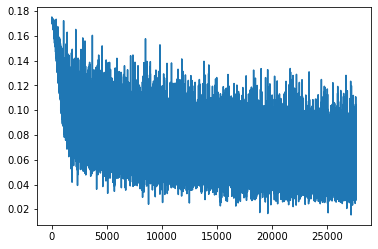

------
*********
29520 3371
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29520 462
Loss:  0.17169274389743805
Loss:  0.17060309648513794
Loss:  0.16269388794898987
0 **********
Epoch:  52.57442617416382  fold:  4  kers:  32
epoch:  1
29520 462
Loss:  0.15741461515426636
Loss:  0.14496074616909027
Loss:  0.1459670215845108
1 **********
Epoch:  92.92852783203125  fold:  4  kers:  32
epoch:  2
29520 462
Loss:  0.12698209285736084
Loss:  0.1529650241136551
Loss:  0.0959080308675766
2 **********
Epoch:  133.2058343887329  fold:  4  kers:  32
epoch:  3
Eval Loss:  0.5635963678359985
Eval Loss:  0.49351778626441956
Eval Loss:  0.10969050228595734
[[2593  544]
 [ 124  110]]
              precision    re

Loss:  0.10393727570772171
Loss:  0.08914520591497421
Loss:  0.10802017152309418
11 **********
Epoch:  607.90558385849  fold:  4  kers:  32
epoch:  12
Eval Loss:  0.09275508671998978
Eval Loss:  0.13558444380760193
Eval Loss:  0.04214762896299362
[[2993  144]
 [ 182   52]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3137
           1       0.27      0.22      0.24       234

    accuracy                           0.90      3371
   macro avg       0.60      0.59      0.60      3371
weighted avg       0.90      0.90      0.90      3371

acc:  0.9032927914565411
pre:  0.2653061224489796
rec:  0.2222222222222222
ma F1:  0.5951064049282282
mi F1:  0.9032927914565411
we F1:  0.8993107844221732
Eval Loss:  0.29725414514541626
Eval Loss:  0.3342241048812866
Eval Loss:  0.27198272943496704
Eval Loss:  0.33312663435935974
Eval Loss:  0.37837037444114685
Eval Loss:  0.3271375596523285
Eval Loss:  0.3053835928440094
Eval Loss:  0.35043343

Eval Loss:  0.27534666657447815
Eval Loss:  0.31993183493614197
Eval Loss:  0.27321746945381165
Eval Loss:  0.3213980495929718
Eval Loss:  0.35373541712760925
Eval Loss:  0.3123942017555237
Eval Loss:  0.3025669753551483
Eval Loss:  0.33559709787368774
Eval Loss:  0.31025782227516174
Eval Loss:  0.2783259153366089
Eval Loss:  0.37686705589294434
Eval Loss:  0.28776341676712036
Eval Loss:  0.28281068801879883
Eval Loss:  0.28254956007003784
Eval Loss:  0.27050670981407166
Eval Loss:  0.32637709379196167
Eval Loss:  0.2903114855289459
Eval Loss:  0.3357449769973755
Eval Loss:  0.25297442078590393
Eval Loss:  0.2643817365169525
Eval Loss:  0.36663201451301575
Eval Loss:  0.32051169872283936
Eval Loss:  0.34010106325149536
Eval Loss:  0.313626229763031
Eval Loss:  0.3587580919265747
Eval Loss:  0.2899727523326874
Eval Loss:  0.3448635935783386
Eval Loss:  0.28772035241127014
[[15988  1039]
 [ 2650  9843]]
              precision    recall  f1-score   support

           0       0.86      0

Eval Loss:  0.23016276955604553
Eval Loss:  0.3406358063220978
Eval Loss:  0.26663824915885925
Eval Loss:  0.2918689250946045
Eval Loss:  0.21405363082885742
[[15666  1361]
 [ 1826 10667]]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     17027
           1       0.89      0.85      0.87     12493

    accuracy                           0.89     29520
   macro avg       0.89      0.89      0.89     29520
weighted avg       0.89      0.89      0.89     29520

acc:  0.8920392953929539
pre:  0.8868473561689392
rec:  0.8538381493636437
ma F1:  0.8888519024952636
mi F1:  0.8920392953929539
we F1:  0.8917428085561014
29520 462
Loss:  0.08190654963254929
Loss:  0.056709300726652145
Loss:  0.06303080916404724
30 **********
Epoch:  1634.342101573944  fold:  4  kers:  32
epoch:  31
29520 462
Loss:  0.05203050374984741
Loss:  0.08380214869976044
Loss:  0.07272748649120331
31 **********
Epoch:  1674.450858592987  fold:  4  kers:  32
epoch:  32
2

Loss:  0.055372439324855804
39 **********
Epoch:  2113.862960100174  fold:  4  kers:  32
epoch:  40
29520 462
Loss:  0.07681319862604141
Loss:  0.04616314172744751
Loss:  0.06348969042301178
40 **********
Epoch:  2153.927834033966  fold:  4  kers:  32
epoch:  41
29520 462
Loss:  0.044179268181324005
Loss:  0.06695231795310974
Loss:  0.06796777993440628
41 **********
Epoch:  2193.960794210434  fold:  4  kers:  32
epoch:  42
Eval Loss:  0.0524374358355999
Eval Loss:  0.18734188377857208
Eval Loss:  0.047544896602630615
[[2965  172]
 [ 165   69]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3137
           1       0.29      0.29      0.29       234

    accuracy                           0.90      3371
   macro avg       0.62      0.62      0.62      3371
weighted avg       0.90      0.90      0.90      3371

acc:  0.9000296647878968
pre:  0.2863070539419087
rec:  0.2948717948717949
ma F1:  0.6183762901749347
mi F1:  0.90002966478

Eval Loss:  0.2962404787540436
Eval Loss:  0.2720837891101837
Eval Loss:  0.20700816810131073
Eval Loss:  0.23987461626529694
Eval Loss:  0.2672366797924042
Eval Loss:  0.2198927253484726
Eval Loss:  0.24987955391407013
Eval Loss:  0.2875802218914032
Eval Loss:  0.23154747486114502
Eval Loss:  0.2442813664674759
Eval Loss:  0.29173919558525085
Eval Loss:  0.19266191124916077
Eval Loss:  0.1686248928308487
Eval Loss:  0.21729350090026855
Eval Loss:  0.18758529424667358
Eval Loss:  0.33118724822998047
Eval Loss:  0.2668026387691498
Eval Loss:  0.24490775167942047
Eval Loss:  0.21627481281757355
Eval Loss:  0.29524385929107666
Eval Loss:  0.2575145363807678
Eval Loss:  0.24461543560028076
Eval Loss:  0.3022816777229309
Eval Loss:  0.19306610524654388
Eval Loss:  0.3389217257499695
Eval Loss:  0.2577657103538513
Eval Loss:  0.28021544218063354
Eval Loss:  0.19601911306381226
[[15354  1673]
 [ 1345 11148]]
              precision    recall  f1-score   support

           0       0.92      0

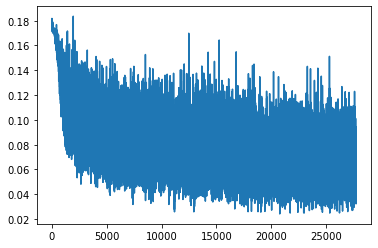

------
*********
29673 3218
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29673 464
Loss:  0.16830240190029144
Loss:  0.16291935741901398
Loss:  0.15809711813926697
0 **********
Epoch:  52.832735538482666  fold:  5  kers:  32
epoch:  1
29673 464
Loss:  0.17036214470863342
Loss:  0.14218732714653015
Loss:  0.12717944383621216
1 **********
Epoch:  93.32845830917358  fold:  5  kers:  32
epoch:  2
29673 464
Loss:  0.13240548968315125
Loss:  0.11321613937616348
Loss:  0.11900549381971359
2 **********
Epoch:  133.79625582695007  fold:  5  kers:  32
epoch:  3
Eval Loss:  0.18907514214515686
Eval Loss:  0.3741367757320404
Eval Loss:  0.4294656217098236
[[2648  449]
 [  35   86]]
              precision  

Loss:  0.09249769151210785
Loss:  0.06517758220434189
10 **********
Epoch:  571.4520530700684  fold:  5  kers:  32
epoch:  11
29673 464
Loss:  0.1068514958024025
Loss:  0.09129149466753006
Loss:  0.08779053390026093
11 **********
Epoch:  611.7931895256042  fold:  5  kers:  32
epoch:  12
Eval Loss:  0.09839770197868347
Eval Loss:  0.19678306579589844
Eval Loss:  0.12217523902654648
[[3019   78]
 [  41   80]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3097
           1       0.51      0.66      0.57       121

    accuracy                           0.96      3218
   macro avg       0.75      0.82      0.78      3218
weighted avg       0.97      0.96      0.97      3218

acc:  0.9630205096333126
pre:  0.5063291139240507
rec:  0.6611570247933884
ma F1:  0.7770745539505985
mi F1:  0.9630205096333128
we F1:  0.9653614420457864
update!  Acc:  0.9630205096333126
Eval Loss:  0.47680628299713135
Eval Loss:  0.33476653695106506
Eval Los


acc:  0.9661280298321939
pre:  0.536144578313253
rec:  0.7355371900826446
ma F1:  0.8012412998232623
mi F1:  0.9661280298321939
we F1:  0.9686595558814609
Eval Loss:  0.3404600918292999
Eval Loss:  0.2937578558921814
Eval Loss:  0.3402555584907532
Eval Loss:  0.35018742084503174
Eval Loss:  0.3661177158355713
Eval Loss:  0.27879950404167175
Eval Loss:  0.29839181900024414
Eval Loss:  0.23730474710464478
Eval Loss:  0.26008695363998413
Eval Loss:  0.33648744225502014
Eval Loss:  0.2819790840148926
Eval Loss:  0.2877807021141052
Eval Loss:  0.2651645243167877
Eval Loss:  0.2965349555015564
Eval Loss:  0.29919564723968506
Eval Loss:  0.3149354159832001
Eval Loss:  0.3723647892475128
Eval Loss:  0.44235360622406006
Eval Loss:  0.392849862575531
Eval Loss:  0.29737991094589233
Eval Loss:  0.3061360716819763
Eval Loss:  0.37208375334739685
Eval Loss:  0.34572163224220276
Eval Loss:  0.35220056772232056
Eval Loss:  0.3984817862510681
Eval Loss:  0.2986758053302765
Eval Loss:  0.3192319869995

Eval Loss:  0.27230405807495117
Eval Loss:  0.31120339035987854
Eval Loss:  0.32755687832832336
Eval Loss:  0.3858562707901001
Eval Loss:  0.36652645468711853
Eval Loss:  0.25621944665908813
Eval Loss:  0.27922213077545166
Eval Loss:  0.339333713054657
Eval Loss:  0.31234729290008545
Eval Loss:  0.2892630994319916
Eval Loss:  0.3834526240825653
Eval Loss:  0.29149264097213745
Eval Loss:  0.29450663924217224
Eval Loss:  0.33815404772758484
Eval Loss:  0.2554655373096466
[[16132   935]
 [ 2747  9859]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     17067
           1       0.91      0.78      0.84     12606

    accuracy                           0.88     29673
   macro avg       0.88      0.86      0.87     29673
weighted avg       0.88      0.88      0.87     29673

acc:  0.8759141306912007
pre:  0.9133778024828608
rec:  0.7820878946533397
ma F1:  0.870109073867211
mi F1:  0.8759141306912007
we F1:  0.8742372993561028
29673 464
Los

Loss:  0.06743041425943375
Loss:  0.09933029860258102
Loss:  0.04733743146061897
39 **********
Epoch:  2116.6534984111786  fold:  5  kers:  32
epoch:  40
29673 464
Loss:  0.07694929838180542
Loss:  0.08940388262271881
Loss:  0.08736317604780197
40 **********
Epoch:  2156.9697012901306  fold:  5  kers:  32
epoch:  41
29673 464
Loss:  0.056445807218551636
Loss:  0.07661087810993195
Loss:  0.06607086211442947
41 **********
Epoch:  2197.189162492752  fold:  5  kers:  32
epoch:  42
Eval Loss:  0.07680355757474899
Eval Loss:  0.1410830318927765
Eval Loss:  0.03893539309501648
[[3030   67]
 [  29   92]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3097
           1       0.58      0.76      0.66       121

    accuracy                           0.97      3218
   macro avg       0.78      0.87      0.82      3218
weighted avg       0.98      0.97      0.97      3218

acc:  0.9701678060907396
pre:  0.5786163522012578
rec:  0.76033057851


acc:  0.9695463020509634
pre:  0.56353591160221
rec:  0.8429752066115702
ma F1:  0.829760082225442
mi F1:  0.9695463020509634
we F1:  0.9724225617181551
Eval Loss:  0.2904810905456543
Eval Loss:  0.30909645557403564
Eval Loss:  0.23614172637462616
Eval Loss:  0.29257509112358093
Eval Loss:  0.2533953785896301
Eval Loss:  0.3300614655017853
Eval Loss:  0.19249001145362854
Eval Loss:  0.2356046438217163
Eval Loss:  0.1962268352508545
Eval Loss:  0.28566622734069824
Eval Loss:  0.29515793919563293
Eval Loss:  0.2687050402164459
Eval Loss:  0.2382906973361969
Eval Loss:  0.27182188630104065
Eval Loss:  0.17075009644031525
Eval Loss:  0.24978747963905334
Eval Loss:  0.2794484794139862
Eval Loss:  0.2938348948955536
Eval Loss:  0.366883784532547
Eval Loss:  0.24590997397899628
Eval Loss:  0.28582724928855896
Eval Loss:  0.2884296476840973
Eval Loss:  0.25225454568862915
Eval Loss:  0.2757177948951721
Eval Loss:  0.344723105430603
Eval Loss:  0.30505135655403137
Eval Loss:  0.209357574582099

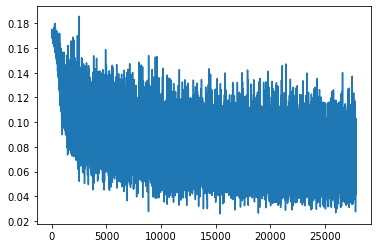

------
*********
29479 3412
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29479 461
Loss:  0.1669381707906723
Loss:  0.16035740077495575
Loss:  0.15638500452041626
0 **********
Epoch:  52.472697496414185  fold:  6  kers:  32
epoch:  1
29479 461
Loss:  0.16268840432167053
Loss:  0.1470639407634735
Loss:  0.14735561609268188
1 **********
Epoch:  92.67021799087524  fold:  6  kers:  32
epoch:  2
29479 461
Loss:  0.12202213704586029
Loss:  0.12789148092269897
Loss:  0.12835170328617096
2 **********
Epoch:  132.77498531341553  fold:  6  kers:  32
epoch:  3
Eval Loss:  0.1271962672472
Eval Loss:  0.2539255619049072
Eval Loss:  0.5477715730667114
[[1732  500]
 [  86 1094]]
              precision    reca

Loss:  0.12558789551258087
Loss:  0.08355405181646347
Loss:  0.13040047883987427
11 **********
Epoch:  607.5036571025848  fold:  6  kers:  32
epoch:  12
Eval Loss:  0.04280088096857071
Eval Loss:  0.19903819262981415
Eval Loss:  0.47215691208839417
[[2047  185]
 [ 186  994]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      2232
           1       0.84      0.84      0.84      1180

    accuracy                           0.89      3412
   macro avg       0.88      0.88      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8912661195779601
pre:  0.8430873621713316
rec:  0.8423728813559322
ma F1:  0.8798196324196438
mi F1:  0.89126611957796
we F1:  0.8912552492197852
update!  Acc:  0.8912661195779601
Eval Loss:  0.4468103349208832
Eval Loss:  0.4114939868450165
Eval Loss:  0.42603668570518494
Eval Loss:  0.3666967451572418
Eval Loss:  0.5131515860557556
Eval Loss:  0.3609198331832886
Eval Loss:  0.45702534

Eval Loss:  0.40064677596092224
Eval Loss:  0.3865896761417389
Eval Loss:  0.35647904872894287
Eval Loss:  0.31873390078544617
Eval Loss:  0.4632824659347534
Eval Loss:  0.2892701327800751
Eval Loss:  0.38811197876930237
Eval Loss:  0.3225443661212921
Eval Loss:  0.27290043234825134
Eval Loss:  0.2990944981575012
Eval Loss:  0.2698723077774048
Eval Loss:  0.3960877060890198
Eval Loss:  0.36293429136276245
Eval Loss:  0.3385876417160034
Eval Loss:  0.30137747526168823
Eval Loss:  0.29092973470687866
Eval Loss:  0.30896875262260437
Eval Loss:  0.3612384498119354
Eval Loss:  0.41222497820854187
Eval Loss:  0.32672926783561707
Eval Loss:  0.28722476959228516
Eval Loss:  0.2589169144630432
Eval Loss:  0.34910523891448975
Eval Loss:  0.3397988975048065
Eval Loss:  0.39910566806793213
Eval Loss:  0.3202921152114868
Eval Loss:  0.2733117341995239
Eval Loss:  0.20276173949241638
[[17028   904]
 [ 2763  8784]]
              precision    recall  f1-score   support

           0       0.86      0.

Eval Loss:  0.255946546792984
Eval Loss:  0.24712912738323212
Eval Loss:  0.2770286500453949
Eval Loss:  0.3144119381904602
Eval Loss:  0.34852027893066406
Eval Loss:  0.2987152338027954
Eval Loss:  0.23608741164207458
Eval Loss:  0.17343659698963165
[[16984   948]
 [ 2380  9167]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     17932
           1       0.91      0.79      0.85     11547

    accuracy                           0.89     29479
   macro avg       0.89      0.87      0.88     29479
weighted avg       0.89      0.89      0.89     29479

acc:  0.887106075511381
pre:  0.906277805239743
rec:  0.7938858577985624
ma F1:  0.8785674102819334
mi F1:  0.887106075511381
we F1:  0.8855418733099522
29479 461
Loss:  0.09146968275308609
Loss:  0.10784769058227539
Loss:  0.046613238751888275
30 **********
Epoch:  1632.5947721004486  fold:  6  kers:  32
epoch:  31
29479 461
Loss:  0.06655286997556686
Loss:  0.09289909154176712
Loss:  0.

Loss:  0.07743362337350845
Loss:  0.07718627154827118
Loss:  0.06395892053842545
39 **********
Epoch:  2106.2293696403503  fold:  6  kers:  32
epoch:  40
29479 461
Loss:  0.05533541366457939
Loss:  0.048227302730083466
Loss:  0.05041952058672905
40 **********
Epoch:  2146.2164521217346  fold:  6  kers:  32
epoch:  41
29479 461
Loss:  0.0855097696185112
Loss:  0.055482834577560425
Loss:  0.05528482422232628
41 **********
Epoch:  2186.1277375221252  fold:  6  kers:  32
epoch:  42
Eval Loss:  0.019794713705778122
Eval Loss:  0.2282472401857376
Eval Loss:  0.5297963619232178
[[2141   91]
 [ 275  905]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      2232
           1       0.91      0.77      0.83      1180

    accuracy                           0.89      3412
   macro avg       0.90      0.86      0.88      3412
weighted avg       0.89      0.89      0.89      3412

acc:  0.8927315357561547
pre:  0.9086345381526104
rec:  0.7669491525

Eval Loss:  0.3402172923088074
Eval Loss:  0.35846441984176636
Eval Loss:  0.27365466952323914
Eval Loss:  0.2656676471233368
Eval Loss:  0.33998653292655945
Eval Loss:  0.23994655907154083
Eval Loss:  0.2933628261089325
Eval Loss:  0.2063935101032257
Eval Loss:  0.23566250503063202
Eval Loss:  0.20561844110488892
Eval Loss:  0.21721181273460388
Eval Loss:  0.3473125100135803
Eval Loss:  0.29515978693962097
Eval Loss:  0.24167564511299133
Eval Loss:  0.219988152384758
Eval Loss:  0.24074670672416687
Eval Loss:  0.22936847805976868
Eval Loss:  0.29447218775749207
Eval Loss:  0.39172330498695374
Eval Loss:  0.19931665062904358
Eval Loss:  0.22789376974105835
Eval Loss:  0.2422720044851303
Eval Loss:  0.24519549310207367
Eval Loss:  0.250497043132782
Eval Loss:  0.2932853698730469
Eval Loss:  0.24355995655059814
Eval Loss:  0.2223125547170639
Eval Loss:  0.1423850655555725
[[16987   945]
 [ 1926  9621]]
              precision    recall  f1-score   support

           0       0.90      0.

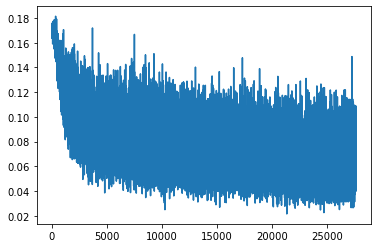

------
*********
29460 3431
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29460 461
Loss:  0.1720663607120514
Loss:  0.17102330923080444
Loss:  0.1541113257408142
0 **********
Epoch:  52.7240264415741  fold:  7  kers:  32
epoch:  1
29460 461
Loss:  0.14686165750026703
Loss:  0.14242877066135406
Loss:  0.1145084947347641
1 **********
Epoch:  93.60970664024353  fold:  7  kers:  32
epoch:  2
29460 461
Loss:  0.11058245599269867
Loss:  0.11829443275928497
Loss:  0.10378380119800568
2 **********
Epoch:  133.5898072719574  fold:  7  kers:  32
epoch:  3
Eval Loss:  0.8645037412643433
Eval Loss:  0.15057526528835297
Eval Loss:  1.9303512573242188
[[1665  462]
 [ 702  602]]
              precision    reca

Loss:  0.08886727690696716
Loss:  0.08813054114580154
Loss:  0.08313383162021637
11 **********
Epoch:  614.7183680534363  fold:  7  kers:  32
epoch:  12
Eval Loss:  0.6123225092887878
Eval Loss:  0.13664844632148743
Eval Loss:  2.8070995807647705
[[2000  127]
 [ 819  485]]
              precision    recall  f1-score   support

           0       0.71      0.94      0.81      2127
           1       0.79      0.37      0.51      1304

    accuracy                           0.72      3431
   macro avg       0.75      0.66      0.66      3431
weighted avg       0.74      0.72      0.69      3431

acc:  0.7242786359661906
pre:  0.7924836601307189
rec:  0.37193251533742333
ma F1:  0.6574986893945214
mi F1:  0.7242786359661906
we F1:  0.6937758484892302
update!  Acc:  0.7242786359661906
Eval Loss:  0.4091890752315521
Eval Loss:  0.3528442084789276
Eval Loss:  0.3273828327655792
Eval Loss:  0.5005643963813782
Eval Loss:  0.32824867963790894
Eval Loss:  0.28982865810394287
Eval Loss:  0.266667

Eval Loss:  0.3364470303058624
Eval Loss:  0.31912335753440857
Eval Loss:  0.3060362935066223
Eval Loss:  0.4336065351963043
Eval Loss:  0.27703410387039185
Eval Loss:  0.24121014773845673
Eval Loss:  0.22894063591957092
Eval Loss:  0.26537609100341797
Eval Loss:  0.34022897481918335
Eval Loss:  0.4124031662940979
Eval Loss:  0.4449591040611267
Eval Loss:  0.28774985671043396
Eval Loss:  0.26391032338142395
Eval Loss:  0.24536877870559692
Eval Loss:  0.23060698807239532
Eval Loss:  0.2628479599952698
Eval Loss:  0.318292498588562
Eval Loss:  0.3174281418323517
Eval Loss:  0.23141787946224213
Eval Loss:  0.3612464964389801
Eval Loss:  0.22570167481899261
Eval Loss:  0.32233110070228577
Eval Loss:  0.26089149713516235
Eval Loss:  0.25660955905914307
Eval Loss:  0.19513483345508575
Eval Loss:  0.33832883834838867
Eval Loss:  0.20378604531288147
Eval Loss:  0.3387633264064789
[[16956  1081]
 [ 2366  9057]]
              precision    recall  f1-score   support

           0       0.88      

Eval Loss:  0.2866368591785431
Eval Loss:  0.24318505823612213
Eval Loss:  0.2298915982246399
Eval Loss:  0.17645077407360077
Eval Loss:  0.34142524003982544
Eval Loss:  0.22523921728134155
Eval Loss:  0.29044026136398315
[[17155   882]
 [ 2404  9019]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     18037
           1       0.91      0.79      0.85     11423

    accuracy                           0.89     29460
   macro avg       0.89      0.87      0.88     29460
weighted avg       0.89      0.89      0.89     29460

acc:  0.888458927359131
pre:  0.910918089081911
rec:  0.7895474043596253
ma F1:  0.8792492083144658
mi F1:  0.888458927359131
we F1:  0.8867360669380419
29460 461
Loss:  0.07641526311635971
Loss:  0.0567915216088295
Loss:  0.0847930908203125
30 **********
Epoch:  1657.409423828125  fold:  7  kers:  32
epoch:  31
29460 461
Loss:  0.04670790955424309
Loss:  0.07037961483001709
Loss:  0.0852571427822113
31 **********
Ep

Loss:  0.07401853054761887
Loss:  0.082636259496212
Loss:  0.04331057891249657
39 **********
Epoch:  2137.495770215988  fold:  7  kers:  32
epoch:  40
29460 461
Loss:  0.05305124819278717
Loss:  0.07634451240301132
Loss:  0.043196022510528564
40 **********
Epoch:  2177.7770664691925  fold:  7  kers:  32
epoch:  41
29460 461
Loss:  0.06504262238740921
Loss:  0.07074037194252014
Loss:  0.07484444230794907
41 **********
Epoch:  2218.186021089554  fold:  7  kers:  32
epoch:  42
Eval Loss:  0.5484554171562195
Eval Loss:  0.21869656443595886
Eval Loss:  2.126612901687622
[[1983  144]
 [ 663  641]]
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      2127
           1       0.82      0.49      0.61      1304

    accuracy                           0.76      3431
   macro avg       0.78      0.71      0.72      3431
weighted avg       0.77      0.76      0.75      3431

acc:  0.7647916059457884
pre:  0.8165605095541402
rec:  0.4915644171779141

Eval Loss:  0.20839864015579224
Eval Loss:  0.21898579597473145
Eval Loss:  0.24917641282081604
Eval Loss:  0.3224797546863556
Eval Loss:  0.1699645072221756
Eval Loss:  0.16900788247585297
Eval Loss:  0.14573019742965698
Eval Loss:  0.2035195380449295
Eval Loss:  0.31535977125167847
Eval Loss:  0.3159222900867462
Eval Loss:  0.3678947985172272
Eval Loss:  0.22905674576759338
Eval Loss:  0.1676640659570694
Eval Loss:  0.20781169831752777
Eval Loss:  0.1730290651321411
Eval Loss:  0.2081317901611328
Eval Loss:  0.2545231878757477
Eval Loss:  0.2408493012189865
Eval Loss:  0.22017574310302734
Eval Loss:  0.28619393706321716
Eval Loss:  0.1796129196882248
Eval Loss:  0.25747573375701904
Eval Loss:  0.17760206758975983
Eval Loss:  0.19596710801124573
Eval Loss:  0.13774530589580536
Eval Loss:  0.26150795817375183
Eval Loss:  0.1482369750738144
Eval Loss:  0.25676092505455017
[[16810  1227]
 [ 1390 10033]]
              precision    recall  f1-score   support

           0       0.92      0

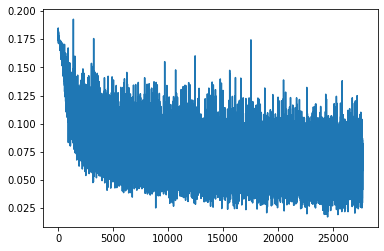

------
*********
29817 3074
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29817 466
Loss:  0.17242908477783203
Loss:  0.16599810123443604
Loss:  0.15534013509750366
0 **********
Epoch:  53.72335433959961  fold:  8  kers:  32
epoch:  1
29817 466
Loss:  0.13055068254470825
Loss:  0.12701182067394257
Loss:  0.11771104484796524
1 **********
Epoch:  94.92518925666809  fold:  8  kers:  32
epoch:  2
29817 466
Loss:  0.11892218887805939
Loss:  0.10801909863948822
Loss:  0.10362665355205536
2 **********
Epoch:  140.6708745956421  fold:  8  kers:  32
epoch:  3
Eval Loss:  0.27103912830352783
Eval Loss:  1.3562124967575073
Eval Loss:  0.1909499168395996
[[1913  160]
 [ 534  467]]
              precision    

10 **********
Epoch:  583.9925224781036  fold:  8  kers:  32
epoch:  11
29817 466
Loss:  0.08598127216100693
Loss:  0.06887857615947723
Loss:  0.06383305042982101
11 **********
Epoch:  624.444363117218  fold:  8  kers:  32
epoch:  12
Eval Loss:  0.23302066326141357
Eval Loss:  1.904443621635437
Eval Loss:  0.10745403170585632
[[1940  133]
 [ 510  491]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86      2073
           1       0.79      0.49      0.60      1001

    accuracy                           0.79      3074
   macro avg       0.79      0.71      0.73      3074
weighted avg       0.79      0.79      0.78      3074

acc:  0.7908262849707222
pre:  0.7868589743589743
rec:  0.4905094905094905
ma F1:  0.7310727053181176
mi F1:  0.7908262849707222
we F1:  0.7752796324317078
Eval Loss:  0.3983630836009979
Eval Loss:  0.3148604929447174
Eval Loss:  0.340827077627182
Eval Loss:  0.3474346697330475
Eval Loss:  0.3485349416732788
Eval Los

Eval Loss:  0.35082218050956726
Eval Loss:  0.30944395065307617
Eval Loss:  0.2944360375404358
Eval Loss:  0.32869336009025574
Eval Loss:  0.3224470615386963
Eval Loss:  0.33072760701179504
Eval Loss:  0.3776947259902954
Eval Loss:  0.3528378903865814
Eval Loss:  0.35981401801109314
Eval Loss:  0.2750122547149658
Eval Loss:  0.3187558352947235
Eval Loss:  0.311739981174469
Eval Loss:  0.33752450346946716
Eval Loss:  0.3516201674938202
Eval Loss:  0.32486435770988464
Eval Loss:  0.2763805389404297
Eval Loss:  0.3323095142841339
Eval Loss:  0.3284587264060974
Eval Loss:  0.33202388882637024
Eval Loss:  0.3735581338405609
Eval Loss:  0.19664312899112701
Eval Loss:  0.3837279975414276
Eval Loss:  0.380217045545578
Eval Loss:  0.223441481590271
Eval Loss:  0.3542422950267792
Eval Loss:  0.3402615785598755
Eval Loss:  0.22550156712532043
Eval Loss:  0.35047677159309387
Eval Loss:  0.3083023726940155
[[17243   848]
 [ 3010  8716]]
              precision    recall  f1-score   support

       

Eval Loss:  0.33671835064888
Eval Loss:  0.37365224957466125
Eval Loss:  0.19073523581027985
Eval Loss:  0.30160850286483765
Eval Loss:  0.32343024015426636
Eval Loss:  0.23171855509281158
Eval Loss:  0.3260328769683838
Eval Loss:  0.30497249960899353
[[17273   818]
 [ 2710  9016]]
              precision    recall  f1-score   support

           0       0.86      0.95      0.91     18091
           1       0.92      0.77      0.84     11726

    accuracy                           0.88     29817
   macro avg       0.89      0.86      0.87     29817
weighted avg       0.89      0.88      0.88     29817

acc:  0.881678237247208
pre:  0.9168191986983933
rec:  0.7688896469384274
ma F1:  0.8718509887444068
mi F1:  0.881678237247208
we F1:  0.8794264322130189
29817 466
Loss:  0.07894454896450043
Loss:  0.06479676067829132
Loss:  0.10780957341194153
30 **********
Epoch:  1659.4778926372528  fold:  8  kers:  32
epoch:  31
29817 466
Loss:  0.07148955762386322
Loss:  0.07016361504793167
Loss:  0

Loss:  0.09000716358423233
Loss:  0.08716876059770584
Loss:  0.09042911231517792
39 **********
Epoch:  2142.1742606163025  fold:  8  kers:  32
epoch:  40
29817 466
Loss:  0.08458680659532547
Loss:  0.06174501031637192
Loss:  0.06856139749288559
40 **********
Epoch:  2182.711871623993  fold:  8  kers:  32
epoch:  41
29817 466
Loss:  0.056432388722896576
Loss:  0.07995700091123581
Loss:  0.07912859320640564
41 **********
Epoch:  2223.111849784851  fold:  8  kers:  32
epoch:  42
Eval Loss:  0.4945870637893677
Eval Loss:  1.147483468055725
Eval Loss:  0.08401502668857574
[[1779  294]
 [ 318  683]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2073
           1       0.70      0.68      0.69      1001

    accuracy                           0.80      3074
   macro avg       0.77      0.77      0.77      3074
weighted avg       0.80      0.80      0.80      3074

acc:  0.8009108653220559
pre:  0.6990788126919141
rec:  0.68231768231768

Eval Loss:  0.2972568869590759
Eval Loss:  0.2729044258594513
Eval Loss:  0.20916804671287537
Eval Loss:  0.25419414043426514
Eval Loss:  0.32368624210357666
Eval Loss:  0.2617414891719818
Eval Loss:  0.2785322964191437
Eval Loss:  0.24725988507270813
Eval Loss:  0.29607638716697693
Eval Loss:  0.16446241736412048
Eval Loss:  0.22913867235183716
Eval Loss:  0.23458562791347504
Eval Loss:  0.2589762508869171
Eval Loss:  0.2204880714416504
Eval Loss:  0.26413995027542114
Eval Loss:  0.15143772959709167
Eval Loss:  0.2706441879272461
Eval Loss:  0.32583823800086975
Eval Loss:  0.27192422747612
Eval Loss:  0.2816621661186218
Eval Loss:  0.18492579460144043
Eval Loss:  0.2659026086330414
Eval Loss:  0.2955181896686554
Eval Loss:  0.16981543600559235
Eval Loss:  0.22444625198841095
Eval Loss:  0.2650230824947357
Eval Loss:  0.20123615860939026
Eval Loss:  0.2776359021663666
Eval Loss:  0.26501762866973877
[[16312  1779]
 [ 1303 10423]]
              precision    recall  f1-score   support

 

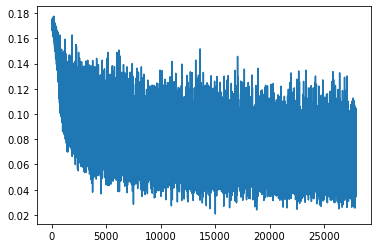

------
*********
29483 3408
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29483 461
Loss:  0.1714957058429718
Loss:  0.1684591919183731
Loss:  0.1543387919664383
0 **********
Epoch:  52.50561046600342  fold:  9  kers:  32
epoch:  1
29483 461
Loss:  0.14072570204734802
Loss:  0.14352916181087494
Loss:  0.12248067557811737
1 **********
Epoch:  92.70811700820923  fold:  9  kers:  32
epoch:  2
29483 461
Loss:  0.11106368154287338
Loss:  0.1093422919511795
Loss:  0.14534500241279602
2 **********
Epoch:  132.78595757484436  fold:  9  kers:  32
epoch:  3
Eval Loss:  0.2732778489589691
Eval Loss:  0.7347452044487
Eval Loss:  0.33621373772621155
[[1382  360]
 [ 289 1377]]
              precision    recall

Loss:  0.07448618859052658
Loss:  0.10143250226974487
11 **********
Epoch:  607.9564483165741  fold:  9  kers:  32
epoch:  12
Eval Loss:  0.08024517446756363
Eval Loss:  1.3441250324249268
Eval Loss:  0.19272801280021667
[[1567  175]
 [ 436 1230]]
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1742
           1       0.88      0.74      0.80      1666

    accuracy                           0.82      3408
   macro avg       0.83      0.82      0.82      3408
weighted avg       0.83      0.82      0.82      3408

acc:  0.8207159624413145
pre:  0.8754448398576512
rec:  0.7382953181272509
ma F1:  0.818945569018759
mi F1:  0.8207159624413144
we F1:  0.8193448268825995
update!  Acc:  0.8207159624413145
Eval Loss:  0.33903270959854126
Eval Loss:  0.3245067894458771
Eval Loss:  0.3669547140598297
Eval Loss:  0.3861923813819885
Eval Loss:  0.3221483826637268
Eval Loss:  0.4249260425567627
Eval Loss:  0.2933453917503357
Eval Loss:  0.3471

Eval Loss:  0.35240331292152405
Eval Loss:  0.28056448698043823
Eval Loss:  0.34829455614089966
Eval Loss:  0.34751978516578674
Eval Loss:  0.2989048659801483
Eval Loss:  0.3876599669456482
Eval Loss:  0.2747504711151123
Eval Loss:  0.3200196921825409
Eval Loss:  0.2910088002681732
Eval Loss:  0.24598997831344604
Eval Loss:  0.26208654046058655
Eval Loss:  0.32769325375556946
Eval Loss:  0.2921935021877289
Eval Loss:  0.3119409382343292
Eval Loss:  0.2568410336971283
Eval Loss:  0.3417680263519287
Eval Loss:  0.25938335061073303
Eval Loss:  0.3326084613800049
Eval Loss:  0.29774466156959534
Eval Loss:  0.279498428106308
Eval Loss:  0.27621689438819885
Eval Loss:  0.32754743099212646
Eval Loss:  0.32946887612342834
Eval Loss:  0.2277866154909134
Eval Loss:  0.26406073570251465
Eval Loss:  0.26863202452659607
Eval Loss:  0.24988293647766113
Eval Loss:  0.2639385461807251
[[16398  2024]
 [ 1699  9362]]
              precision    recall  f1-score   support

           0       0.91      0.8

Eval Loss:  0.26904627680778503
Eval Loss:  0.2715262174606323
Eval Loss:  0.2346225529909134
Eval Loss:  0.24716824293136597
[[16074  2348]
 [ 1369  9692]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     18422
           1       0.80      0.88      0.84     11061

    accuracy                           0.87     29483
   macro avg       0.86      0.87      0.87     29483
weighted avg       0.88      0.87      0.87     29483

acc:  0.873927347963233
pre:  0.804983388704319
rec:  0.8762318054425459
ma F1:  0.8677296148162206
mi F1:  0.873927347963233
we F1:  0.8748780813933372
29483 461
Loss:  0.09814250469207764
Loss:  0.07245664298534393
Loss:  0.04657784476876259
30 **********
Epoch:  1633.2440371513367  fold:  9  kers:  32
epoch:  31
29483 461
Loss:  0.05117911100387573
Loss:  0.0757884606719017
Loss:  0.06255996227264404
31 **********
Epoch:  1673.356784582138  fold:  9  kers:  32
epoch:  32
29483 461
Loss:  0.09006113559007645


Loss:  0.07571956515312195
Loss:  0.05652020499110222
39 **********
Epoch:  2107.863003015518  fold:  9  kers:  32
epoch:  40
29483 461
Loss:  0.08025147765874863
Loss:  0.08409100770950317
Loss:  0.08282167464494705
40 **********
Epoch:  2147.9069335460663  fold:  9  kers:  32
epoch:  41
29483 461
Loss:  0.06255243718624115
Loss:  0.07397117465734482
Loss:  0.06042403727769852
41 **********
Epoch:  2187.912964820862  fold:  9  kers:  32
epoch:  42
Eval Loss:  0.044081125408411026
Eval Loss:  1.274647831916809
Eval Loss:  0.15506847202777863
[[1606  136]
 [ 392 1274]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1742
           1       0.90      0.76      0.83      1666

    accuracy                           0.85      3408
   macro avg       0.85      0.84      0.84      3408
weighted avg       0.85      0.85      0.84      3408

acc:  0.8450704225352113
pre:  0.9035460992907801
rec:  0.7647058823529411
ma F1:  0.8435860169815

Eval Loss:  0.29639193415641785
Eval Loss:  0.1935940682888031
Eval Loss:  0.2761254608631134
Eval Loss:  0.22816671431064606
Eval Loss:  0.2622029781341553
Eval Loss:  0.29022252559661865
Eval Loss:  0.2274128496646881
Eval Loss:  0.3120228946208954
Eval Loss:  0.2526225745677948
Eval Loss:  0.22640694677829742
Eval Loss:  0.20060794055461884
Eval Loss:  0.2726430594921112
Eval Loss:  0.22778576612472534
Eval Loss:  0.23591721057891846
Eval Loss:  0.17445459961891174
Eval Loss:  0.3065841794013977
Eval Loss:  0.22678282856941223
Eval Loss:  0.24348406493663788
Eval Loss:  0.22419428825378418
Eval Loss:  0.2139347642660141
Eval Loss:  0.24962632358074188
Eval Loss:  0.2708234488964081
Eval Loss:  0.2762671411037445
Eval Loss:  0.16913709044456482
Eval Loss:  0.24240882694721222
Eval Loss:  0.21326974034309387
Eval Loss:  0.19931448996067047
Eval Loss:  0.23158888518810272
[[16688  1734]
 [ 1273  9788]]
              precision    recall  f1-score   support

           0       0.93      

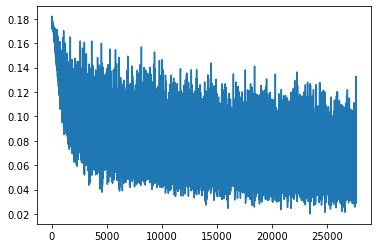

------
*********
29871 3020
Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
29871 467
Loss:  0.169640451669693
Loss:  0.16656850278377533
Loss:  0.1731136292219162
0 **********
Epoch:  52.99031376838684  fold:  10  kers:  32
epoch:  1
29871 467
Loss:  0.1441696733236313
Loss:  0.13974489271640778
Loss:  0.1330365687608719
1 **********
Epoch:  93.84208393096924  fold:  10  kers:  32
epoch:  2
29871 467
Loss:  0.12416573613882065
Loss:  0.10628906637430191
Loss:  0.10009294748306274
2 **********
Epoch:  134.54026579856873  fold:  10  kers:  32
epoch:  3
Eval Loss:  0.395693838596344
Eval Loss:  0.38932114839553833
Eval Loss:  0.2462034672498703
[[1465  286]
 [ 139 1130]]
              precision    re

Loss:  0.08429219573736191
10 **********
Epoch:  573.5743775367737  fold:  10  kers:  32
epoch:  11
29871 467
Loss:  0.08872663974761963
Loss:  0.09791704267263412
Loss:  0.1052226573228836
11 **********
Epoch:  613.9544098377228  fold:  10  kers:  32
epoch:  12
Eval Loss:  0.5289256572723389
Eval Loss:  0.12434698641300201
Eval Loss:  0.1512708216905594
[[1633  118]
 [ 206 1063]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1751
           1       0.90      0.84      0.87      1269

    accuracy                           0.89      3020
   macro avg       0.89      0.89      0.89      3020
weighted avg       0.89      0.89      0.89      3020

acc:  0.8927152317880794
pre:  0.9000846740050804
rec:  0.8376674546887313
ma F1:  0.8887522028309931
mi F1:  0.8927152317880794
we F1:  0.8921033957385643
Eval Loss:  0.34752362966537476
Eval Loss:  0.3224186897277832
Eval Loss:  0.3285823166370392
Eval Loss:  0.31869006156921387
Eval Lo

Eval Loss:  0.33556607365608215
Eval Loss:  0.32298028469085693
Eval Loss:  0.4044862687587738
Eval Loss:  0.2916210889816284
Eval Loss:  0.2909543216228485
Eval Loss:  0.29655006527900696
Eval Loss:  0.3474404513835907
Eval Loss:  0.3794025778770447
Eval Loss:  0.42402830719947815
Eval Loss:  0.2736643850803375
Eval Loss:  0.3081335425376892
Eval Loss:  0.31237998604774475
Eval Loss:  0.2704283893108368
Eval Loss:  0.3208325505256653
Eval Loss:  0.28115367889404297
Eval Loss:  0.31485623121261597
Eval Loss:  0.3831259310245514
Eval Loss:  0.24390938878059387
Eval Loss:  0.25800853967666626
Eval Loss:  0.4161835014820099
Eval Loss:  0.337375283241272
Eval Loss:  0.4474901258945465
Eval Loss:  0.3391026258468628
Eval Loss:  0.3069297969341278
Eval Loss:  0.4176749289035797
Eval Loss:  0.2539714574813843
Eval Loss:  0.3818112909793854
Eval Loss:  0.3757590055465698
Eval Loss:  0.32811999320983887
[[17657   756]
 [ 3375  8083]]
              precision    recall  f1-score   support

      

Eval Loss:  0.28975963592529297
Eval Loss:  0.40582406520843506
Eval Loss:  0.32254883646965027
Eval Loss:  0.25761404633522034
Eval Loss:  0.3416938781738281
Eval Loss:  0.23656535148620605
Eval Loss:  0.34883713722229004
Eval Loss:  0.3579941391944885
Eval Loss:  0.28738704323768616
[[17711   702]
 [ 3122  8336]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     18413
           1       0.92      0.73      0.81     11458

    accuracy                           0.87     29871
   macro avg       0.89      0.84      0.86     29871
weighted avg       0.88      0.87      0.87     29871

acc:  0.8719828596297412
pre:  0.9223279486612083
rec:  0.7275266189561879
ma F1:  0.8579951643515393
mi F1:  0.8719828596297412
we F1:  0.8683721692219281
29871 467
Loss:  0.07826873660087585
Loss:  0.05219455435872078
Loss:  0.09428860247135162
30 **********
Epoch:  1659.2066175937653  fold:  10  kers:  32
epoch:  31
29871 467
Loss:  0.0685444772243499

Loss:  0.06320483982563019
Loss:  0.05918306112289429
Loss:  0.07400435209274292
39 **********
Epoch:  2137.39603638649  fold:  10  kers:  32
epoch:  40
29871 467
Loss:  0.06274692714214325
Loss:  0.0686936005949974
Loss:  0.05842124670743942
40 **********
Epoch:  2177.825934648514  fold:  10  kers:  32
epoch:  41
29871 467
Loss:  0.07914551347494125
Loss:  0.081273652613163
Loss:  0.05207449942827225
41 **********
Epoch:  2218.1820306777954  fold:  10  kers:  32
epoch:  42
Eval Loss:  0.8249512314796448
Eval Loss:  0.0743083655834198
Eval Loss:  0.05782780051231384
[[1668   83]
 [ 414  855]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1751
           1       0.91      0.67      0.77      1269

    accuracy                           0.84      3020
   macro avg       0.86      0.81      0.82      3020
weighted avg       0.85      0.84      0.83      3020

acc:  0.8354304635761589
pre:  0.9115138592750534
rec:  0.673758865248226

Eval Loss:  0.22004541754722595
Eval Loss:  0.27915140986442566
Eval Loss:  0.3325948417186737
Eval Loss:  0.2564420700073242
Eval Loss:  0.22958482801914215
Eval Loss:  0.2732837200164795
Eval Loss:  0.27617815136909485
Eval Loss:  0.24148385226726532
Eval Loss:  0.3221961259841919
Eval Loss:  0.2517525553703308
Eval Loss:  0.20692095160484314
Eval Loss:  0.22507202625274658
Eval Loss:  0.237519770860672
Eval Loss:  0.24431225657463074
Eval Loss:  0.2382250428199768
Eval Loss:  0.25603237748146057
Eval Loss:  0.2913862466812134
Eval Loss:  0.18279671669006348
Eval Loss:  0.228830024600029
Eval Loss:  0.3431412875652313
Eval Loss:  0.2340104579925537
Eval Loss:  0.3040025234222412
Eval Loss:  0.2837056815624237
Eval Loss:  0.23930302262306213
Eval Loss:  0.308231920003891
Eval Loss:  0.2203110158443451
Eval Loss:  0.3078835904598236
Eval Loss:  0.27858713269233704
Eval Loss:  0.2293744683265686
[[17580   833]
 [ 2445  9013]]
              precision    recall  f1-score   support

      

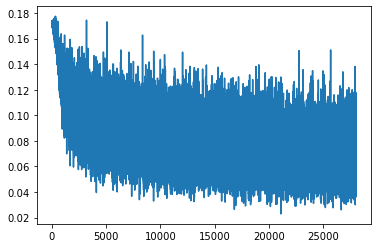

------


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time
for kers in [128,64,32]:
    print("  ")
    print("kernel:",kers)
    print("  ")
    for fold in range(1,11):
        begin=time()
        #train_rec,test_rec=reclist[train_idx],reclist[test_idx]
        train_dtlist,test_dtlist=getTrainTestList(reclist,opt='kfold',fold = fold)#fold 1-10   
        print('*********')

        train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
        np.random.shuffle(train_dtlist)
        test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
        print(len(train_dtlist),len(test_dtlist))
        model = MyLSTM(2,kers).to(device)

        #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                    # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                    #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    print(m,'init')
                else:
                    print('Not initializing')
        criterion=nn.CrossEntropyLoss().to(device)#weight=torch.FloatTensor([1,1.5])
        #criterion = CircleLoss(m=0.25, gamma=256)
        opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
        loss_list=[]

        opt.zero_grad()
        epoch_flag=0
        best_acc=0
        for epoch in range(60):
            print('epoch: ', epoch)
            if epoch_flag%3==0 and epoch_flag!=0:
                model.eval()
                prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
                if tmp_acc>best_acc:
                    best_acc=tmp_acc                   
                    res_file_name="./weights/fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,38)
                    res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
                    res_file.to_csv(res_file_name,index=False)
                    torch.save(model.state_dict(), "./weights/fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,38))
                    print("update! ",'Acc: ',best_acc)
                #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
                _,_,_,_=eval(model,train_dtlist,criterion,device)
                model.train()
            train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
            #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
            train_loader=DataLoader(train_dataset, batch_size=64, shuffle=True, sampler=None, num_workers=0)

            #test_loader=DataLoader(test_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
            print(len(train_dataset),len(train_loader)) #,len(test_dataset)
            flag=0
            accum_flag=0
            for fe, label,seg_id in train_loader:
                del seg_id
                fe=fe.float().to(device)
                #fe=(fe-fe_mean)/fe_std
                #fe=torch.stft(fe,100,hop_length=50,onesided=True)

                label=label.long().to(device)
                pred_prob_no_softmax=model(fe)
                loss=criterion(pred_prob_no_softmax,label)/4#/256
                del label
                del fe
                #inp_sp, inp_sn = convert_label_to_similarity(pred_prob_no_softmax,label)
                #loss = criterion(inp_sp, inp_sn)/256
                
                loss_list.append(loss.item())
                loss.backward()
                accum_flag+=1
                if accum_flag%4==0:
                    opt.step()
                    accum_flag=0
                    opt.zero_grad()
                flag+=1
                if flag%128==0:
                    print("Loss: ", loss.item())
                #print('step')
            print(epoch_flag,'*'*10)
            epoch_flag+=1
            #scheduler.step()
            print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
            
        model.eval()

        prob_file,lab_file,tmp_acc,seg_file=eval(model,test_dtlist,criterion,device)
        if tmp_acc>best_acc:
            best_acc=tmp_acc                   
            res_file_name="./weights/fold_%.0f_w_%.0f_fs_%.0f.csv"%(fold,kers,38)
            res_file=pd.DataFrame({"prob":prob_file,'label':lab_file,'seg':seg_file})
            res_file.to_csv(res_file_name,index=False)
            torch.save(model.state_dict(), "./weights/fold_%.0f_w_%.0f_fs_%.0f.pkl"%(fold,kers,38))
        print("update! ",'Acc: ',best_acc)
        #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)

        print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
        plt.plot(loss_list)
        plt.show()
        plt.close('all')
        print('------')

In [9]:
print('blind val','^^^^^^^^^^^^^^^^^^^^')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from time import time
for kers in [128,64,32]:
    print("  ")
    print("kernel:",kers)
    print("  ")
    for fold in range(1,11):
        begin=time()
        #train_rec,test_rec=reclist[train_idx],reclist[test_idx]
        train_dtlist,test_dtlist=getTrainTestList(reclist,opt='blind',fold = fold)#fold 1-10   
        print('*********')

        train_dtlist=[file for file in train_dtlist if dtclean(file)==0]
        np.random.shuffle(train_dtlist)
        test_dtlist=[file for file in test_dtlist if dtclean(file)==0]
        print(len(train_dtlist),len(test_dtlist))
        model = MyLSTM(2,kers).to(device)

        #model.features[0]=nn.Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                if(m.in_channels!=m.out_channels or m.out_channels!=m.groups or m.bias is not None):
                    # don't want to reinitialize downsample layers, code assuming normal conv layers will not have these characteristics
                    #nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.normal_(m.weight, mean=0, std=0.1)
                    print(m,'init')
                else:
                    print('Not initializing')
        criterion=nn.CrossEntropyLoss().to(device)#weight=torch.FloatTensor([1,1.5])
        #criterion = CircleLoss(m=0.25, gamma=256)
        opt=torch.optim.Adam(model.parameters(), lr=0.0003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
        loss_list=[]

        opt.zero_grad()
        epoch_flag=0
        for epoch in range(60):
            print('epoch: ', epoch)
            if epoch_flag%3==0 and epoch_flag!=0:
                model.eval()
                eval(model,test_dtlist,criterion,device)
                #eval(model,train_dtlist[0:int(len(train_dtlist)*0.9)],criterion)
                eval(model,train_dtlist,criterion,device)
                model.train()
            train_dataset = ApneaECGDataset(train_dtlist,istrain=False)
            #test_dataset = ApneaECGDataset(test_dtlist,istrain=False)
            train_loader=DataLoader(train_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)

            #test_loader=DataLoader(test_dataset, batch_size=256, shuffle=True, sampler=None, num_workers=0)
            print(len(train_dataset),len(train_loader)) #,len(test_dataset)
            flag=0
            for fe, label in train_loader:
                fe=fe.float().to(device)
                #fe=(fe-fe_mean)/fe_std
                #fe=torch.stft(fe,100,hop_length=50,onesided=True)

                label=label.long().to(device)
                pred_prob_no_softmax=model(fe)
                loss=criterion(pred_prob_no_softmax,label)#/256

                #inp_sp, inp_sn = convert_label_to_similarity(pred_prob_no_softmax,label)
                #loss = criterion(inp_sp, inp_sn)/256

                loss_list.append(loss.item())
                loss.backward()
                opt.step()
                opt.zero_grad()
                flag+=1
                if flag%4==0:
                    print("Loss: ", loss.item())

                #print('step')
            print(epoch_flag,'*'*10)
            epoch_flag+=1
            #scheduler.step()
            
        model.eval()
        eval(model,test_dtlist,criterion,device)
        print('Epoch: ', time()-begin,' fold: ',fold,' kers: ',kers)
        plt.plot(loss_list)
        plt.show()
        plt.close('all')
        print('------')

blind val ^^^^^^^^^^^^^^^^^^^^
  
kernel: 128
  
70 0 []
*********
32891 0
Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) init
epoch:  0
32891 129


ValueError: too many values to unpack (expected 2)